# Face Aging with CycleGAN
## Gamze Aksu 171180005
## Cansu Ayten 171180010

In [2]:
import pandas as pd
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.callbacks import TensorBoard
from keras.layers import Conv2D, Flatten, Dense, BatchNormalization, Reshape, add, LeakyReLU, Lambda, \
     Activation, UpSampling2D, Dropout, Layer, UpSampling2D, ZeroPadding2D, Conv2DTranspose, Flatten, MaxPooling2D, AveragePooling2D
#from keras.optimizers import Adam
from keras_preprocessing import image
import tensorflow as tf
import random


from keras.initializers import RandomNormal
from keras.layers import Concatenate
from keras.models import load_model


#from keras import Input, Model
from keras.models import Model
from keras.layers import Input
#from keras.models import load_model


#from tensorflow.compat.v1 import truncated_normal_initializer
#import keras.engine
#from tensorflow.python.keras.engine.topology import Network


In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
len(tf.config.experimental.list_physical_devices('GPU'))

1

## Önişleme

### Görüntüleri Yükleme

In [5]:
path = "C:/Users/cansu/Desktop/bitirme_proje/UTK/"

In [6]:
old = pd.DataFrame()
young = pd.DataFrame() 
pattern = path +  'Old/*.jpg'
paths = glob(pattern)     #klasör içerisindeki dosyaların filtrelenerek listelenmesini sağlar
old['path'] = paths 


In [7]:
old.head()

,path
0,C:/Users/cansu/Desktop/bitirme_proje/UTK/Old\1...
1,C:/Users/cansu/Desktop/bitirme_proje/UTK/Old\1...
2,C:/Users/cansu/Desktop/bitirme_proje/UTK/Old\1...
3,C:/Users/cansu/Desktop/bitirme_proje/UTK/Old\1...
4,C:/Users/cansu/Desktop/bitirme_proje/UTK/Old\1...


In [8]:
old.shape

(1961, 1)

In [9]:
oldl = list()
for path in paths:
    split_var = path.split('/')[-1].split('_')[0].split('\\')
    oldl.append(int(split_var[-1]))
print(len(oldl))
old['age'] = oldl

1961


In [10]:
old.head()

,path,age
0,C:/Users/cansu/Desktop/bitirme_proje/UTK/Old\1...,100
1,C:/Users/cansu/Desktop/bitirme_proje/UTK/Old\1...,100
2,C:/Users/cansu/Desktop/bitirme_proje/UTK/Old\1...,100
3,C:/Users/cansu/Desktop/bitirme_proje/UTK/Old\1...,100
4,C:/Users/cansu/Desktop/bitirme_proje/UTK/Old\1...,100


In [11]:
path = "C:/Users/cansu/Desktop/bitirme_proje/UTK/"
pattern = path +  'Young/*.JPG'
paths = glob(pattern)
young['path'] = paths 

In [12]:
youngl = list()
for path in paths:
    split_var = path.split('/')[-1].split('_')[0].split('\\')
    youngl.append(int(split_var[-1]))
young['age'] = youngl

In [13]:
young.head()

,path,age
0,C:/Users/cansu/Desktop/bitirme_proje/UTK/Young...,21
1,C:/Users/cansu/Desktop/bitirme_proje/UTK/Young...,21
2,C:/Users/cansu/Desktop/bitirme_proje/UTK/Young...,21
3,C:/Users/cansu/Desktop/bitirme_proje/UTK/Young...,21
4,C:/Users/cansu/Desktop/bitirme_proje/UTK/Young...,21


In [19]:
def plot_img(image):
    n_samples = 3
    for i in range(n_samples):
        plt.subplot(2, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(image[i])

        plt.subplot(2, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(image[i+3])
    plt.show()

In [20]:
images_A = []
for filepath in old.path:
    img = np.array(Image.open(filepath).convert('RGB').resize((128, 128)))
    images_A.append(img)
images_A = np.array(images_A)


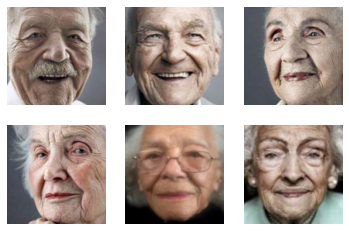

In [21]:
plot_img(images_A)

In [22]:
images_B = []

for filepath in young.path:
    img = np.array(Image.open(filepath).convert('RGB').resize((128, 128)))
    images_B.append(img)
images_B = np.array(images_B)


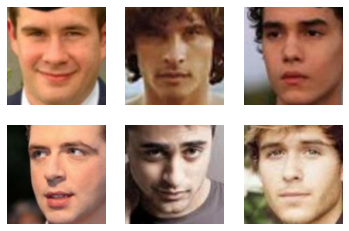

In [23]:
plot_img(images_B)

In [24]:
def normalization(images):
  images = (images - 127.5) / 127.5
  return images

In [25]:
old = normalization(images_A)
young = normalization(images_B)

## Modeller

In [26]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to c:\users\cansu\appdata\local\temp\pip-req-build-dz2zrhef
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0


  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git 'C:\Users\cansu\AppData\Local\Temp\pip-req-build-dz2zrhef'


In [27]:
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization,InputSpec

### Discriminator

In [28]:
def model_discriminator():
    input_shape = (128, 128, 3)
    init = RandomNormal(stddev=0.02) 
    input = Input(shape = input_shape)

    model = Conv2D(64,kernel_size=4,strides = 2, padding='same', kernel_initializer=init)(input)
    model = LeakyReLU(alpha=0.2)(model)
    
    model = Conv2D(128,kernel_size=4,strides=2, padding='same', kernel_initializer=init)(model)
    model = InstanceNormalization(axis=-1)(model)
    model = LeakyReLU(alpha=0.2)(model)

    model = Conv2D(256,kernel_size=4,strides=2, padding='same', kernel_initializer=init)(model)
    model = InstanceNormalization(axis=-1)(model)
    model = LeakyReLU(alpha=0.2)(model)

    model = Conv2D(512,kernel_size=4,strides=2, padding='same', kernel_initializer=init)(model)
    model = InstanceNormalization(axis=-1)(model)
    model = LeakyReLU(alpha=0.2)(model)
    
    model = Conv2D(1, kernel_size=4, strides=1,padding ='same', kernel_initializer=init)(model)
    
    model = Model(inputs=input, outputs=model)
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=[0.5])
    return model


In [29]:
disc = model_discriminator()

In [30]:
disc.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 64)        3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       131200    
_________________________________________________________________
instance_normalization (Inst (None, 32, 32, 128)       256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       524544

### Generator

In [31]:
def resnet_layer(inputlayer):

    filter_size= 256
    init = RandomNormal(stddev=0.02)
    #first layer
    layer = Conv2D(filters=filter_size, kernel_size=3, strides=1, padding='same', kernel_initializer=init)(inputlayer)
    layer = InstanceNormalization(axis=-1)(layer)
    layer = Activation('relu')(layer)

    #second layer
    layer = Conv2D(filters=filter_size, kernel_size=3, strides=1, padding='same', kernel_initializer=init)(layer)
    layer = InstanceNormalization(axis=-1)(layer) #3, center=True, epsilon=1e-5)(model,training =True)

    resnetlayer = Concatenate()([layer, inputlayer])
    return resnetlayer


In [32]:
def model_generator():
  
    #input  
    input_img = Input(shape=(128,128,3))
    init = RandomNormal(stddev=0.02)
    #layer 1

    model = Conv2D(64, kernel_size=(7,7), strides=1, padding='same', kernel_initializer=init)(input_img)
    model = InstanceNormalization(axis=-1)(model) #3, center=True, epsilon=1e-5)(model,training =True)
    model = Activation('relu')(model)

    model = Conv2D(128, kernel_size=(3,3), strides=2, padding='same', kernel_initializer=init)(model)
    model = InstanceNormalization(axis=-1)(model) #3, center=True, epsilon=1e-5)(model,training =True)
    model = Activation('relu')(model)

    model = Conv2D(256, kernel_size=(3,3), strides=2, padding='same', kernel_initializer=init)(model)
    model = InstanceNormalization(axis=-1)(model) #3, center=True, epsilon=1e-5)(model,training =True)
    model = Activation('relu')(model)
    
    for _ in range(4,10):
        model = resnet_layer(model)
    
    model = Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same', kernel_initializer=init)(model)
    model = InstanceNormalization(axis=-1)(model) #3, center=True, epsilon=1e-5)(model,training =True)
    model = Activation('relu')(model)

    model = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', kernel_initializer=init)(model)
    model = InstanceNormalization(axis=-1)(model) #3, center=True, epsilon=1e-5)(model,training =True)
    model = Activation('relu')(model)
    
    model = Conv2D(filters=3, kernel_size=7, strides=1, padding ='same', kernel_initializer=init)(model)
    model = Activation('tanh')(model)
    
    return Model(inputs=input_img, outputs=model)
generator = model_generator()
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 128, 128, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
instance_normalization_3 (Insta (None, 128, 128, 64) 128         conv2d_5[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           instance_normalization_3[0][0]   
____________________________________________________________________________________________

### Birleşik Model

In [33]:
def model_composite(gen1, disc, gen2):
    gen1.trainable = True
    disc.trainable = False
    gen2.trainable = False

    input_gen = Input(shape=(128,128,3))
    gen1_out = gen1(input_gen)
    # discriminator
    disc_out = disc(gen1_out)

    # identity 
    input_id = Input(shape=(128,128,3))
    output_id = gen1(input_id)

    # forward 
    forward_out = gen2(gen1_out)

    # backward 
    gen2_out = gen2(input_id)
    backward_out = gen1(gen2_out)

    model = Model([input_gen, input_id], [disc_out, output_id, forward_out, backward_out])

    opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
    return model

# Implementation

In [34]:
def real_samples(images, batch, out_shape):
    ix = np.random.randint(0, images.shape[0], batch)
    X = images[ix]
    y = np.ones((batch, out_shape, out_shape, 1))
    return X, y

In [35]:
def fake_samples(generator, images, out_shape):
    X = generator.predict(images)
    y = np.zeros((len(X), out_shape, out_shape, 1))
    return X, y

In [36]:
def save_models(step, generator_AtoB, generator_BtoA, discriminator_A, discriminator_B):
    filename1 = 'C:/Users/cansu/Desktop/bitirme_proje/UTK/Generated/g_model_AtoB_%06d.h5' % (step+1)
    tf.keras.models.save_model(generator_AtoB, filename1)

    filename2 = 'C:/Users/cansu/Desktop/bitirme_proje/UTK/Generated/g_model_BtoA_%06d.h5' % (step+1)
    tf.keras.models.save_model(generator_BtoA, filename2)
    
    filename3 = 'C:/Users/cansu/Desktop/bitirme_proje/UTK/Generated/d_model_A_%06d.h5' % (step+1)
    tf.keras.models.save_model(discriminator_A, filename3)

    filename4 = 'C:/Users/cansu/Desktop/bitirme_proje/UTK/Generated/d_model_B_%06d.h5' % (step+1)
    tf.keras.models.save_model(discriminator_B, filename4)  

    print('>Saved: %s, %s, %s ve %s' % (filename1, filename2, filename3,filename4))

In [37]:
def plot_img2(step, generator, images, name, n_samples=5):
    X_in, _ = real_samples(images, n_samples, 0)
    X_out, _ = fake_samples(generator, X_in, 0)

    #görüntülerin gösterilebilmesi için [0,1] arasına döndürülüyor 
    X_in = (X_in + 1) / 2.0
    X_out = (X_out + 1) / 2.0

    plt.figure(figsize=(15, 8))
    for i in range(n_samples):
        plt.subplot(2, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_in[i])

    for i in range(n_samples):
        plt.subplot(2, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_out[i])

    figure = 'C:/Users/cansu/Desktop/bitirme_proje/UTK/Generated/%s_generated_plot_%06d.png' % (name, (step+1))
    plt.savefig(figure)
    plt.close()

In [38]:
def update_image_pool(pool, images, max_size=50):
    selected = list()
    for image in images:
        if len(pool) < max_size:
            pool.append(image)
            selected.append(image)
        elif random.random() < 0.5:
            selected.append(image)
        else:
            ix = np.random.randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    return np.asarray(selected)

In [39]:
def train(discA, discB, generator_AtoB, generator_BtoA, composite_AtoB, composite_BtoA, batch_size, n_epochs, n):
    n_epochs, n_batch, = n_epochs, batch_size
    out_shape = discA.output_shape[1] #8

    poolA, poolB = list(), list()

    bat_per_epo = int(len(young) / n_batch)
    n_steps = bat_per_epo * n_epochs

    for i in range(n_steps):

        X_realA, y_realA = real_samples(young, n_batch, out_shape)
        X_realB, y_realB = real_samples(old, n_batch, out_shape)

        X_fakeA, y_fakeA = fake_samples(generator_BtoA, X_realB, out_shape)
        X_fakeB, y_fakeB = fake_samples(generator_AtoB, X_realA, out_shape)

        X_fakeA = update_image_pool(poolA, X_fakeA)
        X_fakeB = update_image_pool(poolB, X_fakeB)

        g_loss2, _, _, _, _  = composite_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])

        dA_loss1 = discA.train_on_batch(X_realA, y_realA)
        dA_loss2 = discA.train_on_batch(X_fakeA, y_fakeA)

        g_loss1, _, _, _, _ = composite_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])

        dB_loss1 = discB.train_on_batch(X_realB, y_realB)
        dB_loss2 = discB.train_on_batch(X_fakeB, y_fakeB)

        print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (n+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))

        if (n+1) % (bat_per_epo * 1) == 0:
            plot_img2(n, generator_AtoB, young, 'AtoB')

        if (n+1) % (bat_per_epo * 1) == 0:
            save_models(n, generator_AtoB, generator_BtoA, discA, discB)

        n+=1

In [34]:
#generator_AtoB = model_generator()
#generator_BtoA = model_generator()

#discriminator_A = model_discriminator()
#discriminator_B = model_discriminator()

#composite_AtoB = model_composite(generator_AtoB, discriminator_B, generator_BtoA)
#composite_BtoA = model_composite(generator_BtoA, discriminator_A, generator_AtoB)

In [41]:
cust = {'InstanceNormalization': InstanceNormalization, 'tf': tf}

generator_AtoB = load_model('C:/Users/cansu/Desktop/bitirme_proje/UTK/Generated/g_model_AtoB_027000.h5',cust, compile=False)
generator_BtoA = load_model('C:/Users/cansu/Desktop/bitirme_proje/UTK/Generated/g_model_BtoA_027000.h5',cust, compile=False)

discriminator_A = model_discriminator()
discriminator_B = model_discriminator()

composite_AtoB = model_composite(generator_AtoB, discriminator_B, generator_BtoA)
composite_BtoA = model_composite(generator_BtoA, discriminator_A, generator_AtoB)



In [ ]:
train(discriminator_A, discriminator_B, generator_AtoB, generator_BtoA, composite_AtoB, composite_BtoA, batch_size=2,n_epochs=10, n=27000)

>27001, dA[0.746,2.279] dB[0.574,1.415] g[2.310,3.027]
>27002, dA[0.840,0.674] dB[1.221,0.840] g[4.478,3.711]
>27003, dA[0.934,0.596] dB[0.869,1.002] g[3.230,4.188]
>27004, dA[1.210,0.817] dB[1.246,0.553] g[3.523,3.346]
>27005, dA[0.527,0.629] dB[0.814,0.478] g[3.422,2.762]
>27006, dA[0.837,1.335] dB[0.771,0.471] g[3.209,3.075]
>27007, dA[0.578,0.417] dB[0.460,0.619] g[2.706,2.486]
>27008, dA[0.522,0.646] dB[0.436,0.543] g[2.686,2.838]
>27009, dA[0.492,0.470] dB[0.517,0.456] g[2.767,2.580]
>27010, dA[0.625,0.511] dB[0.508,0.548] g[2.311,2.674]
>27011, dA[0.479,0.536] dB[0.504,0.342] g[2.819,2.631]
>27012, dA[0.347,0.490] dB[0.657,0.604] g[2.487,2.496]
>27013, dA[0.469,0.469] dB[0.701,0.967] g[2.758,2.454]
>27014, dA[0.405,0.398] dB[0.306,0.522] g[2.279,2.208]
>27015, dA[0.416,0.301] dB[0.361,0.513] g[2.233,2.600]
>27016, dA[0.323,0.474] dB[0.404,0.460] g[2.001,1.913]
>27017, dA[0.362,0.319] dB[0.418,0.329] g[1.942,2.227]
>27018, dA[0.279,0.335] dB[0.338,0.360] g[2.095,2.149]
>27019, dA

>27137, dA[0.291,0.182] dB[0.258,0.170] g[2.084,2.372]
>27138, dA[0.220,0.223] dB[0.187,0.160] g[1.620,1.814]
>27139, dA[0.236,0.133] dB[0.141,0.263] g[1.414,1.866]
>27140, dA[0.244,0.152] dB[0.240,0.153] g[1.736,1.993]
>27141, dA[0.186,0.250] dB[0.238,0.193] g[1.568,1.815]
>27142, dA[0.178,0.228] dB[0.157,0.183] g[1.937,2.261]
>27143, dA[0.193,0.179] dB[0.151,0.230] g[1.435,1.797]
>27144, dA[0.210,0.169] dB[0.264,0.220] g[2.114,2.081]
>27145, dA[0.172,0.166] dB[0.270,0.191] g[1.789,2.303]
>27146, dA[0.193,0.191] dB[0.138,0.197] g[1.538,2.522]
>27147, dA[0.180,0.180] dB[0.168,0.156] g[1.772,1.849]
>27148, dA[0.240,0.199] dB[0.206,0.150] g[1.719,2.146]
>27149, dA[0.165,0.194] dB[0.141,0.256] g[1.686,2.160]
>27150, dA[0.205,0.235] dB[0.230,0.139] g[1.862,1.875]
>27151, dA[0.148,0.190] dB[0.258,0.154] g[1.437,1.607]
>27152, dA[0.151,0.194] dB[0.143,0.198] g[1.668,2.037]
>27153, dA[0.180,0.201] dB[0.167,0.122] g[2.027,2.179]
>27154, dA[0.155,0.155] dB[0.261,0.193] g[1.861,1.961]
>27155, dA

>27286, dA[0.218,0.130] dB[0.133,0.175] g[1.639,1.988]
>27287, dA[0.152,0.250] dB[0.168,0.139] g[2.005,2.442]
>27288, dA[0.186,0.164] dB[0.146,0.156] g[1.680,2.023]
>27289, dA[0.230,0.133] dB[0.144,0.230] g[1.651,2.116]
>27290, dA[0.158,0.183] dB[0.229,0.171] g[1.542,1.615]
>27291, dA[0.188,0.160] dB[0.170,0.173] g[1.568,1.746]
>27292, dA[0.159,0.165] dB[0.183,0.137] g[1.780,1.832]
>27293, dA[0.212,0.159] dB[0.214,0.186] g[1.725,1.886]
>27294, dA[0.131,0.135] dB[0.165,0.209] g[1.645,2.129]
>27295, dA[0.181,0.277] dB[0.140,0.140] g[1.514,1.619]
>27296, dA[0.193,0.126] dB[0.231,0.138] g[1.644,1.954]
>27297, dA[0.234,0.176] dB[0.200,0.162] g[1.964,2.225]
>27298, dA[0.127,0.188] dB[0.178,0.170] g[1.431,1.509]
>27299, dA[0.171,0.151] dB[0.128,0.124] g[1.619,1.876]
>27300, dA[0.142,0.222] dB[0.225,0.136] g[1.741,1.640]
>27301, dA[0.147,0.158] dB[0.130,0.182] g[2.093,2.080]
>27302, dA[0.179,0.102] dB[0.157,0.239] g[1.825,1.955]
>27303, dA[0.192,0.190] dB[0.149,0.169] g[1.539,1.688]
>27304, dA

>27435, dA[0.183,0.118] dB[0.162,0.184] g[1.440,1.463]
>27436, dA[0.131,0.147] dB[0.214,0.210] g[1.519,1.703]
>27437, dA[0.179,0.246] dB[0.179,0.180] g[1.715,1.788]
>27438, dA[0.162,0.191] dB[0.198,0.142] g[1.515,1.560]
>27439, dA[0.205,0.166] dB[0.182,0.152] g[1.699,1.902]
>27440, dA[0.250,0.204] dB[0.162,0.208] g[1.292,1.687]
>27441, dA[0.151,0.187] dB[0.156,0.152] g[1.631,1.705]
>27442, dA[0.160,0.153] dB[0.185,0.142] g[1.564,1.704]
>27443, dA[0.159,0.123] dB[0.173,0.201] g[1.755,1.833]
>27444, dA[0.249,0.183] dB[0.164,0.140] g[1.608,1.731]
>27445, dA[0.179,0.168] dB[0.179,0.178] g[1.564,1.621]
>27446, dA[0.189,0.166] dB[0.200,0.184] g[1.528,1.607]
>27447, dA[0.182,0.190] dB[0.208,0.206] g[1.575,1.706]
>27448, dA[0.153,0.153] dB[0.172,0.186] g[1.550,1.777]
>27449, dA[0.142,0.191] dB[0.209,0.205] g[1.439,1.584]
>27450, dA[0.146,0.152] dB[0.152,0.163] g[1.420,1.741]
>27451, dA[0.185,0.164] dB[0.181,0.168] g[1.789,1.869]
>27452, dA[0.185,0.201] dB[0.167,0.165] g[1.488,1.675]
>27453, dA

>27584, dA[0.177,0.221] dB[0.190,0.185] g[1.813,1.910]
>27585, dA[0.187,0.156] dB[0.164,0.162] g[1.402,1.839]
>27586, dA[0.189,0.174] dB[0.132,0.193] g[1.405,1.920]
>27587, dA[0.175,0.148] dB[0.196,0.194] g[1.855,2.173]
>27588, dA[0.209,0.184] dB[0.183,0.162] g[1.711,1.977]
>27589, dA[0.218,0.187] dB[0.133,0.255] g[1.716,2.185]
>27590, dA[0.171,0.197] dB[0.200,0.188] g[1.560,1.879]
>27591, dA[0.181,0.144] dB[0.214,0.146] g[1.674,2.341]
>27592, dA[0.174,0.139] dB[0.142,0.168] g[1.402,1.861]
>27593, dA[0.126,0.174] dB[0.176,0.149] g[1.767,1.725]
>27594, dA[0.153,0.166] dB[0.156,0.187] g[1.737,1.561]
>27595, dA[0.193,0.166] dB[0.164,0.154] g[1.804,1.760]
>27596, dA[0.156,0.178] dB[0.200,0.133] g[1.748,1.719]
>27597, dA[0.171,0.164] dB[0.170,0.167] g[1.668,2.486]
>27598, dA[0.209,0.221] dB[0.223,0.197] g[1.801,2.201]
>27599, dA[0.152,0.127] dB[0.168,0.125] g[1.747,2.073]
>27600, dA[0.180,0.158] dB[0.174,0.219] g[1.453,1.719]
>27601, dA[0.127,0.135] dB[0.152,0.089] g[1.536,2.051]
>27602, dA

>27733, dA[0.155,0.125] dB[0.153,0.120] g[1.500,1.645]
>27734, dA[0.218,0.179] dB[0.176,0.258] g[1.971,2.850]
>27735, dA[0.179,0.168] dB[0.218,0.169] g[1.573,1.610]
>27736, dA[0.161,0.148] dB[0.154,0.131] g[1.445,1.690]
>27737, dA[0.138,0.123] dB[0.190,0.140] g[1.490,1.389]
>27738, dA[0.129,0.194] dB[0.158,0.211] g[1.514,1.630]
>27739, dA[0.131,0.163] dB[0.169,0.148] g[1.552,1.668]
>27740, dA[0.166,0.187] dB[0.167,0.167] g[1.764,1.935]
>27741, dA[0.128,0.159] dB[0.181,0.172] g[1.696,1.567]
>27742, dA[0.114,0.191] dB[0.157,0.153] g[1.899,1.987]
>27743, dA[0.155,0.143] dB[0.190,0.141] g[1.412,2.026]
>27744, dA[0.131,0.136] dB[0.173,0.198] g[1.449,1.761]
>27745, dA[0.174,0.206] dB[0.171,0.124] g[1.561,1.660]
>27746, dA[0.226,0.166] dB[0.157,0.197] g[1.601,2.315]
>27747, dA[0.179,0.129] dB[0.177,0.186] g[1.426,1.822]
>27748, dA[0.197,0.215] dB[0.158,0.171] g[1.352,1.617]
>27749, dA[0.146,0.158] dB[0.115,0.086] g[1.620,1.681]
>27750, dA[0.164,0.175] dB[0.193,0.248] g[2.045,2.294]
>27751, dA

>27882, dA[0.191,0.178] dB[0.177,0.123] g[1.395,1.647]
>27883, dA[0.183,0.167] dB[0.179,0.115] g[1.459,1.674]
>27884, dA[0.139,0.133] dB[0.079,0.166] g[1.611,1.783]
>27885, dA[0.163,0.196] dB[0.232,0.168] g[1.392,1.361]
>27886, dA[0.211,0.148] dB[0.139,0.209] g[1.460,1.757]
>27887, dA[0.161,0.154] dB[0.136,0.134] g[1.413,1.658]
>27888, dA[0.146,0.186] dB[0.220,0.123] g[1.896,2.002]
>27889, dA[0.161,0.194] dB[0.129,0.178] g[1.500,1.716]
>27890, dA[0.200,0.149] dB[0.233,0.230] g[1.524,1.659]
>27891, dA[0.169,0.149] dB[0.208,0.180] g[1.708,1.895]
>27892, dA[0.173,0.183] dB[0.164,0.176] g[1.683,2.058]
>27893, dA[0.149,0.192] dB[0.154,0.139] g[1.418,1.675]
>27894, dA[0.169,0.165] dB[0.156,0.155] g[1.825,1.942]
>27895, dA[0.179,0.174] dB[0.213,0.176] g[1.587,1.647]
>27896, dA[0.152,0.153] dB[0.173,0.219] g[1.507,1.703]
>27897, dA[0.133,0.186] dB[0.226,0.145] g[1.656,1.806]
>27898, dA[0.181,0.152] dB[0.159,0.185] g[1.399,1.580]
>27899, dA[0.221,0.164] dB[0.181,0.156] g[1.600,1.887]
>27900, dA

>28020, dA[0.152,0.136] dB[0.171,0.153] g[1.496,1.574]
>28021, dA[0.148,0.164] dB[0.177,0.143] g[1.613,2.029]
>28022, dA[0.180,0.161] dB[0.141,0.196] g[1.612,1.906]
>28023, dA[0.170,0.187] dB[0.167,0.174] g[1.439,1.554]
>28024, dA[0.181,0.148] dB[0.144,0.146] g[1.571,1.710]
>28025, dA[0.138,0.177] dB[0.136,0.199] g[1.580,1.744]
>28026, dA[0.170,0.159] dB[0.162,0.150] g[1.708,2.215]
>28027, dA[0.164,0.192] dB[0.224,0.138] g[1.510,1.829]
>28028, dA[0.178,0.156] dB[0.170,0.179] g[1.593,2.083]
>28029, dA[0.172,0.161] dB[0.165,0.124] g[1.619,1.866]
>28030, dA[0.169,0.191] dB[0.120,0.186] g[1.346,1.525]
>28031, dA[0.157,0.133] dB[0.142,0.150] g[1.529,1.816]
>28032, dA[0.144,0.158] dB[0.205,0.159] g[1.617,1.709]
>28033, dA[0.165,0.170] dB[0.169,0.172] g[1.431,1.588]
>28034, dA[0.177,0.125] dB[0.127,0.110] g[1.326,1.656]
>28035, dA[0.134,0.192] dB[0.170,0.123] g[1.655,1.852]
>28036, dA[0.196,0.145] dB[0.166,0.272] g[1.376,1.808]
>28037, dA[0.184,0.241] dB[0.151,0.173] g[1.561,1.841]
>28038, dA

>28169, dA[0.200,0.190] dB[0.200,0.194] g[1.467,1.863]
>28170, dA[0.152,0.165] dB[0.137,0.095] g[1.596,1.455]
>28171, dA[0.151,0.166] dB[0.224,0.165] g[1.455,1.541]
>28172, dA[0.245,0.145] dB[0.106,0.217] g[1.294,1.854]
>28173, dA[0.138,0.158] dB[0.189,0.118] g[1.552,1.624]
>28174, dA[0.160,0.174] dB[0.188,0.139] g[1.709,1.723]
>28175, dA[0.132,0.117] dB[0.123,0.168] g[1.892,2.438]
>28176, dA[0.160,0.207] dB[0.224,0.169] g[1.617,1.580]
>28177, dA[0.150,0.123] dB[0.156,0.203] g[1.399,1.731]
>28178, dA[0.181,0.187] dB[0.183,0.182] g[1.719,1.904]
>28179, dA[0.200,0.134] dB[0.207,0.177] g[1.527,1.590]
>28180, dA[0.191,0.198] dB[0.190,0.148] g[1.635,1.716]
>28181, dA[0.115,0.152] dB[0.198,0.197] g[1.430,1.548]
>28182, dA[0.194,0.149] dB[0.148,0.143] g[1.255,1.891]
>28183, dA[0.158,0.224] dB[0.191,0.130] g[1.357,1.616]
>28184, dA[0.185,0.161] dB[0.172,0.193] g[2.050,1.952]
>28185, dA[0.172,0.137] dB[0.153,0.150] g[1.371,1.525]
>28186, dA[0.165,0.180] dB[0.175,0.137] g[1.559,1.601]
>28187, dA

>28318, dA[0.166,0.140] dB[0.197,0.174] g[1.596,1.810]
>28319, dA[0.125,0.191] dB[0.131,0.143] g[1.526,1.785]
>28320, dA[0.191,0.162] dB[0.194,0.197] g[1.661,2.265]
>28321, dA[0.174,0.134] dB[0.203,0.134] g[1.834,1.857]
>28322, dA[0.141,0.167] dB[0.118,0.226] g[1.328,1.547]
>28323, dA[0.110,0.217] dB[0.255,0.139] g[1.587,1.578]
>28324, dA[0.206,0.129] dB[0.199,0.154] g[1.589,2.228]
>28325, dA[0.159,0.161] dB[0.146,0.108] g[1.483,1.863]
>28326, dA[0.219,0.159] dB[0.150,0.254] g[1.385,1.757]
>28327, dA[0.168,0.192] dB[0.161,0.177] g[1.474,1.513]
>28328, dA[0.158,0.127] dB[0.144,0.169] g[1.523,1.776]
>28329, dA[0.189,0.166] dB[0.172,0.160] g[1.686,1.917]
>28330, dA[0.121,0.172] dB[0.216,0.142] g[1.644,1.488]
>28331, dA[0.146,0.215] dB[0.224,0.176] g[1.486,1.628]
>28332, dA[0.166,0.182] dB[0.180,0.178] g[1.504,1.734]
>28333, dA[0.201,0.139] dB[0.105,0.194] g[1.375,1.971]
>28334, dA[0.182,0.223] dB[0.165,0.176] g[1.522,1.745]
>28335, dA[0.182,0.111] dB[0.164,0.181] g[1.457,1.680]
>28336, dA

>28467, dA[0.129,0.244] dB[0.152,0.171] g[1.501,1.610]
>28468, dA[0.175,0.143] dB[0.129,0.220] g[1.483,2.036]
>28469, dA[0.194,0.129] dB[0.155,0.151] g[1.570,1.989]
>28470, dA[0.184,0.176] dB[0.221,0.186] g[1.593,1.727]
>28471, dA[0.148,0.173] dB[0.146,0.139] g[1.574,1.686]
>28472, dA[0.175,0.145] dB[0.207,0.156] g[1.432,1.785]
>28473, dA[0.217,0.142] dB[0.171,0.176] g[1.328,1.680]
>28474, dA[0.145,0.149] dB[0.097,0.145] g[1.279,1.856]
>28475, dA[0.149,0.144] dB[0.147,0.101] g[1.741,1.879]
>28476, dA[0.173,0.192] dB[0.174,0.192] g[1.560,1.879]
>28477, dA[0.136,0.158] dB[0.147,0.170] g[1.247,1.271]
>28478, dA[0.169,0.114] dB[0.129,0.117] g[1.427,1.536]
>28479, dA[0.123,0.138] dB[0.163,0.134] g[1.487,1.661]
>28480, dA[0.154,0.133] dB[0.138,0.186] g[1.430,1.890]
>28481, dA[0.127,0.244] dB[0.217,0.136] g[1.502,1.452]
>28482, dA[0.163,0.143] dB[0.142,0.154] g[1.776,2.407]
>28483, dA[0.180,0.113] dB[0.106,0.130] g[1.398,1.573]
>28484, dA[0.173,0.162] dB[0.170,0.136] g[1.249,1.308]
>28485, dA

>28616, dA[0.157,0.141] dB[0.166,0.121] g[1.353,1.405]
>28617, dA[0.153,0.162] dB[0.179,0.187] g[1.459,1.765]
>28618, dA[0.201,0.141] dB[0.133,0.156] g[1.744,2.003]
>28619, dA[0.184,0.153] dB[0.204,0.198] g[1.379,1.587]
>28620, dA[0.230,0.137] dB[0.132,0.184] g[1.323,1.595]
>28621, dA[0.205,0.163] dB[0.187,0.129] g[1.494,1.759]
>28622, dA[0.143,0.164] dB[0.191,0.156] g[1.189,1.273]
>28623, dA[0.118,0.196] dB[0.165,0.183] g[1.570,1.894]
>28624, dA[0.166,0.136] dB[0.156,0.164] g[1.751,2.381]
>28625, dA[0.153,0.167] dB[0.162,0.116] g[1.526,1.942]
>28626, dA[0.218,0.148] dB[0.174,0.143] g[1.632,1.834]
>28627, dA[0.181,0.149] dB[0.156,0.170] g[1.319,1.445]
>28628, dA[0.132,0.204] dB[0.158,0.165] g[1.274,1.702]
>28629, dA[0.133,0.161] dB[0.174,0.163] g[1.697,1.596]
>28630, dA[0.173,0.148] dB[0.157,0.162] g[1.676,1.724]
>28631, dA[0.164,0.138] dB[0.139,0.213] g[1.431,1.604]
>28632, dA[0.143,0.129] dB[0.141,0.123] g[1.491,1.646]
>28633, dA[0.183,0.129] dB[0.153,0.130] g[1.554,2.136]
>28634, dA

>28765, dA[0.192,0.149] dB[0.139,0.175] g[1.467,1.826]
>28766, dA[0.179,0.184] dB[0.147,0.099] g[1.672,1.651]
>28767, dA[0.162,0.165] dB[0.149,0.186] g[1.357,1.425]
>28768, dA[0.193,0.180] dB[0.119,0.138] g[1.773,1.996]
>28769, dA[0.186,0.156] dB[0.217,0.204] g[1.588,1.869]
>28770, dA[0.164,0.143] dB[0.175,0.152] g[1.388,1.701]
>28771, dA[0.129,0.197] dB[0.170,0.179] g[1.146,1.306]
>28772, dA[0.145,0.140] dB[0.164,0.155] g[1.183,1.333]
>28773, dA[0.176,0.139] dB[0.199,0.178] g[1.368,1.703]
>28774, dA[0.202,0.167] dB[0.119,0.164] g[1.521,1.670]
>28775, dA[0.127,0.173] dB[0.152,0.149] g[1.387,1.457]
>28776, dA[0.126,0.171] dB[0.168,0.141] g[1.393,1.473]
>28777, dA[0.152,0.162] dB[0.143,0.204] g[1.530,1.951]
>28778, dA[0.152,0.190] dB[0.163,0.173] g[1.548,1.784]
>28779, dA[0.164,0.101] dB[0.147,0.127] g[1.378,1.655]
>28780, dA[0.128,0.156] dB[0.148,0.121] g[1.358,1.530]
>28781, dA[0.104,0.136] dB[0.164,0.124] g[1.776,2.162]
>28782, dA[0.181,0.174] dB[0.126,0.144] g[1.631,1.791]
>28783, dA

>28914, dA[0.189,0.130] dB[0.205,0.114] g[1.536,2.033]
>28915, dA[0.160,0.192] dB[0.196,0.118] g[1.398,1.444]
>28916, dA[0.116,0.186] dB[0.109,0.151] g[1.623,1.702]
>28917, dA[0.165,0.166] dB[0.191,0.163] g[1.830,2.075]
>28918, dA[0.216,0.166] dB[0.193,0.142] g[1.395,1.697]
>28919, dA[0.177,0.112] dB[0.159,0.205] g[1.583,1.901]
>28920, dA[0.149,0.156] dB[0.172,0.161] g[1.268,1.866]
>28921, dA[0.097,0.154] dB[0.171,0.174] g[1.557,1.842]
>28922, dA[0.161,0.128] dB[0.230,0.151] g[1.667,1.740]
>28923, dA[0.141,0.166] dB[0.165,0.148] g[1.414,1.700]
>28924, dA[0.159,0.181] dB[0.135,0.150] g[1.315,1.654]
>28925, dA[0.208,0.146] dB[0.159,0.166] g[1.357,1.665]
>28926, dA[0.205,0.186] dB[0.154,0.175] g[1.214,1.582]
>28927, dA[0.116,0.173] dB[0.192,0.130] g[1.731,1.849]
>28928, dA[0.173,0.161] dB[0.155,0.130] g[1.619,2.062]
>28929, dA[0.191,0.161] dB[0.139,0.181] g[1.287,1.731]
>28930, dA[0.185,0.150] dB[0.183,0.178] g[1.586,1.799]
>28931, dA[0.234,0.173] dB[0.204,0.178] g[1.482,2.068]
>28932, dA

>29052, dA[0.188,0.147] dB[0.167,0.162] g[1.499,1.668]
>29053, dA[0.156,0.139] dB[0.111,0.177] g[2.103,3.009]
>29054, dA[0.126,0.143] dB[0.173,0.138] g[1.647,1.991]
>29055, dA[0.172,0.160] dB[0.175,0.121] g[1.417,1.822]
>29056, dA[0.237,0.173] dB[0.190,0.200] g[1.594,2.089]
>29057, dA[0.176,0.170] dB[0.148,0.176] g[1.464,1.791]
>29058, dA[0.143,0.160] dB[0.173,0.106] g[1.577,1.819]
>29059, dA[0.148,0.157] dB[0.150,0.166] g[1.533,1.625]
>29060, dA[0.202,0.148] dB[0.167,0.181] g[1.522,1.707]
>29061, dA[0.212,0.156] dB[0.069,0.122] g[1.292,1.727]
>29062, dA[0.177,0.173] dB[0.195,0.138] g[1.533,1.700]
>29063, dA[0.168,0.176] dB[0.157,0.127] g[1.587,1.814]
>29064, dA[0.222,0.133] dB[0.172,0.247] g[1.499,1.847]
>29065, dA[0.148,0.137] dB[0.128,0.150] g[1.400,1.762]
>29066, dA[0.147,0.126] dB[0.156,0.131] g[1.544,1.618]
>29067, dA[0.140,0.148] dB[0.155,0.152] g[1.779,1.966]
>29068, dA[0.148,0.170] dB[0.175,0.168] g[1.453,1.730]
>29069, dA[0.157,0.194] dB[0.130,0.178] g[1.306,1.543]
>29070, dA

>29201, dA[0.173,0.136] dB[0.145,0.190] g[1.448,1.946]
>29202, dA[0.166,0.117] dB[0.115,0.159] g[1.417,1.730]
>29203, dA[0.122,0.171] dB[0.157,0.095] g[1.368,1.549]
>29204, dA[0.097,0.172] dB[0.165,0.118] g[1.362,1.344]
>29205, dA[0.174,0.112] dB[0.111,0.145] g[1.316,1.744]
>29206, dA[0.151,0.163] dB[0.099,0.130] g[1.531,1.543]
>29207, dA[0.167,0.124] dB[0.229,0.147] g[1.371,1.500]
>29208, dA[0.190,0.185] dB[0.138,0.176] g[1.300,1.640]
>29209, dA[0.129,0.192] dB[0.129,0.172] g[1.233,1.481]
>29210, dA[0.145,0.149] dB[0.103,0.097] g[1.526,1.753]
>29211, dA[0.137,0.115] dB[0.148,0.143] g[1.676,1.879]
>29212, dA[0.148,0.174] dB[0.159,0.171] g[1.830,1.610]
>29213, dA[0.159,0.213] dB[0.197,0.108] g[1.420,1.426]
>29214, dA[0.180,0.133] dB[0.132,0.201] g[1.728,1.839]
>29215, dA[0.182,0.120] dB[0.084,0.133] g[1.427,1.888]
>29216, dA[0.202,0.181] dB[0.152,0.180] g[1.730,1.748]
>29217, dA[0.159,0.144] dB[0.185,0.155] g[1.756,2.056]
>29218, dA[0.137,0.152] dB[0.203,0.208] g[1.635,1.579]
>29219, dA

>29350, dA[0.179,0.162] dB[0.172,0.135] g[1.396,1.632]
>29351, dA[0.193,0.169] dB[0.180,0.213] g[1.457,1.675]
>29352, dA[0.128,0.105] dB[0.159,0.161] g[1.408,1.659]
>29353, dA[0.231,0.146] dB[0.174,0.180] g[1.385,1.716]
>29354, dA[0.183,0.167] dB[0.141,0.146] g[1.385,1.539]
>29355, dA[0.173,0.163] dB[0.174,0.131] g[1.418,1.609]
>29356, dA[0.152,0.172] dB[0.155,0.124] g[1.596,1.887]
>29357, dA[0.120,0.147] dB[0.167,0.164] g[1.528,1.680]
>29358, dA[0.190,0.150] dB[0.186,0.139] g[1.570,1.955]
>29359, dA[0.173,0.143] dB[0.132,0.169] g[1.501,1.593]
>29360, dA[0.160,0.168] dB[0.116,0.145] g[1.442,1.444]
>29361, dA[0.152,0.193] dB[0.206,0.142] g[1.351,1.351]
>29362, dA[0.163,0.163] dB[0.172,0.156] g[1.710,1.823]
>29363, dA[0.181,0.163] dB[0.116,0.186] g[1.419,1.694]
>29364, dA[0.139,0.186] dB[0.149,0.175] g[1.497,2.060]
>29365, dA[0.147,0.160] dB[0.213,0.121] g[1.677,1.911]
>29366, dA[0.244,0.186] dB[0.131,0.191] g[1.514,1.660]
>29367, dA[0.150,0.186] dB[0.179,0.180] g[1.759,2.293]
>29368, dA

>29499, dA[0.115,0.201] dB[0.144,0.142] g[1.403,1.654]
>29500, dA[0.124,0.205] dB[0.217,0.166] g[1.714,1.937]
>29501, dA[0.229,0.160] dB[0.217,0.209] g[1.804,1.848]
>29502, dA[0.199,0.176] dB[0.144,0.219] g[1.336,1.721]
>29503, dA[0.127,0.165] dB[0.127,0.143] g[1.456,1.754]
>29504, dA[0.158,0.145] dB[0.166,0.160] g[1.784,1.960]
>29505, dA[0.206,0.170] dB[0.159,0.139] g[1.397,1.823]
>29506, dA[0.183,0.187] dB[0.181,0.136] g[1.560,1.739]
>29507, dA[0.202,0.124] dB[0.190,0.146] g[1.782,1.997]
>29508, dA[0.155,0.160] dB[0.129,0.168] g[1.296,1.454]
>29509, dA[0.199,0.118] dB[0.153,0.169] g[1.332,1.488]
>29510, dA[0.171,0.173] dB[0.132,0.182] g[1.451,1.453]
>29511, dA[0.163,0.192] dB[0.134,0.136] g[1.511,1.608]
>29512, dA[0.147,0.154] dB[0.119,0.160] g[1.519,1.673]
>29513, dA[0.133,0.180] dB[0.157,0.140] g[1.289,1.540]
>29514, dA[0.176,0.197] dB[0.127,0.170] g[1.254,1.440]
>29515, dA[0.198,0.117] dB[0.137,0.081] g[1.244,1.795]
>29516, dA[0.158,0.140] dB[0.219,0.216] g[1.333,1.373]
>29517, dA

>29648, dA[0.212,0.181] dB[0.177,0.185] g[1.206,1.422]
>29649, dA[0.143,0.116] dB[0.163,0.156] g[1.417,1.554]
>29650, dA[0.109,0.176] dB[0.168,0.134] g[1.260,1.389]
>29651, dA[0.141,0.156] dB[0.134,0.133] g[1.569,1.774]
>29652, dA[0.208,0.160] dB[0.103,0.163] g[1.376,1.897]
>29653, dA[0.125,0.160] dB[0.161,0.196] g[1.430,1.688]
>29654, dA[0.188,0.126] dB[0.137,0.167] g[1.265,1.669]
>29655, dA[0.168,0.180] dB[0.193,0.087] g[1.679,1.670]
>29656, dA[0.202,0.158] dB[0.140,0.150] g[1.925,2.334]
>29657, dA[0.167,0.129] dB[0.128,0.163] g[1.532,1.629]
>29658, dA[0.231,0.164] dB[0.146,0.143] g[1.205,1.508]
>29659, dA[0.101,0.134] dB[0.206,0.164] g[1.285,1.719]
>29660, dA[0.139,0.135] dB[0.227,0.122] g[1.329,1.417]
>29661, dA[0.141,0.124] dB[0.182,0.126] g[1.548,1.540]
>29662, dA[0.153,0.198] dB[0.160,0.216] g[1.327,1.438]
>29663, dA[0.098,0.117] dB[0.131,0.125] g[1.406,1.573]
>29664, dA[0.145,0.113] dB[0.134,0.129] g[1.297,1.578]
>29665, dA[0.107,0.169] dB[0.190,0.093] g[1.437,1.302]
>29666, dA

>29797, dA[0.178,0.142] dB[0.157,0.145] g[1.441,1.913]
>29798, dA[0.169,0.156] dB[0.181,0.159] g[1.267,1.317]
>29799, dA[0.158,0.179] dB[0.127,0.128] g[1.337,1.417]
>29800, dA[0.186,0.158] dB[0.188,0.114] g[1.564,1.727]
>29801, dA[0.177,0.145] dB[0.105,0.213] g[1.254,1.467]
>29802, dA[0.084,0.175] dB[0.219,0.146] g[1.662,1.686]
>29803, dA[0.154,0.166] dB[0.179,0.176] g[1.671,1.876]
>29804, dA[0.184,0.116] dB[0.140,0.157] g[1.508,1.693]
>29805, dA[0.139,0.222] dB[0.187,0.189] g[1.399,1.688]
>29806, dA[0.248,0.124] dB[0.136,0.141] g[1.215,1.493]
>29807, dA[0.143,0.150] dB[0.109,0.159] g[1.408,1.634]
>29808, dA[0.136,0.156] dB[0.189,0.163] g[1.481,1.836]
>29809, dA[0.175,0.186] dB[0.185,0.177] g[1.376,1.332]
>29810, dA[0.134,0.107] dB[0.207,0.121] g[1.502,1.584]
>29811, dA[0.142,0.169] dB[0.187,0.115] g[1.591,1.747]
>29812, dA[0.130,0.197] dB[0.183,0.222] g[1.367,1.671]
>29813, dA[0.208,0.106] dB[0.118,0.142] g[1.457,1.668]
>29814, dA[0.177,0.169] dB[0.140,0.191] g[1.225,1.497]
>29815, dA

>29946, dA[0.127,0.121] dB[0.110,0.130] g[1.446,1.605]
>29947, dA[0.214,0.138] dB[0.131,0.175] g[1.464,1.811]
>29948, dA[0.239,0.147] dB[0.142,0.139] g[1.447,1.677]
>29949, dA[0.176,0.163] dB[0.122,0.147] g[1.522,1.889]
>29950, dA[0.134,0.115] dB[0.107,0.102] g[1.322,1.696]
>29951, dA[0.160,0.160] dB[0.166,0.232] g[1.424,1.565]
>29952, dA[0.112,0.192] dB[0.158,0.183] g[1.393,1.602]
>29953, dA[0.219,0.166] dB[0.207,0.136] g[1.382,1.514]
>29954, dA[0.173,0.189] dB[0.122,0.168] g[1.585,1.845]
>29955, dA[0.161,0.169] dB[0.145,0.131] g[1.484,1.741]
>29956, dA[0.129,0.152] dB[0.128,0.162] g[1.512,1.710]
>29957, dA[0.155,0.140] dB[0.178,0.112] g[1.585,1.725]
>29958, dA[0.173,0.181] dB[0.202,0.203] g[1.429,1.481]
>29959, dA[0.103,0.163] dB[0.121,0.162] g[1.823,1.771]
>29960, dA[0.156,0.106] dB[0.144,0.200] g[1.379,1.509]
>29961, dA[0.182,0.173] dB[0.211,0.123] g[1.608,1.751]
>29962, dA[0.159,0.140] dB[0.158,0.170] g[1.474,1.585]
>29963, dA[0.175,0.160] dB[0.152,0.181] g[1.421,1.616]
>29964, dA

>30084, dA[0.149,0.112] dB[0.144,0.151] g[1.524,1.776]
>30085, dA[0.132,0.088] dB[0.177,0.160] g[1.319,1.445]
>30086, dA[0.185,0.200] dB[0.136,0.206] g[1.389,1.533]
>30087, dA[0.203,0.153] dB[0.154,0.187] g[1.453,1.712]
>30088, dA[0.172,0.163] dB[0.174,0.121] g[1.578,1.865]
>30089, dA[0.140,0.175] dB[0.129,0.155] g[1.462,1.456]
>30090, dA[0.188,0.153] dB[0.205,0.164] g[1.405,1.511]
>30091, dA[0.202,0.193] dB[0.140,0.156] g[1.603,1.531]
>30092, dA[0.199,0.180] dB[0.126,0.153] g[1.155,1.423]
>30093, dA[0.147,0.133] dB[0.133,0.204] g[1.435,1.676]
>30094, dA[0.164,0.147] dB[0.167,0.143] g[1.309,1.426]
>30095, dA[0.166,0.158] dB[0.146,0.142] g[1.402,1.770]
>30096, dA[0.138,0.161] dB[0.175,0.129] g[1.754,1.770]
>30097, dA[0.191,0.125] dB[0.188,0.147] g[1.688,1.807]
>30098, dA[0.182,0.141] dB[0.160,0.166] g[1.590,1.665]
>30099, dA[0.155,0.152] dB[0.152,0.175] g[1.516,1.732]
>30100, dA[0.118,0.185] dB[0.165,0.145] g[1.666,1.811]
>30101, dA[0.202,0.126] dB[0.193,0.149] g[1.358,1.559]
>30102, dA

>30233, dA[0.163,0.148] dB[0.137,0.143] g[1.679,1.988]
>30234, dA[0.101,0.122] dB[0.167,0.110] g[1.309,1.938]
>30235, dA[0.139,0.128] dB[0.201,0.128] g[1.538,1.624]
>30236, dA[0.174,0.167] dB[0.163,0.171] g[1.465,1.718]
>30237, dA[0.260,0.184] dB[0.141,0.178] g[1.315,1.651]
>30238, dA[0.142,0.199] dB[0.143,0.160] g[1.672,2.183]
>30239, dA[0.207,0.142] dB[0.185,0.206] g[1.643,1.748]
>30240, dA[0.199,0.131] dB[0.190,0.143] g[1.469,1.713]
>30241, dA[0.093,0.252] dB[0.181,0.149] g[1.492,1.987]
>30242, dA[0.202,0.137] dB[0.156,0.139] g[1.412,1.710]
>30243, dA[0.196,0.117] dB[0.161,0.130] g[1.254,1.393]
>30244, dA[0.190,0.161] dB[0.167,0.133] g[1.487,1.715]
>30245, dA[0.163,0.157] dB[0.189,0.203] g[1.663,2.516]
>30246, dA[0.103,0.128] dB[0.162,0.132] g[1.397,1.514]
>30247, dA[0.137,0.191] dB[0.141,0.153] g[1.584,1.758]
>30248, dA[0.097,0.185] dB[0.174,0.148] g[1.434,1.716]
>30249, dA[0.218,0.139] dB[0.182,0.164] g[1.288,1.448]
>30250, dA[0.153,0.127] dB[0.139,0.137] g[1.342,1.748]
>30251, dA

>30382, dA[0.138,0.210] dB[0.206,0.111] g[1.542,1.508]
>30383, dA[0.241,0.129] dB[0.187,0.169] g[1.411,1.892]
>30384, dA[0.146,0.139] dB[0.129,0.139] g[1.515,1.703]
>30385, dA[0.187,0.183] dB[0.153,0.133] g[1.310,1.562]
>30386, dA[0.143,0.144] dB[0.159,0.180] g[1.471,1.785]
>30387, dA[0.140,0.111] dB[0.158,0.192] g[1.438,1.475]
>30388, dA[0.170,0.190] dB[0.149,0.121] g[1.264,1.529]
>30389, dA[0.160,0.154] dB[0.149,0.176] g[1.247,1.329]
>30390, dA[0.146,0.164] dB[0.122,0.099] g[1.451,1.815]
>30391, dA[0.197,0.137] dB[0.184,0.166] g[1.475,1.487]
>30392, dA[0.177,0.178] dB[0.120,0.178] g[1.373,1.553]
>30393, dA[0.195,0.175] dB[0.182,0.195] g[1.396,1.744]
>30394, dA[0.216,0.136] dB[0.156,0.147] g[1.488,1.717]
>30395, dA[0.235,0.145] dB[0.194,0.246] g[1.140,1.474]
>30396, dA[0.151,0.143] dB[0.132,0.134] g[2.253,2.063]
>30397, dA[0.171,0.184] dB[0.147,0.166] g[1.367,1.494]
>30398, dA[0.116,0.154] dB[0.162,0.111] g[1.847,2.205]
>30399, dA[0.131,0.114] dB[0.211,0.144] g[1.549,1.740]
>30400, dA

>30531, dA[0.192,0.200] dB[0.162,0.114] g[1.413,1.737]
>30532, dA[0.120,0.161] dB[0.134,0.204] g[1.247,1.569]
>30533, dA[0.147,0.164] dB[0.157,0.142] g[1.418,1.673]
>30534, dA[0.149,0.153] dB[0.161,0.176] g[1.579,1.651]
>30535, dA[0.100,0.136] dB[0.165,0.142] g[1.458,1.654]
>30536, dA[0.169,0.138] dB[0.128,0.118] g[1.309,1.610]
>30537, dA[0.195,0.141] dB[0.108,0.184] g[1.130,1.631]
>30538, dA[0.146,0.143] dB[0.109,0.166] g[1.354,1.654]
>30539, dA[0.166,0.185] dB[0.156,0.143] g[1.465,1.551]
>30540, dA[0.137,0.151] dB[0.086,0.138] g[1.304,1.462]
>30541, dA[0.108,0.123] dB[0.145,0.190] g[1.224,1.531]
>30542, dA[0.254,0.101] dB[0.146,0.153] g[1.260,1.733]
>30543, dA[0.153,0.238] dB[0.130,0.101] g[1.422,1.518]
>30544, dA[0.127,0.102] dB[0.171,0.143] g[1.215,1.522]
>30545, dA[0.146,0.115] dB[0.148,0.202] g[1.114,1.482]
>30546, dA[0.124,0.225] dB[0.143,0.203] g[1.202,1.278]
>30547, dA[0.146,0.146] dB[0.169,0.174] g[1.566,1.748]
>30548, dA[0.253,0.081] dB[0.130,0.081] g[1.589,1.717]
>30549, dA

>30680, dA[0.171,0.228] dB[0.113,0.198] g[1.206,1.496]
>30681, dA[0.161,0.123] dB[0.141,0.146] g[1.576,1.783]
>30682, dA[0.145,0.162] dB[0.149,0.120] g[1.438,1.723]
>30683, dA[0.153,0.126] dB[0.197,0.115] g[1.617,1.688]
>30684, dA[0.145,0.218] dB[0.186,0.156] g[1.543,1.371]
>30685, dA[0.180,0.140] dB[0.115,0.204] g[1.353,1.656]
>30686, dA[0.203,0.124] dB[0.088,0.147] g[1.440,1.915]
>30687, dA[0.115,0.179] dB[0.131,0.115] g[1.545,1.876]
>30688, dA[0.123,0.129] dB[0.165,0.129] g[1.663,1.815]
>30689, dA[0.121,0.128] dB[0.137,0.105] g[1.382,1.461]
>30690, dA[0.129,0.188] dB[0.127,0.242] g[1.249,1.517]
>30691, dA[0.190,0.161] dB[0.185,0.158] g[1.294,1.483]
>30692, dA[0.127,0.152] dB[0.200,0.111] g[1.567,1.547]
>30693, dA[0.138,0.121] dB[0.157,0.134] g[1.424,1.478]
>30694, dA[0.100,0.243] dB[0.176,0.175] g[1.469,1.523]
>30695, dA[0.236,0.104] dB[0.171,0.211] g[1.093,1.517]
>30696, dA[0.180,0.126] dB[0.148,0.175] g[1.482,1.757]
>30697, dA[0.168,0.160] dB[0.151,0.169] g[1.272,1.240]
>30698, dA

>30829, dA[0.124,0.216] dB[0.180,0.144] g[1.295,1.683]
>30830, dA[0.232,0.086] dB[0.155,0.163] g[1.466,1.667]
>30831, dA[0.151,0.183] dB[0.144,0.137] g[1.434,1.658]
>30832, dA[0.135,0.174] dB[0.205,0.174] g[1.582,1.519]
>30833, dA[0.163,0.213] dB[0.117,0.135] g[1.492,2.200]
>30834, dA[0.134,0.135] dB[0.132,0.112] g[1.526,1.664]
>30835, dA[0.171,0.126] dB[0.182,0.103] g[1.654,1.724]
>30836, dA[0.206,0.119] dB[0.102,0.161] g[1.301,1.680]
>30837, dA[0.174,0.186] dB[0.201,0.162] g[1.444,1.679]
>30838, dA[0.139,0.215] dB[0.142,0.156] g[1.388,1.344]
>30839, dA[0.171,0.134] dB[0.149,0.180] g[1.407,1.752]
>30840, dA[0.132,0.141] dB[0.152,0.111] g[1.434,1.427]
>30841, dA[0.167,0.256] dB[0.161,0.158] g[1.265,1.422]
>30842, dA[0.159,0.110] dB[0.146,0.160] g[1.234,1.329]
>30843, dA[0.157,0.147] dB[0.163,0.199] g[1.488,1.496]
>30844, dA[0.125,0.131] dB[0.112,0.149] g[1.698,2.041]
>30845, dA[0.065,0.107] dB[0.155,0.120] g[1.830,2.077]
>30846, dA[0.133,0.140] dB[0.161,0.186] g[1.718,1.757]
>30847, dA

>30978, dA[0.094,0.126] dB[0.144,0.079] g[1.893,1.712]
>30979, dA[0.141,0.160] dB[0.168,0.135] g[1.613,1.598]
>30980, dA[0.118,0.257] dB[0.151,0.144] g[1.408,1.529]
>30981, dA[0.236,0.107] dB[0.086,0.135] g[1.486,1.948]
>30982, dA[0.177,0.119] dB[0.150,0.179] g[1.527,1.775]
>30983, dA[0.130,0.197] dB[0.152,0.151] g[1.285,1.621]
>30984, dA[0.179,0.142] dB[0.182,0.153] g[1.503,1.479]
>30985, dA[0.147,0.177] dB[0.171,0.156] g[1.921,1.970]
>30986, dA[0.139,0.100] dB[0.161,0.165] g[1.403,1.608]
>30987, dA[0.129,0.185] dB[0.165,0.187] g[1.463,1.571]
>30988, dA[0.139,0.162] dB[0.081,0.069] g[1.535,1.857]
>30989, dA[0.147,0.160] dB[0.237,0.143] g[1.387,1.508]
>30990, dA[0.229,0.106] dB[0.127,0.251] g[1.487,1.762]
>30991, dA[0.131,0.110] dB[0.143,0.110] g[1.354,1.638]
>30992, dA[0.120,0.157] dB[0.177,0.187] g[1.765,1.670]
>30993, dA[0.105,0.153] dB[0.155,0.182] g[1.468,1.653]
>30994, dA[0.092,0.182] dB[0.151,0.126] g[1.291,1.285]
>30995, dA[0.127,0.140] dB[0.147,0.102] g[1.469,1.676]
>30996, dA

>31116, dA[0.090,0.194] dB[0.152,0.141] g[1.494,1.470]
>31117, dA[0.155,0.129] dB[0.131,0.145] g[1.366,1.571]
>31118, dA[0.156,0.160] dB[0.164,0.155] g[1.536,1.823]
>31119, dA[0.190,0.137] dB[0.104,0.194] g[1.390,1.741]
>31120, dA[0.160,0.210] dB[0.249,0.088] g[1.387,1.524]
>31121, dA[0.122,0.133] dB[0.140,0.166] g[1.571,1.699]
>31122, dA[0.155,0.129] dB[0.098,0.117] g[1.493,1.745]
>31123, dA[0.207,0.160] dB[0.142,0.247] g[1.327,1.663]
>31124, dA[0.077,0.137] dB[0.105,0.098] g[1.459,1.598]
>31125, dA[0.126,0.223] dB[0.235,0.110] g[1.658,1.522]
>31126, dA[0.204,0.128] dB[0.175,0.152] g[1.381,1.705]
>31127, dA[0.235,0.123] dB[0.127,0.140] g[1.282,1.465]
>31128, dA[0.154,0.174] dB[0.161,0.124] g[1.549,1.932]
>31129, dA[0.144,0.173] dB[0.150,0.093] g[1.187,1.581]
>31130, dA[0.140,0.161] dB[0.099,0.131] g[1.170,1.354]
>31131, dA[0.157,0.127] dB[0.179,0.194] g[1.376,1.923]
>31132, dA[0.127,0.129] dB[0.098,0.170] g[1.517,1.722]
>31133, dA[0.088,0.129] dB[0.120,0.098] g[1.480,1.564]
>31134, dA

In [40]:
cust = {'InstanceNormalization': InstanceNormalization, 'tf': tf}

generator_AtoB = load_model('C:/Users/cansu/Desktop/bitirme_proje/UTK/Generated/g_model_AtoB_037000.h5',cust, compile=False)
generator_BtoA = load_model('C:/Users/cansu/Desktop/bitirme_proje/UTK/Generated/g_model_BtoA_037000.h5',cust, compile=False)

discriminator_A = model_discriminator()
discriminator_B = model_discriminator()

composite_AtoB = model_composite(generator_AtoB, discriminator_B, generator_BtoA)
composite_BtoA = model_composite(generator_BtoA, discriminator_A, generator_AtoB)



In [41]:
train(discriminator_A, discriminator_B, generator_AtoB, generator_BtoA, composite_AtoB, composite_BtoA, batch_size=2,n_epochs=1, n=37000)

>37001, dA[1.017,3.122] dB[0.922,2.222] g[2.184,2.973]
>37002, dA[0.746,2.031] dB[0.860,0.783] g[2.546,2.832]
>37003, dA[1.010,0.649] dB[0.879,0.805] g[2.844,2.528]
>37004, dA[0.554,0.572] dB[0.849,0.554] g[2.575,2.539]
>37005, dA[0.796,0.955] dB[0.902,0.773] g[2.521,2.713]
>37006, dA[0.534,0.750] dB[0.922,0.666] g[2.932,1.994]
>37007, dA[0.707,0.568] dB[0.702,0.849] g[3.254,1.914]
>37008, dA[0.490,0.415] dB[0.728,1.032] g[2.435,1.803]
>37009, dA[0.525,0.326] dB[0.718,0.436] g[2.067,2.030]
>37010, dA[0.441,0.479] dB[0.746,0.432] g[1.804,1.654]
>37011, dA[0.513,0.398] dB[0.516,0.599] g[1.727,1.983]
>37012, dA[0.343,0.417] dB[0.596,0.412] g[1.947,1.650]
>37013, dA[0.359,0.274] dB[0.504,0.661] g[1.955,1.646]
>37014, dA[0.371,0.319] dB[0.445,0.408] g[1.798,1.940]
>37015, dA[0.318,0.323] dB[0.348,0.428] g[1.519,1.253]
>37016, dA[0.277,0.368] dB[0.419,0.450] g[1.629,1.639]
>37017, dA[0.410,0.255] dB[0.338,0.372] g[1.836,2.052]
>37018, dA[0.268,0.351] dB[0.454,0.330] g[1.618,1.655]
>37019, dA

>37150, dA[0.289,0.193] dB[0.186,0.183] g[1.441,1.615]
>37151, dA[0.253,0.142] dB[0.171,0.208] g[1.064,1.400]
>37152, dA[0.227,0.181] dB[0.149,0.138] g[1.079,1.210]
>37153, dA[0.180,0.168] dB[0.181,0.209] g[1.559,1.737]
>37154, dA[0.127,0.273] dB[0.205,0.179] g[1.325,1.200]
>37155, dA[0.195,0.105] dB[0.216,0.195] g[1.337,1.397]
>37156, dA[0.172,0.235] dB[0.202,0.171] g[1.368,1.239]
>37157, dA[0.182,0.137] dB[0.221,0.176] g[1.322,1.346]
>37158, dA[0.138,0.159] dB[0.203,0.198] g[1.166,1.224]
>37159, dA[0.133,0.179] dB[0.181,0.181] g[1.211,1.320]
>37160, dA[0.141,0.127] dB[0.179,0.165] g[1.100,1.441]
>37161, dA[0.162,0.231] dB[0.192,0.223] g[1.297,1.355]
>37162, dA[0.157,0.179] dB[0.222,0.154] g[1.265,1.274]
>37163, dA[0.170,0.139] dB[0.192,0.195] g[1.250,1.514]
>37164, dA[0.275,0.164] dB[0.180,0.154] g[1.186,1.731]
>37165, dA[0.251,0.160] dB[0.162,0.196] g[1.168,1.605]
>37166, dA[0.084,0.149] dB[0.170,0.200] g[1.146,1.356]
>37167, dA[0.172,0.177] dB[0.160,0.183] g[1.260,1.420]
>37168, dA

>37299, dA[0.218,0.213] dB[0.187,0.209] g[1.398,1.726]
>37300, dA[0.146,0.193] dB[0.177,0.161] g[1.395,1.621]
>37301, dA[0.145,0.183] dB[0.190,0.157] g[1.212,1.148]
>37302, dA[0.184,0.170] dB[0.227,0.193] g[1.162,1.350]
>37303, dA[0.181,0.160] dB[0.128,0.145] g[1.111,1.448]
>37304, dA[0.183,0.182] dB[0.177,0.232] g[1.215,1.312]
>37305, dA[0.152,0.155] dB[0.163,0.171] g[1.575,1.567]
>37306, dA[0.173,0.157] dB[0.229,0.125] g[1.386,1.389]
>37307, dA[0.201,0.159] dB[0.162,0.250] g[1.461,1.573]
>37308, dA[0.172,0.174] dB[0.200,0.182] g[1.523,1.552]
>37309, dA[0.236,0.213] dB[0.195,0.166] g[1.284,1.577]
>37310, dA[0.158,0.178] dB[0.164,0.199] g[1.379,1.556]
>37311, dA[0.183,0.156] dB[0.188,0.171] g[1.173,1.372]
>37312, dA[0.174,0.166] dB[0.204,0.137] g[1.129,1.295]
>37313, dA[0.186,0.168] dB[0.177,0.164] g[1.260,1.459]
>37314, dA[0.167,0.151] dB[0.127,0.127] g[1.253,1.350]
>37315, dA[0.200,0.188] dB[0.135,0.147] g[1.272,1.613]
>37316, dA[0.162,0.211] dB[0.169,0.149] g[1.161,1.290]
>37317, dA

>37448, dA[0.144,0.144] dB[0.168,0.173] g[1.448,1.628]
>37449, dA[0.177,0.173] dB[0.164,0.178] g[1.294,1.361]
>37450, dA[0.186,0.191] dB[0.209,0.169] g[1.289,1.443]
>37451, dA[0.162,0.144] dB[0.231,0.150] g[1.293,1.452]
>37452, dA[0.142,0.174] dB[0.191,0.167] g[1.312,1.623]
>37453, dA[0.143,0.185] dB[0.183,0.176] g[1.630,1.682]
>37454, dA[0.151,0.179] dB[0.187,0.154] g[1.196,1.312]
>37455, dA[0.154,0.150] dB[0.167,0.182] g[1.401,1.377]
>37456, dA[0.163,0.187] dB[0.194,0.155] g[1.154,1.207]
>37457, dA[0.160,0.150] dB[0.149,0.182] g[1.108,1.269]
>37458, dA[0.146,0.143] dB[0.188,0.122] g[1.289,1.437]
>37459, dA[0.145,0.157] dB[0.120,0.157] g[1.231,1.368]
>37460, dA[0.162,0.182] dB[0.164,0.103] g[1.543,1.646]
>37461, dA[0.167,0.183] dB[0.179,0.212] g[1.393,1.453]
>37462, dA[0.171,0.195] dB[0.212,0.153] g[1.280,1.361]
>37463, dA[0.196,0.161] dB[0.220,0.186] g[1.177,1.378]
>37464, dA[0.209,0.176] dB[0.188,0.188] g[1.438,1.664]
>37465, dA[0.153,0.165] dB[0.163,0.207] g[1.219,1.386]
>37466, dA

>37597, dA[0.140,0.194] dB[0.167,0.133] g[1.270,1.283]
>37598, dA[0.146,0.148] dB[0.153,0.159] g[1.048,1.118]
>37599, dA[0.187,0.115] dB[0.092,0.143] g[1.128,1.527]
>37600, dA[0.162,0.200] dB[0.205,0.148] g[1.242,1.188]
>37601, dA[0.117,0.139] dB[0.088,0.098] g[1.168,1.545]
>37602, dA[0.107,0.210] dB[0.268,0.151] g[1.282,1.246]
>37603, dA[0.238,0.120] dB[0.123,0.212] g[1.018,1.540]
>37604, dA[0.220,0.180] dB[0.254,0.172] g[1.387,1.343]
>37605, dA[0.145,0.121] dB[0.107,0.113] g[1.197,1.381]
>37606, dA[0.145,0.196] dB[0.244,0.237] g[1.093,1.175]
>37607, dA[0.120,0.214] dB[0.252,0.161] g[1.218,1.157]
>37608, dA[0.282,0.099] dB[0.115,0.191] g[1.022,1.618]
>37609, dA[0.190,0.208] dB[0.120,0.204] g[1.109,1.567]
>37610, dA[0.140,0.183] dB[0.230,0.168] g[1.257,1.270]
>37611, dA[0.117,0.187] dB[0.238,0.121] g[1.336,1.284]
>37612, dA[0.192,0.164] dB[0.200,0.247] g[1.283,1.412]
>37613, dA[0.265,0.174] dB[0.180,0.215] g[1.017,1.402]
>37614, dA[0.154,0.200] dB[0.222,0.116] g[1.227,1.178]
>37615, dA

>37746, dA[0.158,0.168] dB[0.227,0.161] g[1.112,1.144]
>37747, dA[0.190,0.148] dB[0.172,0.196] g[1.280,1.450]
>37748, dA[0.177,0.135] dB[0.163,0.155] g[1.176,1.322]
>37749, dA[0.157,0.169] dB[0.175,0.155] g[1.133,1.219]
>37750, dA[0.165,0.189] dB[0.138,0.185] g[1.293,1.384]
>37751, dA[0.140,0.138] dB[0.162,0.111] g[1.256,1.285]
>37752, dA[0.172,0.162] dB[0.160,0.160] g[1.033,1.140]
>37753, dA[0.196,0.186] dB[0.162,0.171] g[1.118,1.438]
>37754, dA[0.136,0.180] dB[0.201,0.170] g[1.279,1.274]
>37755, dA[0.211,0.189] dB[0.180,0.195] g[1.140,1.330]
>37756, dA[0.143,0.124] dB[0.192,0.130] g[1.378,1.222]
>37757, dA[0.176,0.176] dB[0.186,0.200] g[1.169,1.297]
>37758, dA[0.130,0.172] dB[0.143,0.152] g[1.090,1.304]
>37759, dA[0.194,0.152] dB[0.156,0.105] g[1.335,1.475]
>37760, dA[0.155,0.152] dB[0.195,0.148] g[1.387,1.424]
>37761, dA[0.160,0.174] dB[0.157,0.168] g[1.304,1.479]
>37762, dA[0.173,0.200] dB[0.195,0.131] g[1.221,1.428]
>37763, dA[0.160,0.187] dB[0.199,0.220] g[1.282,1.288]
>37764, dA

>37895, dA[0.158,0.154] dB[0.213,0.120] g[1.464,1.539]
>37896, dA[0.160,0.198] dB[0.180,0.128] g[1.418,1.420]
>37897, dA[0.173,0.149] dB[0.151,0.208] g[1.301,1.521]
>37898, dA[0.176,0.149] dB[0.169,0.129] g[1.358,1.482]
>37899, dA[0.180,0.196] dB[0.204,0.208] g[1.273,1.520]
>37900, dA[0.142,0.139] dB[0.143,0.136] g[1.226,1.475]
>37901, dA[0.187,0.178] dB[0.158,0.178] g[1.449,1.626]
>37902, dA[0.163,0.190] dB[0.161,0.134] g[1.375,1.482]
>37903, dA[0.180,0.170] dB[0.272,0.201] g[1.392,1.561]
>37904, dA[0.183,0.182] dB[0.164,0.186] g[1.410,1.710]
>37905, dA[0.153,0.133] dB[0.153,0.131] g[1.389,1.583]
>37906, dA[0.172,0.136] dB[0.143,0.194] g[1.318,1.889]
>37907, dA[0.144,0.182] dB[0.189,0.209] g[1.476,1.891]
>37908, dA[0.161,0.145] dB[0.155,0.134] g[1.300,1.678]
>37909, dA[0.181,0.171] dB[0.189,0.146] g[1.222,1.330]
>37910, dA[0.207,0.164] dB[0.177,0.153] g[1.288,1.681]
>37911, dA[0.197,0.161] dB[0.111,0.180] g[1.090,1.498]
>37912, dA[0.129,0.153] dB[0.155,0.150] g[1.208,1.262]
>37913, dA

In [42]:
train(discriminator_A, discriminator_B, generator_AtoB, generator_BtoA, composite_AtoB, composite_BtoA, batch_size=2,n_epochs=5, n=38000)

>38001, dA[0.178,0.215] dB[0.185,0.227] g[1.220,1.334]
>38002, dA[0.191,0.133] dB[0.159,0.162] g[1.354,1.616]
>38003, dA[0.196,0.185] dB[0.212,0.145] g[1.729,1.822]
>38004, dA[0.137,0.176] dB[0.181,0.139] g[1.510,1.495]
>38005, dA[0.166,0.132] dB[0.123,0.168] g[1.274,1.572]
>38006, dA[0.169,0.148] dB[0.149,0.101] g[1.364,1.561]
>38007, dA[0.125,0.200] dB[0.257,0.154] g[1.397,1.379]
>38008, dA[0.172,0.165] dB[0.171,0.178] g[1.302,1.428]
>38009, dA[0.168,0.143] dB[0.103,0.164] g[1.229,1.648]
>38010, dA[0.163,0.143] dB[0.147,0.122] g[1.227,1.272]
>38011, dA[0.124,0.140] dB[0.154,0.153] g[1.300,1.587]
>38012, dA[0.157,0.207] dB[0.233,0.182] g[1.590,1.585]
>38013, dA[0.165,0.120] dB[0.148,0.152] g[1.311,1.832]
>38014, dA[0.196,0.145] dB[0.113,0.184] g[1.169,1.585]
>38015, dA[0.142,0.233] dB[0.214,0.213] g[1.385,1.494]
>38016, dA[0.191,0.193] dB[0.233,0.174] g[1.163,1.195]
>38017, dA[0.207,0.169] dB[0.199,0.171] g[1.300,1.621]
>38018, dA[0.194,0.147] dB[0.154,0.174] g[1.323,1.442]
>38019, dA

>38150, dA[0.156,0.165] dB[0.169,0.181] g[1.193,1.353]
>38151, dA[0.177,0.143] dB[0.161,0.136] g[1.222,1.370]
>38152, dA[0.141,0.180] dB[0.212,0.159] g[1.286,1.504]
>38153, dA[0.152,0.138] dB[0.163,0.132] g[1.252,1.475]
>38154, dA[0.163,0.186] dB[0.157,0.190] g[1.209,1.443]
>38155, dA[0.160,0.135] dB[0.194,0.159] g[1.321,1.478]
>38156, dA[0.162,0.158] dB[0.107,0.171] g[1.160,1.583]
>38157, dA[0.180,0.119] dB[0.191,0.131] g[1.250,1.276]
>38158, dA[0.103,0.153] dB[0.183,0.177] g[1.475,1.538]
>38159, dA[0.155,0.157] dB[0.139,0.192] g[1.039,1.112]
>38160, dA[0.166,0.107] dB[0.166,0.145] g[1.288,1.519]
>38161, dA[0.151,0.141] dB[0.189,0.165] g[1.179,1.460]
>38162, dA[0.163,0.186] dB[0.185,0.147] g[1.409,1.486]
>38163, dA[0.117,0.187] dB[0.164,0.203] g[1.084,1.234]
>38164, dA[0.151,0.118] dB[0.164,0.143] g[1.117,1.275]
>38165, dA[0.167,0.233] dB[0.221,0.176] g[1.422,1.430]
>38166, dA[0.150,0.112] dB[0.152,0.139] g[1.377,1.532]
>38167, dA[0.189,0.189] dB[0.193,0.214] g[1.088,1.359]
>38168, dA

>38299, dA[0.144,0.185] dB[0.180,0.192] g[1.293,1.549]
>38300, dA[0.189,0.147] dB[0.123,0.165] g[1.163,1.389]
>38301, dA[0.177,0.141] dB[0.219,0.135] g[1.517,1.473]
>38302, dA[0.165,0.167] dB[0.151,0.211] g[1.277,1.342]
>38303, dA[0.191,0.158] dB[0.169,0.161] g[0.977,1.268]
>38304, dA[0.127,0.165] dB[0.159,0.168] g[1.159,1.285]
>38305, dA[0.159,0.168] dB[0.143,0.143] g[1.392,1.427]
>38306, dA[0.153,0.171] dB[0.140,0.153] g[1.435,1.505]
>38307, dA[0.203,0.139] dB[0.166,0.180] g[1.472,1.594]
>38308, dA[0.186,0.148] dB[0.192,0.142] g[1.366,1.384]
>38309, dA[0.241,0.174] dB[0.121,0.142] g[1.083,1.499]
>38310, dA[0.150,0.167] dB[0.226,0.213] g[1.203,1.535]
>38311, dA[0.131,0.186] dB[0.121,0.141] g[1.290,1.476]
>38312, dA[0.184,0.141] dB[0.182,0.178] g[1.231,1.451]
>38313, dA[0.166,0.191] dB[0.207,0.209] g[1.500,1.683]
>38314, dA[0.209,0.129] dB[0.128,0.241] g[1.183,1.492]
>38315, dA[0.207,0.136] dB[0.181,0.141] g[1.247,1.362]
>38316, dA[0.143,0.156] dB[0.199,0.142] g[1.147,1.230]
>38317, dA

>38448, dA[0.186,0.149] dB[0.149,0.201] g[1.049,1.355]
>38449, dA[0.196,0.136] dB[0.105,0.137] g[1.119,1.359]
>38450, dA[0.182,0.162] dB[0.204,0.114] g[1.291,1.296]
>38451, dA[0.151,0.159] dB[0.157,0.180] g[1.230,1.409]
>38452, dA[0.177,0.169] dB[0.165,0.104] g[1.205,1.271]
>38453, dA[0.151,0.185] dB[0.084,0.079] g[1.342,1.532]
>38454, dA[0.154,0.150] dB[0.135,0.214] g[1.248,1.473]
>38455, dA[0.158,0.185] dB[0.196,0.190] g[1.153,1.182]
>38456, dA[0.219,0.145] dB[0.142,0.223] g[1.322,1.931]
>38457, dA[0.180,0.183] dB[0.185,0.165] g[1.200,1.325]
>38458, dA[0.163,0.163] dB[0.152,0.196] g[1.265,1.505]
>38459, dA[0.177,0.172] dB[0.205,0.164] g[1.137,1.218]
>38460, dA[0.167,0.181] dB[0.181,0.154] g[1.227,1.285]
>38461, dA[0.178,0.147] dB[0.232,0.152] g[1.307,1.316]
>38462, dA[0.142,0.158] dB[0.145,0.160] g[1.433,1.589]
>38463, dA[0.152,0.151] dB[0.108,0.104] g[1.180,1.563]
>38464, dA[0.156,0.167] dB[0.107,0.133] g[1.417,1.637]
>38465, dA[0.142,0.177] dB[0.148,0.162] g[1.185,1.239]
>38466, dA

>38597, dA[0.149,0.157] dB[0.119,0.188] g[1.233,1.424]
>38598, dA[0.153,0.149] dB[0.152,0.122] g[1.299,1.628]
>38599, dA[0.153,0.177] dB[0.157,0.169] g[1.199,1.403]
>38600, dA[0.132,0.178] dB[0.145,0.169] g[1.247,1.200]
>38601, dA[0.140,0.167] dB[0.205,0.127] g[1.246,1.362]
>38602, dA[0.195,0.177] dB[0.146,0.201] g[1.329,1.503]
>38603, dA[0.213,0.162] dB[0.182,0.185] g[1.103,1.456]
>38604, dA[0.175,0.169] dB[0.153,0.156] g[1.383,1.540]
>38605, dA[0.158,0.144] dB[0.177,0.124] g[1.164,1.273]
>38606, dA[0.190,0.165] dB[0.182,0.184] g[1.193,1.268]
>38607, dA[0.153,0.160] dB[0.165,0.165] g[1.270,1.636]
>38608, dA[0.153,0.189] dB[0.190,0.204] g[1.386,1.675]
>38609, dA[0.203,0.111] dB[0.158,0.176] g[1.213,1.482]
>38610, dA[0.163,0.147] dB[0.165,0.122] g[1.233,1.412]
>38611, dA[0.156,0.231] dB[0.258,0.179] g[1.367,1.400]
>38612, dA[0.176,0.176] dB[0.163,0.129] g[1.171,1.392]
>38613, dA[0.178,0.126] dB[0.152,0.186] g[1.176,1.310]
>38614, dA[0.150,0.161] dB[0.147,0.134] g[1.058,1.236]
>38615, dA

>38746, dA[0.186,0.178] dB[0.195,0.151] g[1.239,1.350]
>38747, dA[0.172,0.159] dB[0.135,0.125] g[1.107,1.343]
>38748, dA[0.153,0.152] dB[0.221,0.132] g[1.385,1.452]
>38749, dA[0.156,0.152] dB[0.183,0.190] g[1.146,1.275]
>38750, dA[0.167,0.148] dB[0.156,0.154] g[1.135,1.367]
>38751, dA[0.157,0.182] dB[0.163,0.185] g[1.164,1.425]
>38752, dA[0.173,0.155] dB[0.146,0.153] g[1.181,1.414]
>38753, dA[0.169,0.189] dB[0.205,0.133] g[1.217,1.286]
>38754, dA[0.160,0.184] dB[0.165,0.190] g[1.274,1.585]
>38755, dA[0.155,0.171] dB[0.131,0.163] g[1.221,1.573]
>38756, dA[0.150,0.176] dB[0.170,0.156] g[1.112,1.253]
>38757, dA[0.228,0.156] dB[0.206,0.179] g[1.160,1.250]
>38758, dA[0.191,0.155] dB[0.126,0.176] g[1.175,1.308]
>38759, dA[0.126,0.179] dB[0.136,0.144] g[1.104,1.259]
>38760, dA[0.162,0.108] dB[0.170,0.088] g[1.311,1.494]
>38761, dA[0.140,0.213] dB[0.189,0.159] g[1.278,1.265]
>38762, dA[0.131,0.189] dB[0.121,0.141] g[1.082,1.368]
>38763, dA[0.155,0.119] dB[0.149,0.127] g[1.344,1.551]
>38764, dA

>38895, dA[0.149,0.162] dB[0.151,0.115] g[1.257,1.270]
>38896, dA[0.185,0.164] dB[0.186,0.182] g[1.130,1.689]
>38897, dA[0.194,0.189] dB[0.142,0.191] g[1.122,1.407]
>38898, dA[0.159,0.151] dB[0.157,0.127] g[1.058,1.419]
>38899, dA[0.130,0.172] dB[0.170,0.147] g[1.118,1.364]
>38900, dA[0.135,0.177] dB[0.217,0.124] g[1.207,1.145]
>38901, dA[0.170,0.143] dB[0.156,0.163] g[1.361,1.526]
>38902, dA[0.155,0.164] dB[0.190,0.145] g[1.227,1.381]
>38903, dA[0.176,0.166] dB[0.133,0.171] g[1.245,1.378]
>38904, dA[0.187,0.147] dB[0.179,0.186] g[1.160,1.588]
>38905, dA[0.212,0.134] dB[0.146,0.181] g[1.086,1.544]
>38906, dA[0.211,0.185] dB[0.155,0.129] g[1.266,1.459]
>38907, dA[0.182,0.151] dB[0.142,0.221] g[1.345,1.487]
>38908, dA[0.153,0.167] dB[0.160,0.125] g[1.251,1.349]
>38909, dA[0.157,0.161] dB[0.131,0.135] g[1.319,1.288]
>38910, dA[0.145,0.127] dB[0.178,0.145] g[1.311,1.339]
>38911, dA[0.125,0.151] dB[0.153,0.161] g[1.381,1.398]
>38912, dA[0.136,0.185] dB[0.239,0.131] g[1.285,1.241]
>38913, dA

>39033, dA[0.131,0.177] dB[0.174,0.135] g[1.205,1.407]
>39034, dA[0.172,0.158] dB[0.129,0.174] g[1.361,1.568]
>39035, dA[0.179,0.145] dB[0.206,0.158] g[1.279,1.542]
>39036, dA[0.152,0.156] dB[0.156,0.156] g[1.159,1.281]
>39037, dA[0.140,0.151] dB[0.161,0.126] g[1.110,1.276]
>39038, dA[0.130,0.171] dB[0.121,0.142] g[1.021,1.250]
>39039, dA[0.144,0.162] dB[0.141,0.157] g[1.248,1.607]
>39040, dA[0.160,0.096] dB[0.132,0.139] g[1.334,1.534]
>39041, dA[0.109,0.157] dB[0.170,0.107] g[1.239,1.298]
>39042, dA[0.122,0.099] dB[0.169,0.202] g[1.209,1.342]
>39043, dA[0.158,0.235] dB[0.157,0.207] g[0.993,1.123]
>39044, dA[0.211,0.162] dB[0.162,0.232] g[1.235,1.387]
>39045, dA[0.164,0.123] dB[0.148,0.190] g[1.244,1.292]
>39046, dA[0.118,0.165] dB[0.185,0.157] g[1.127,1.170]
>39047, dA[0.166,0.192] dB[0.190,0.156] g[1.236,1.298]
>39048, dA[0.222,0.123] dB[0.153,0.179] g[1.024,1.407]
>39049, dA[0.165,0.150] dB[0.126,0.196] g[1.190,1.379]
>39050, dA[0.148,0.146] dB[0.139,0.104] g[1.320,1.428]
>39051, dA

>39182, dA[0.144,0.136] dB[0.162,0.204] g[1.054,1.294]
>39183, dA[0.164,0.165] dB[0.168,0.157] g[1.103,1.287]
>39184, dA[0.157,0.144] dB[0.164,0.157] g[1.432,1.402]
>39185, dA[0.128,0.160] dB[0.158,0.205] g[1.373,1.388]
>39186, dA[0.154,0.167] dB[0.202,0.153] g[1.270,1.256]
>39187, dA[0.210,0.172] dB[0.114,0.250] g[1.098,1.356]
>39188, dA[0.141,0.168] dB[0.193,0.119] g[1.142,1.210]
>39189, dA[0.152,0.158] dB[0.158,0.158] g[1.252,1.233]
>39190, dA[0.151,0.174] dB[0.215,0.162] g[1.048,1.058]
>39191, dA[0.159,0.103] dB[0.161,0.187] g[0.970,1.168]
>39192, dA[0.163,0.178] dB[0.166,0.177] g[1.078,1.259]
>39193, dA[0.139,0.186] dB[0.140,0.149] g[1.089,1.197]
>39194, dA[0.198,0.131] dB[0.174,0.164] g[1.004,1.277]
>39195, dA[0.145,0.172] dB[0.179,0.175] g[1.128,1.133]
>39196, dA[0.170,0.194] dB[0.145,0.173] g[1.228,1.380]
>39197, dA[0.195,0.128] dB[0.144,0.161] g[0.946,1.219]
>39198, dA[0.191,0.145] dB[0.173,0.147] g[1.143,1.291]
>39199, dA[0.170,0.198] dB[0.175,0.187] g[1.166,1.372]
>39200, dA

>39331, dA[0.137,0.137] dB[0.160,0.199] g[1.040,1.213]
>39332, dA[0.108,0.150] dB[0.169,0.138] g[1.054,1.004]
>39333, dA[0.102,0.150] dB[0.137,0.152] g[1.472,1.651]
>39334, dA[0.133,0.159] dB[0.207,0.147] g[1.241,1.257]
>39335, dA[0.158,0.117] dB[0.147,0.182] g[1.014,1.293]
>39336, dA[0.134,0.200] dB[0.141,0.150] g[1.168,1.263]
>39337, dA[0.167,0.169] dB[0.162,0.153] g[1.166,1.311]
>39338, dA[0.245,0.229] dB[0.193,0.173] g[1.184,1.159]
>39339, dA[0.182,0.151] dB[0.150,0.163] g[1.183,1.304]
>39340, dA[0.265,0.170] dB[0.126,0.184] g[1.140,1.445]
>39341, dA[0.184,0.159] dB[0.144,0.189] g[1.078,1.149]
>39342, dA[0.178,0.162] dB[0.166,0.169] g[1.173,1.261]
>39343, dA[0.139,0.163] dB[0.186,0.160] g[1.069,1.184]
>39344, dA[0.134,0.173] dB[0.151,0.137] g[1.224,1.306]
>39345, dA[0.186,0.190] dB[0.198,0.136] g[1.272,1.252]
>39346, dA[0.218,0.133] dB[0.162,0.193] g[1.135,1.375]
>39347, dA[0.143,0.155] dB[0.141,0.167] g[1.045,1.146]
>39348, dA[0.171,0.173] dB[0.170,0.121] g[1.274,1.368]
>39349, dA

>39480, dA[0.162,0.177] dB[0.109,0.077] g[1.285,1.395]
>39481, dA[0.155,0.110] dB[0.165,0.160] g[1.377,1.626]
>39482, dA[0.128,0.165] dB[0.130,0.157] g[1.238,1.405]
>39483, dA[0.146,0.196] dB[0.137,0.253] g[1.039,1.156]
>39484, dA[0.181,0.166] dB[0.209,0.081] g[1.428,1.595]
>39485, dA[0.203,0.134] dB[0.200,0.128] g[1.273,1.319]
>39486, dA[0.177,0.148] dB[0.110,0.167] g[1.437,1.810]
>39487, dA[0.125,0.190] dB[0.147,0.159] g[1.278,1.272]
>39488, dA[0.138,0.139] dB[0.120,0.147] g[1.170,1.339]
>39489, dA[0.152,0.148] dB[0.203,0.184] g[1.006,1.202]
>39490, dA[0.162,0.142] dB[0.179,0.190] g[1.525,1.309]
>39491, dA[0.156,0.146] dB[0.161,0.124] g[1.352,1.497]
>39492, dA[0.138,0.177] dB[0.230,0.164] g[1.379,1.375]
>39493, dA[0.158,0.142] dB[0.154,0.159] g[1.018,1.235]
>39494, dA[0.114,0.121] dB[0.154,0.113] g[1.206,1.292]
>39495, dA[0.137,0.237] dB[0.166,0.248] g[1.158,1.130]
>39496, dA[0.138,0.116] dB[0.200,0.114] g[1.240,1.272]
>39497, dA[0.184,0.129] dB[0.166,0.139] g[1.062,1.305]
>39498, dA

>39629, dA[0.153,0.131] dB[0.182,0.161] g[1.350,1.501]
>39630, dA[0.140,0.150] dB[0.149,0.172] g[1.294,1.576]
>39631, dA[0.140,0.175] dB[0.169,0.142] g[1.441,1.620]
>39632, dA[0.217,0.179] dB[0.162,0.132] g[1.184,1.426]
>39633, dA[0.168,0.112] dB[0.152,0.198] g[1.217,1.456]
>39634, dA[0.113,0.204] dB[0.162,0.107] g[1.411,1.366]
>39635, dA[0.157,0.136] dB[0.168,0.116] g[1.400,1.544]
>39636, dA[0.154,0.221] dB[0.146,0.152] g[1.225,1.377]
>39637, dA[0.119,0.169] dB[0.157,0.112] g[1.120,1.323]
>39638, dA[0.162,0.142] dB[0.151,0.135] g[1.296,1.651]
>39639, dA[0.138,0.163] dB[0.134,0.185] g[1.379,1.469]
>39640, dA[0.142,0.165] dB[0.135,0.194] g[1.158,1.339]
>39641, dA[0.212,0.098] dB[0.184,0.112] g[1.276,1.432]
>39642, dA[0.181,0.215] dB[0.171,0.202] g[1.336,1.618]
>39643, dA[0.172,0.176] dB[0.150,0.188] g[1.200,1.482]
>39644, dA[0.112,0.181] dB[0.147,0.141] g[1.061,1.072]
>39645, dA[0.191,0.133] dB[0.154,0.165] g[1.372,1.727]
>39646, dA[0.122,0.153] dB[0.161,0.119] g[1.081,1.277]
>39647, dA

>39778, dA[0.216,0.186] dB[0.142,0.192] g[1.115,1.275]
>39779, dA[0.176,0.160] dB[0.115,0.174] g[1.137,1.413]
>39780, dA[0.134,0.106] dB[0.199,0.153] g[1.215,1.416]
>39781, dA[0.122,0.193] dB[0.219,0.135] g[1.376,1.624]
>39782, dA[0.232,0.166] dB[0.167,0.195] g[1.123,1.372]
>39783, dA[0.181,0.118] dB[0.106,0.167] g[0.978,1.291]
>39784, dA[0.156,0.207] dB[0.118,0.180] g[0.979,1.393]
>39785, dA[0.161,0.172] dB[0.164,0.121] g[1.256,1.240]
>39786, dA[0.213,0.201] dB[0.184,0.150] g[1.085,1.264]
>39787, dA[0.235,0.133] dB[0.126,0.197] g[1.141,1.564]
>39788, dA[0.182,0.142] dB[0.128,0.176] g[1.387,1.600]
>39789, dA[0.141,0.177] dB[0.157,0.162] g[1.247,1.238]
>39790, dA[0.115,0.140] dB[0.146,0.151] g[1.267,1.391]
>39791, dA[0.142,0.125] dB[0.187,0.151] g[1.397,1.629]
>39792, dA[0.167,0.124] dB[0.172,0.153] g[1.316,1.346]
>39793, dA[0.163,0.140] dB[0.166,0.152] g[1.121,1.615]
>39794, dA[0.164,0.157] dB[0.143,0.103] g[1.267,1.578]
>39795, dA[0.110,0.209] dB[0.188,0.117] g[1.323,1.287]
>39796, dA

>39927, dA[0.138,0.145] dB[0.196,0.126] g[1.123,1.157]
>39928, dA[0.178,0.136] dB[0.193,0.175] g[1.297,1.392]
>39929, dA[0.124,0.139] dB[0.167,0.158] g[1.154,1.289]
>39930, dA[0.154,0.201] dB[0.123,0.172] g[1.097,1.242]
>39931, dA[0.155,0.162] dB[0.203,0.185] g[1.066,1.174]
>39932, dA[0.125,0.164] dB[0.137,0.119] g[0.980,1.181]
>39933, dA[0.134,0.203] dB[0.148,0.137] g[1.368,1.448]
>39934, dA[0.169,0.138] dB[0.193,0.158] g[1.055,1.042]
>39935, dA[0.189,0.148] dB[0.135,0.182] g[1.015,1.154]
>39936, dA[0.183,0.157] dB[0.168,0.173] g[1.079,1.339]
>39937, dA[0.186,0.194] dB[0.184,0.115] g[1.072,1.264]
>39938, dA[0.153,0.182] dB[0.215,0.195] g[1.319,1.490]
>39939, dA[0.203,0.104] dB[0.130,0.177] g[1.178,1.409]
>39940, dA[0.217,0.178] dB[0.136,0.222] g[1.003,1.302]
>39941, dA[0.148,0.171] dB[0.152,0.158] g[0.980,1.196]
>39942, dA[0.133,0.170] dB[0.182,0.161] g[1.098,1.073]
>39943, dA[0.161,0.102] dB[0.157,0.167] g[0.908,1.106]
>39944, dA[0.188,0.190] dB[0.137,0.208] g[1.081,1.448]
>39945, dA

>40065, dA[0.140,0.140] dB[0.145,0.135] g[1.293,1.396]
>40066, dA[0.164,0.185] dB[0.183,0.141] g[1.208,1.295]
>40067, dA[0.145,0.139] dB[0.138,0.155] g[1.163,1.329]
>40068, dA[0.225,0.123] dB[0.140,0.196] g[1.201,1.594]
>40069, dA[0.134,0.252] dB[0.131,0.111] g[1.529,1.645]
>40070, dA[0.139,0.136] dB[0.182,0.179] g[1.344,1.398]
>40071, dA[0.228,0.111] dB[0.185,0.123] g[1.099,1.440]
>40072, dA[0.167,0.164] dB[0.131,0.273] g[0.990,1.312]
>40073, dA[0.157,0.138] dB[0.155,0.177] g[1.142,1.391]
>40074, dA[0.140,0.150] dB[0.201,0.170] g[1.033,1.028]
>40075, dA[0.176,0.157] dB[0.151,0.159] g[1.151,1.419]
>40076, dA[0.113,0.154] dB[0.152,0.186] g[0.993,1.183]
>40077, dA[0.153,0.166] dB[0.157,0.134] g[1.178,1.296]
>40078, dA[0.193,0.137] dB[0.181,0.182] g[1.210,1.431]
>40079, dA[0.205,0.203] dB[0.141,0.173] g[1.076,1.250]
>40080, dA[0.148,0.186] dB[0.173,0.133] g[1.023,1.139]
>40081, dA[0.177,0.126] dB[0.122,0.171] g[1.086,1.462]
>40082, dA[0.204,0.181] dB[0.161,0.119] g[1.173,1.350]
>40083, dA

>40214, dA[0.075,0.177] dB[0.217,0.130] g[1.370,1.327]
>40215, dA[0.130,0.128] dB[0.172,0.190] g[1.163,1.387]
>40216, dA[0.149,0.143] dB[0.139,0.166] g[1.046,1.192]
>40217, dA[0.164,0.132] dB[0.140,0.171] g[0.975,1.128]
>40218, dA[0.114,0.113] dB[0.149,0.182] g[1.123,1.214]
>40219, dA[0.178,0.128] dB[0.160,0.143] g[1.033,1.189]
>40220, dA[0.169,0.237] dB[0.186,0.110] g[1.208,1.290]
>40221, dA[0.128,0.189] dB[0.174,0.143] g[1.321,1.269]
>40222, dA[0.157,0.180] dB[0.143,0.153] g[1.317,1.673]
>40223, dA[0.154,0.173] dB[0.187,0.137] g[1.149,1.160]
>40224, dA[0.118,0.167] dB[0.163,0.189] g[1.381,1.608]
>40225, dA[0.172,0.129] dB[0.123,0.200] g[1.070,1.314]
>40226, dA[0.137,0.125] dB[0.148,0.168] g[1.379,1.439]
>40227, dA[0.131,0.206] dB[0.154,0.131] g[1.107,1.325]
>40228, dA[0.197,0.175] dB[0.136,0.171] g[1.001,1.110]
>40229, dA[0.160,0.145] dB[0.156,0.158] g[0.990,1.121]
>40230, dA[0.163,0.157] dB[0.160,0.153] g[1.038,1.258]
>40231, dA[0.229,0.107] dB[0.185,0.161] g[1.147,1.554]
>40232, dA

>40363, dA[0.145,0.099] dB[0.200,0.168] g[1.165,1.350]
>40364, dA[0.152,0.181] dB[0.158,0.182] g[1.181,1.281]
>40365, dA[0.141,0.169] dB[0.137,0.183] g[1.237,1.406]
>40366, dA[0.189,0.136] dB[0.174,0.160] g[1.264,1.427]
>40367, dA[0.134,0.128] dB[0.156,0.117] g[1.138,1.297]
>40368, dA[0.155,0.228] dB[0.162,0.154] g[1.454,1.293]
>40369, dA[0.100,0.150] dB[0.157,0.129] g[1.214,1.454]
>40370, dA[0.160,0.142] dB[0.165,0.125] g[0.938,1.243]
>40371, dA[0.180,0.106] dB[0.142,0.199] g[1.129,1.204]
>40372, dA[0.193,0.184] dB[0.166,0.143] g[1.223,1.502]
>40373, dA[0.154,0.177] dB[0.191,0.118] g[1.254,1.147]
>40374, dA[0.156,0.204] dB[0.209,0.137] g[1.215,1.284]
>40375, dA[0.142,0.151] dB[0.122,0.173] g[1.117,1.332]
>40376, dA[0.154,0.134] dB[0.136,0.169] g[1.184,1.281]
>40377, dA[0.121,0.154] dB[0.154,0.147] g[1.211,1.180]
>40378, dA[0.169,0.147] dB[0.140,0.141] g[0.943,0.998]
>40379, dA[0.195,0.167] dB[0.149,0.170] g[1.091,1.383]
>40380, dA[0.156,0.146] dB[0.126,0.128] g[1.060,1.390]
>40381, dA

>40512, dA[0.167,0.151] dB[0.160,0.116] g[1.322,1.446]
>40513, dA[0.181,0.121] dB[0.182,0.110] g[1.258,1.295]
>40514, dA[0.150,0.156] dB[0.158,0.143] g[1.255,1.510]
>40515, dA[0.169,0.149] dB[0.147,0.172] g[1.251,1.485]
>40516, dA[0.124,0.126] dB[0.168,0.149] g[1.149,1.236]
>40517, dA[0.105,0.187] dB[0.145,0.128] g[1.377,1.552]
>40518, dA[0.132,0.207] dB[0.181,0.176] g[1.131,1.283]
>40519, dA[0.217,0.119] dB[0.156,0.203] g[1.436,1.691]
>40520, dA[0.211,0.144] dB[0.147,0.158] g[1.127,1.536]
>40521, dA[0.178,0.140] dB[0.182,0.123] g[1.284,1.441]
>40522, dA[0.141,0.141] dB[0.180,0.189] g[1.344,1.494]
>40523, dA[0.168,0.147] dB[0.194,0.142] g[1.200,1.310]
>40524, dA[0.161,0.194] dB[0.157,0.176] g[1.216,1.382]
>40525, dA[0.174,0.190] dB[0.159,0.179] g[1.035,1.270]
>40526, dA[0.240,0.130] dB[0.127,0.185] g[1.130,1.516]
>40527, dA[0.181,0.150] dB[0.139,0.152] g[1.120,1.421]
>40528, dA[0.121,0.121] dB[0.152,0.148] g[1.135,1.447]
>40529, dA[0.134,0.146] dB[0.110,0.159] g[1.025,1.224]
>40530, dA

>40661, dA[0.133,0.169] dB[0.143,0.148] g[1.272,1.439]
>40662, dA[0.134,0.177] dB[0.160,0.126] g[1.318,1.275]
>40663, dA[0.178,0.161] dB[0.134,0.138] g[1.093,1.321]
>40664, dA[0.163,0.135] dB[0.154,0.153] g[1.135,1.354]
>40665, dA[0.206,0.137] dB[0.102,0.147] g[1.004,1.250]
>40666, dA[0.142,0.104] dB[0.132,0.161] g[1.021,1.385]
>40667, dA[0.162,0.222] dB[0.134,0.135] g[1.106,1.250]
>40668, dA[0.134,0.144] dB[0.210,0.126] g[1.302,1.289]
>40669, dA[0.149,0.144] dB[0.125,0.144] g[1.128,1.432]
>40670, dA[0.106,0.119] dB[0.111,0.110] g[1.281,1.428]
>40671, dA[0.176,0.144] dB[0.133,0.159] g[1.084,1.275]
>40672, dA[0.159,0.193] dB[0.158,0.225] g[0.946,1.285]
>40673, dA[0.119,0.128] dB[0.111,0.144] g[1.212,1.408]
>40674, dA[0.122,0.213] dB[0.247,0.150] g[1.359,1.177]
>40675, dA[0.156,0.096] dB[0.154,0.143] g[1.209,1.308]
>40676, dA[0.104,0.120] dB[0.133,0.169] g[1.119,1.231]
>40677, dA[0.139,0.182] dB[0.162,0.146] g[1.233,1.360]
>40678, dA[0.178,0.144] dB[0.143,0.144] g[1.252,1.775]
>40679, dA

>40810, dA[0.178,0.143] dB[0.177,0.119] g[1.195,1.357]
>40811, dA[0.161,0.198] dB[0.146,0.130] g[1.175,1.401]
>40812, dA[0.097,0.187] dB[0.133,0.196] g[1.191,1.287]
>40813, dA[0.201,0.090] dB[0.112,0.175] g[1.181,1.639]
>40814, dA[0.151,0.158] dB[0.149,0.170] g[1.211,1.631]
>40815, dA[0.148,0.131] dB[0.166,0.149] g[1.357,1.410]
>40816, dA[0.200,0.128] dB[0.149,0.161] g[1.357,1.560]
>40817, dA[0.129,0.160] dB[0.139,0.132] g[1.221,1.486]
>40818, dA[0.202,0.161] dB[0.143,0.133] g[1.308,1.743]
>40819, dA[0.165,0.160] dB[0.131,0.122] g[1.121,1.249]
>40820, dA[0.144,0.109] dB[0.171,0.133] g[1.343,1.962]
>40821, dA[0.174,0.124] dB[0.165,0.137] g[1.270,1.383]
>40822, dA[0.119,0.147] dB[0.130,0.179] g[1.266,1.336]
>40823, dA[0.192,0.160] dB[0.139,0.116] g[1.116,1.249]
>40824, dA[0.129,0.166] dB[0.147,0.099] g[1.190,1.386]
>40825, dA[0.186,0.185] dB[0.212,0.138] g[1.279,1.307]
>40826, dA[0.121,0.163] dB[0.152,0.186] g[1.248,1.277]
>40827, dA[0.134,0.142] dB[0.234,0.155] g[1.253,1.395]
>40828, dA

>40959, dA[0.143,0.117] dB[0.107,0.167] g[1.139,1.463]
>40960, dA[0.112,0.166] dB[0.184,0.114] g[1.155,1.244]
>40961, dA[0.087,0.207] dB[0.111,0.190] g[1.127,1.173]
>40962, dA[0.247,0.163] dB[0.096,0.202] g[1.157,1.518]
>40963, dA[0.167,0.118] dB[0.214,0.137] g[1.037,1.212]
>40964, dA[0.136,0.168] dB[0.178,0.110] g[1.304,1.321]
>40965, dA[0.269,0.114] dB[0.143,0.231] g[1.234,1.481]
>40966, dA[0.089,0.187] dB[0.165,0.131] g[1.218,1.204]
>40967, dA[0.138,0.128] dB[0.178,0.120] g[1.121,1.181]
>40968, dA[0.163,0.160] dB[0.164,0.116] g[1.141,1.526]
>40969, dA[0.179,0.149] dB[0.114,0.169] g[1.164,1.476]
>40970, dA[0.166,0.155] dB[0.160,0.167] g[1.205,1.291]
>40971, dA[0.112,0.121] dB[0.174,0.081] g[1.342,1.300]
>40972, dA[0.128,0.204] dB[0.230,0.099] g[1.318,1.144]
>40973, dA[0.164,0.096] dB[0.140,0.166] g[1.290,1.571]
>40974, dA[0.154,0.167] dB[0.154,0.140] g[1.036,1.135]
>40975, dA[0.162,0.157] dB[0.145,0.183] g[1.033,1.218]
>40976, dA[0.167,0.163] dB[0.134,0.143] g[1.062,1.268]
>40977, dA

>41097, dA[0.184,0.205] dB[0.114,0.160] g[1.359,1.679]
>41098, dA[0.185,0.114] dB[0.113,0.103] g[1.251,1.561]
>41099, dA[0.184,0.144] dB[0.178,0.108] g[1.349,1.508]
>41100, dA[0.136,0.171] dB[0.120,0.153] g[1.024,1.128]
>41101, dA[0.166,0.208] dB[0.167,0.142] g[1.200,1.246]
>41102, dA[0.175,0.120] dB[0.145,0.154] g[1.114,1.273]
>41103, dA[0.149,0.167] dB[0.158,0.073] g[1.487,1.357]
>41104, dA[0.207,0.105] dB[0.122,0.111] g[1.162,1.519]
>41105, dA[0.202,0.194] dB[0.168,0.173] g[1.191,1.434]
>41106, dA[0.166,0.129] dB[0.150,0.150] g[1.158,1.442]
>41107, dA[0.173,0.151] dB[0.137,0.198] g[1.077,1.264]
>41108, dA[0.148,0.184] dB[0.174,0.104] g[1.350,1.576]
>41109, dA[0.113,0.115] dB[0.128,0.148] g[1.097,1.329]
>41110, dA[0.140,0.169] dB[0.156,0.152] g[1.224,1.639]
>41111, dA[0.149,0.088] dB[0.120,0.100] g[1.219,1.315]
>41112, dA[0.161,0.163] dB[0.219,0.134] g[1.430,1.479]
>41113, dA[0.127,0.160] dB[0.123,0.153] g[1.262,1.268]
>41114, dA[0.217,0.144] dB[0.148,0.227] g[1.203,1.555]
>41115, dA

>41246, dA[0.087,0.109] dB[0.138,0.160] g[1.146,1.324]
>41247, dA[0.156,0.136] dB[0.112,0.128] g[1.000,1.296]
>41248, dA[0.163,0.202] dB[0.127,0.106] g[0.967,1.172]
>41249, dA[0.115,0.158] dB[0.209,0.149] g[1.242,1.244]
>41250, dA[0.237,0.130] dB[0.162,0.198] g[1.147,1.671]
>41251, dA[0.158,0.143] dB[0.131,0.147] g[1.223,1.371]
>41252, dA[0.187,0.137] dB[0.149,0.183] g[1.056,1.331]
>41253, dA[0.170,0.149] dB[0.171,0.131] g[1.114,1.329]
>41254, dA[0.177,0.142] dB[0.171,0.138] g[1.200,1.369]
>41255, dA[0.147,0.194] dB[0.141,0.115] g[1.325,1.567]
>41256, dA[0.202,0.125] dB[0.139,0.160] g[1.201,1.503]
>41257, dA[0.154,0.182] dB[0.191,0.172] g[1.184,1.470]
>41258, dA[0.188,0.215] dB[0.150,0.215] g[0.992,1.204]
>41259, dA[0.169,0.161] dB[0.161,0.149] g[1.101,1.273]
>41260, dA[0.171,0.118] dB[0.153,0.151] g[1.256,1.564]
>41261, dA[0.184,0.147] dB[0.125,0.120] g[1.262,1.382]
>41262, dA[0.104,0.222] dB[0.150,0.116] g[1.282,1.040]
>41263, dA[0.104,0.112] dB[0.171,0.135] g[1.364,1.445]
>41264, dA

>41395, dA[0.136,0.114] dB[0.201,0.175] g[1.217,1.328]
>41396, dA[0.131,0.210] dB[0.203,0.196] g[1.238,1.286]
>41397, dA[0.246,0.147] dB[0.179,0.154] g[1.365,1.542]
>41398, dA[0.167,0.168] dB[0.172,0.129] g[1.222,1.436]
>41399, dA[0.133,0.175] dB[0.208,0.179] g[1.025,1.136]
>41400, dA[0.168,0.139] dB[0.193,0.188] g[1.039,1.221]
>41401, dA[0.122,0.124] dB[0.135,0.175] g[1.242,1.356]
>41402, dA[0.138,0.119] dB[0.184,0.140] g[1.292,1.405]
>41403, dA[0.134,0.154] dB[0.237,0.138] g[1.289,1.409]
>41404, dA[0.208,0.149] dB[0.189,0.176] g[1.271,1.494]
>41405, dA[0.160,0.165] dB[0.141,0.205] g[1.095,1.279]
>41406, dA[0.154,0.157] dB[0.163,0.144] g[1.109,1.357]
>41407, dA[0.207,0.181] dB[0.135,0.177] g[1.134,1.311]
>41408, dA[0.228,0.110] dB[0.190,0.182] g[1.352,1.444]
>41409, dA[0.142,0.132] dB[0.189,0.157] g[1.171,1.270]
>41410, dA[0.107,0.147] dB[0.188,0.134] g[1.241,1.260]
>41411, dA[0.112,0.211] dB[0.184,0.120] g[1.229,1.192]
>41412, dA[0.153,0.178] dB[0.188,0.170] g[1.287,1.434]
>41413, dA

>41544, dA[0.149,0.133] dB[0.122,0.147] g[1.192,1.319]
>41545, dA[0.150,0.105] dB[0.144,0.118] g[1.058,1.419]
>41546, dA[0.089,0.156] dB[0.106,0.132] g[1.252,1.508]
>41547, dA[0.060,0.180] dB[0.120,0.111] g[1.222,0.987]
>41548, dA[0.112,0.123] dB[0.157,0.180] g[1.190,1.627]
>41549, dA[0.188,0.120] dB[0.127,0.091] g[1.136,1.524]
>41550, dA[0.207,0.111] dB[0.149,0.129] g[1.059,1.383]
>41551, dA[0.174,0.156] dB[0.170,0.223] g[1.185,1.399]
>41552, dA[0.135,0.141] dB[0.149,0.148] g[1.128,1.182]
>41553, dA[0.097,0.151] dB[0.132,0.127] g[1.194,1.419]
>41554, dA[0.123,0.149] dB[0.190,0.128] g[1.256,1.355]
>41555, dA[0.156,0.111] dB[0.130,0.190] g[1.073,1.254]
>41556, dA[0.182,0.113] dB[0.098,0.177] g[1.105,1.544]
>41557, dA[0.134,0.145] dB[0.122,0.137] g[1.211,1.242]
>41558, dA[0.133,0.150] dB[0.134,0.091] g[1.228,1.415]
>41559, dA[0.135,0.174] dB[0.176,0.120] g[1.295,1.289]
>41560, dA[0.104,0.117] dB[0.139,0.154] g[1.288,1.478]
>41561, dA[0.152,0.203] dB[0.143,0.152] g[1.008,1.158]
>41562, dA

>41693, dA[0.139,0.152] dB[0.166,0.105] g[1.331,1.507]
>41694, dA[0.134,0.106] dB[0.193,0.135] g[1.324,1.233]
>41695, dA[0.103,0.121] dB[0.113,0.118] g[1.351,1.511]
>41696, dA[0.094,0.152] dB[0.124,0.156] g[1.136,1.432]
>41697, dA[0.233,0.107] dB[0.132,0.176] g[1.141,1.820]
>41698, dA[0.132,0.252] dB[0.171,0.142] g[1.255,1.516]
>41699, dA[0.142,0.102] dB[0.162,0.092] g[1.181,1.518]
>41700, dA[0.147,0.181] dB[0.166,0.168] g[1.306,1.529]
>41701, dA[0.174,0.119] dB[0.097,0.151] g[1.034,1.274]
>41702, dA[0.172,0.099] dB[0.142,0.220] g[1.378,1.664]
>41703, dA[0.144,0.225] dB[0.198,0.130] g[1.389,1.435]
>41704, dA[0.189,0.156] dB[0.133,0.200] g[1.137,1.668]
>41705, dA[0.186,0.173] dB[0.171,0.131] g[1.283,1.236]
>41706, dA[0.121,0.154] dB[0.154,0.158] g[1.464,1.631]
>41707, dA[0.194,0.139] dB[0.102,0.118] g[1.073,1.648]
>41708, dA[0.188,0.141] dB[0.123,0.097] g[1.333,1.379]
>41709, dA[0.097,0.136] dB[0.197,0.160] g[1.361,1.440]
>41710, dA[0.080,0.137] dB[0.194,0.147] g[1.182,1.517]
>41711, dA

>41842, dA[0.097,0.143] dB[0.135,0.096] g[1.371,1.411]
>41843, dA[0.158,0.127] dB[0.119,0.183] g[1.113,1.431]
>41844, dA[0.118,0.130] dB[0.131,0.139] g[1.595,2.143]
>41845, dA[0.173,0.146] dB[0.176,0.106] g[1.283,1.248]
>41846, dA[0.180,0.164] dB[0.103,0.183] g[1.068,1.323]
>41847, dA[0.129,0.165] dB[0.138,0.110] g[1.264,1.247]
>41848, dA[0.184,0.205] dB[0.157,0.181] g[1.163,1.312]
>41849, dA[0.156,0.164] dB[0.132,0.200] g[0.985,1.297]
>41850, dA[0.180,0.146] dB[0.128,0.102] g[1.097,1.339]
>41851, dA[0.169,0.160] dB[0.188,0.162] g[1.419,1.422]
>41852, dA[0.145,0.150] dB[0.116,0.197] g[1.023,1.131]
>41853, dA[0.174,0.151] dB[0.112,0.194] g[1.053,1.253]
>41854, dA[0.156,0.149] dB[0.174,0.127] g[1.128,1.241]
>41855, dA[0.124,0.098] dB[0.137,0.095] g[1.286,1.370]
>41856, dA[0.141,0.123] dB[0.136,0.189] g[1.184,1.444]
>41857, dA[0.133,0.212] dB[0.187,0.087] g[1.173,1.179]
>41858, dA[0.167,0.133] dB[0.199,0.176] g[0.942,1.102]
>41859, dA[0.100,0.117] dB[0.157,0.130] g[1.216,1.153]
>41860, dA

>41991, dA[0.195,0.154] dB[0.109,0.176] g[1.080,1.429]
>41992, dA[0.131,0.167] dB[0.118,0.114] g[1.230,1.480]
>41993, dA[0.144,0.156] dB[0.174,0.120] g[1.258,1.376]
>41994, dA[0.102,0.147] dB[0.202,0.109] g[1.361,1.365]
>41995, dA[0.199,0.095] dB[0.096,0.207] g[0.973,1.406]
>41996, dA[0.083,0.137] dB[0.152,0.138] g[1.099,1.052]
>41997, dA[0.126,0.165] dB[0.121,0.251] g[1.303,1.335]
>41998, dA[0.162,0.161] dB[0.205,0.153] g[1.150,1.231]
>41999, dA[0.141,0.145] dB[0.178,0.131] g[1.405,1.513]
>42000, dA[0.144,0.143] dB[0.181,0.141] g[1.503,1.729]
>Saved: C:/Users/cansu/Desktop/bitirme_proje/UTK/Generated/g_model_AtoB_042000.h5, C:/Users/cansu/Desktop/bitirme_proje/UTK/Generated/g_model_BtoA_042000.h5, C:/Users/cansu/Desktop/bitirme_proje/UTK/Generated/d_model_A_042000.h5 ve C:/Users/cansu/Desktop/bitirme_proje/UTK/Generated/d_model_B_042000.h5
>42001, dA[0.114,0.163] dB[0.131,0.109] g[1.359,1.192]
>42002, dA[0.128,0.121] dB[0.180,0.151] g[1.419,1.593]
>42003, dA[0.117,0.150] dB[0.091,0.14

>42129, dA[0.237,0.149] dB[0.170,0.226] g[1.063,1.338]
>42130, dA[0.116,0.109] dB[0.160,0.110] g[1.091,1.415]
>42131, dA[0.226,0.121] dB[0.216,0.200] g[1.018,1.382]
>42132, dA[0.137,0.087] dB[0.157,0.155] g[1.281,1.564]
>42133, dA[0.152,0.133] dB[0.124,0.179] g[1.165,1.495]
>42134, dA[0.144,0.143] dB[0.159,0.153] g[1.203,1.377]
>42135, dA[0.140,0.114] dB[0.118,0.158] g[1.048,1.245]
>42136, dA[0.086,0.146] dB[0.173,0.148] g[1.208,1.303]
>42137, dA[0.160,0.154] dB[0.130,0.092] g[1.164,1.369]
>42138, dA[0.083,0.122] dB[0.131,0.112] g[1.231,1.236]
>42139, dA[0.134,0.117] dB[0.163,0.137] g[1.099,1.218]
>42140, dA[0.143,0.133] dB[0.202,0.139] g[1.201,1.296]
>42141, dA[0.111,0.105] dB[0.102,0.107] g[1.204,1.449]
>42142, dA[0.215,0.147] dB[0.115,0.173] g[1.012,1.213]
>42143, dA[0.085,0.220] dB[0.180,0.175] g[1.113,1.117]
>42144, dA[0.123,0.115] dB[0.098,0.160] g[1.121,1.436]
>42145, dA[0.101,0.184] dB[0.156,0.150] g[1.431,1.607]
>42146, dA[0.163,0.133] dB[0.215,0.130] g[1.154,1.229]
>42147, dA

>42278, dA[0.186,0.144] dB[0.135,0.210] g[0.903,1.199]
>42279, dA[0.110,0.123] dB[0.151,0.122] g[1.100,1.263]
>42280, dA[0.121,0.145] dB[0.177,0.109] g[1.133,1.114]
>42281, dA[0.092,0.135] dB[0.189,0.135] g[1.138,1.131]
>42282, dA[0.150,0.081] dB[0.117,0.163] g[1.087,1.201]
>42283, dA[0.128,0.169] dB[0.129,0.122] g[1.003,1.190]
>42284, dA[0.065,0.106] dB[0.161,0.172] g[1.035,1.322]
>42285, dA[0.184,0.107] dB[0.125,0.159] g[1.181,1.349]
>42286, dA[0.089,0.130] dB[0.140,0.110] g[1.033,1.118]
>42287, dA[0.163,0.109] dB[0.104,0.176] g[1.014,1.139]
>42288, dA[0.053,0.188] dB[0.111,0.138] g[1.193,1.409]
>42289, dA[0.056,0.127] dB[0.147,0.089] g[1.186,1.101]
>42290, dA[0.138,0.062] dB[0.168,0.136] g[1.123,1.654]
>42291, dA[0.112,0.186] dB[0.134,0.156] g[1.234,1.513]
>42292, dA[0.237,0.281] dB[0.132,0.191] g[1.011,1.093]
>42293, dA[0.160,0.107] dB[0.113,0.140] g[1.048,1.359]
>42294, dA[0.193,0.069] dB[0.161,0.110] g[1.242,1.496]
>42295, dA[0.192,0.122] dB[0.166,0.111] g[1.088,1.270]
>42296, dA

>42427, dA[0.197,0.114] dB[0.113,0.175] g[0.930,1.253]
>42428, dA[0.113,0.150] dB[0.125,0.140] g[1.086,1.271]
>42429, dA[0.126,0.172] dB[0.151,0.139] g[1.086,1.307]
>42430, dA[0.140,0.100] dB[0.162,0.125] g[1.417,1.784]
>42431, dA[0.189,0.133] dB[0.132,0.116] g[1.134,1.369]
>42432, dA[0.090,0.194] dB[0.134,0.114] g[1.217,1.225]
>42433, dA[0.196,0.118] dB[0.122,0.157] g[1.059,1.456]
>42434, dA[0.108,0.183] dB[0.147,0.170] g[1.098,1.187]
>42435, dA[0.140,0.144] dB[0.170,0.138] g[1.004,1.072]
>42436, dA[0.195,0.139] dB[0.179,0.192] g[1.006,1.155]
>42437, dA[0.119,0.148] dB[0.113,0.115] g[1.050,1.218]
>42438, dA[0.175,0.146] dB[0.150,0.138] g[1.107,1.293]
>42439, dA[0.164,0.144] dB[0.162,0.121] g[1.175,1.352]
>42440, dA[0.139,0.150] dB[0.183,0.120] g[1.264,1.417]
>42441, dA[0.113,0.164] dB[0.121,0.178] g[1.242,1.385]
>42442, dA[0.173,0.160] dB[0.173,0.121] g[1.296,1.550]
>42443, dA[0.168,0.126] dB[0.116,0.151] g[1.117,1.397]
>42444, dA[0.179,0.161] dB[0.144,0.124] g[1.214,1.507]
>42445, dA

>42576, dA[0.146,0.132] dB[0.178,0.121] g[1.154,1.181]
>42577, dA[0.130,0.114] dB[0.153,0.161] g[1.008,1.257]
>42578, dA[0.162,0.113] dB[0.217,0.103] g[1.120,1.317]
>42579, dA[0.128,0.159] dB[0.150,0.180] g[1.207,1.499]
>42580, dA[0.170,0.140] dB[0.126,0.175] g[1.184,1.465]
>42581, dA[0.192,0.193] dB[0.125,0.191] g[1.013,1.587]
>42582, dA[0.145,0.137] dB[0.121,0.170] g[1.109,1.355]
>42583, dA[0.159,0.152] dB[0.148,0.124] g[1.053,1.283]
>42584, dA[0.134,0.140] dB[0.137,0.161] g[1.205,1.420]
>42585, dA[0.158,0.167] dB[0.149,0.155] g[1.094,1.294]
>42586, dA[0.194,0.148] dB[0.109,0.176] g[1.248,1.619]
>42587, dA[0.122,0.130] dB[0.157,0.130] g[1.208,1.702]
>42588, dA[0.104,0.127] dB[0.163,0.118] g[1.422,1.520]
>42589, dA[0.144,0.115] dB[0.162,0.120] g[1.217,1.397]
>42590, dA[0.152,0.133] dB[0.120,0.153] g[1.212,1.547]
>42591, dA[0.113,0.149] dB[0.144,0.168] g[1.252,1.410]
>42592, dA[0.173,0.135] dB[0.189,0.142] g[1.234,1.473]
>42593, dA[0.130,0.154] dB[0.215,0.148] g[1.167,1.354]
>42594, dA

>42725, dA[0.144,0.148] dB[0.128,0.129] g[1.181,1.186]
>42726, dA[0.164,0.102] dB[0.104,0.138] g[1.133,1.455]
>42727, dA[0.179,0.130] dB[0.241,0.155] g[1.300,1.453]
>42728, dA[0.061,0.161] dB[0.156,0.117] g[1.081,1.252]
>42729, dA[0.100,0.080] dB[0.117,0.166] g[1.024,1.193]
>42730, dA[0.128,0.088] dB[0.124,0.137] g[1.270,1.391]
>42731, dA[0.144,0.223] dB[0.130,0.112] g[1.359,1.421]
>42732, dA[0.046,0.153] dB[0.104,0.135] g[1.447,1.804]
>42733, dA[0.131,0.091] dB[0.102,0.174] g[1.225,1.452]
>42734, dA[0.157,0.135] dB[0.156,0.127] g[1.213,1.467]
>42735, dA[0.098,0.281] dB[0.194,0.126] g[1.544,1.402]
>42736, dA[0.227,0.085] dB[0.117,0.183] g[1.282,1.835]
>42737, dA[0.188,0.165] dB[0.138,0.130] g[1.216,1.636]
>42738, dA[0.160,0.082] dB[0.109,0.134] g[1.385,1.560]
>42739, dA[0.126,0.165] dB[0.124,0.139] g[1.411,1.518]
>42740, dA[0.086,0.156] dB[0.123,0.155] g[1.237,1.298]
>42741, dA[0.192,0.144] dB[0.167,0.109] g[0.961,1.151]
>42742, dA[0.192,0.121] dB[0.166,0.116] g[1.185,1.386]
>42743, dA

>42874, dA[0.183,0.144] dB[0.129,0.149] g[1.158,1.327]
>42875, dA[0.207,0.106] dB[0.123,0.166] g[1.046,1.314]
>42876, dA[0.130,0.108] dB[0.119,0.136] g[1.107,1.335]
>42877, dA[0.101,0.145] dB[0.150,0.154] g[1.171,1.244]
>42878, dA[0.153,0.131] dB[0.150,0.114] g[1.204,1.015]
>42879, dA[0.159,0.187] dB[0.132,0.152] g[1.233,1.277]
>42880, dA[0.131,0.152] dB[0.119,0.195] g[1.030,1.219]
>42881, dA[0.160,0.117] dB[0.118,0.127] g[1.120,1.389]
>42882, dA[0.151,0.148] dB[0.169,0.156] g[1.263,1.704]
>42883, dA[0.143,0.101] dB[0.198,0.166] g[1.128,1.262]
>42884, dA[0.120,0.139] dB[0.123,0.153] g[0.920,1.175]
>42885, dA[0.123,0.147] dB[0.117,0.176] g[1.031,1.407]
>42886, dA[0.151,0.124] dB[0.133,0.152] g[0.891,1.051]
>42887, dA[0.129,0.183] dB[0.108,0.130] g[1.060,1.373]
>42888, dA[0.137,0.108] dB[0.158,0.128] g[1.163,1.559]
>42889, dA[0.168,0.133] dB[0.135,0.144] g[1.139,1.228]
>42890, dA[0.143,0.137] dB[0.143,0.131] g[1.209,1.218]
>42891, dA[0.141,0.136] dB[0.153,0.097] g[1.107,1.189]
>42892, dA

In [43]:
train(discriminator_A, discriminator_B, generator_AtoB, generator_BtoA, composite_AtoB, composite_BtoA, batch_size=2,n_epochs=5, n=43000)

>43001, dA[0.134,0.167] dB[0.162,0.138] g[1.079,1.127]
>43002, dA[0.195,0.111] dB[0.105,0.164] g[1.325,1.684]
>43003, dA[0.141,0.104] dB[0.150,0.139] g[1.081,1.426]
>43004, dA[0.164,0.206] dB[0.165,0.162] g[1.145,1.122]
>43005, dA[0.169,0.130] dB[0.141,0.155] g[1.141,1.179]
>43006, dA[0.200,0.145] dB[0.071,0.151] g[1.470,1.590]
>43007, dA[0.110,0.142] dB[0.168,0.124] g[1.158,1.175]
>43008, dA[0.159,0.138] dB[0.164,0.192] g[1.018,1.194]
>43009, dA[0.149,0.151] dB[0.160,0.151] g[1.115,1.472]
>43010, dA[0.213,0.133] dB[0.125,0.155] g[1.456,1.540]
>43011, dA[0.115,0.126] dB[0.128,0.122] g[1.044,1.368]
>43012, dA[0.148,0.164] dB[0.181,0.118] g[1.168,1.348]
>43013, dA[0.117,0.129] dB[0.178,0.095] g[1.435,1.375]
>43014, dA[0.106,0.140] dB[0.172,0.171] g[1.136,1.459]
>43015, dA[0.129,0.121] dB[0.149,0.124] g[1.059,1.208]
>43016, dA[0.146,0.111] dB[0.134,0.113] g[1.281,1.320]
>43017, dA[0.125,0.212] dB[0.199,0.119] g[1.247,1.077]
>43018, dA[0.127,0.141] dB[0.101,0.179] g[1.209,1.334]
>43019, dA

>43150, dA[0.189,0.118] dB[0.202,0.109] g[1.133,1.258]
>43151, dA[0.173,0.195] dB[0.178,0.153] g[1.134,1.258]
>43152, dA[0.074,0.188] dB[0.094,0.164] g[1.093,1.356]
>43153, dA[0.111,0.151] dB[0.150,0.138] g[1.079,1.062]
>43154, dA[0.117,0.121] dB[0.117,0.175] g[1.095,1.339]
>43155, dA[0.162,0.154] dB[0.159,0.177] g[1.106,1.364]
>43156, dA[0.215,0.163] dB[0.113,0.169] g[0.897,1.224]
>43157, dA[0.120,0.217] dB[0.136,0.132] g[1.267,1.262]
>43158, dA[0.193,0.167] dB[0.127,0.151] g[1.130,1.410]
>43159, dA[0.180,0.110] dB[0.132,0.099] g[1.120,1.399]
>43160, dA[0.163,0.159] dB[0.103,0.206] g[1.120,1.475]
>43161, dA[0.147,0.146] dB[0.164,0.133] g[1.331,1.470]
>43162, dA[0.168,0.128] dB[0.163,0.202] g[1.107,1.353]
>43163, dA[0.114,0.166] dB[0.177,0.174] g[1.074,1.154]
>43164, dA[0.126,0.132] dB[0.146,0.112] g[1.113,1.307]
>43165, dA[0.135,0.140] dB[0.152,0.128] g[1.310,1.326]
>43166, dA[0.098,0.142] dB[0.116,0.154] g[1.154,1.231]
>43167, dA[0.102,0.118] dB[0.143,0.147] g[1.276,1.407]
>43168, dA

>43299, dA[0.110,0.196] dB[0.169,0.111] g[1.168,1.086]
>43300, dA[0.211,0.146] dB[0.146,0.243] g[1.065,1.426]
>43301, dA[0.084,0.139] dB[0.192,0.130] g[1.160,1.249]
>43302, dA[0.076,0.157] dB[0.156,0.095] g[1.091,1.271]
>43303, dA[0.099,0.092] dB[0.143,0.128] g[1.269,1.544]
>43304, dA[0.167,0.091] dB[0.177,0.155] g[1.274,1.448]
>43305, dA[0.243,0.145] dB[0.095,0.205] g[1.013,1.340]
>43306, dA[0.118,0.121] dB[0.131,0.202] g[1.163,1.472]
>43307, dA[0.165,0.118] dB[0.134,0.162] g[1.519,2.077]
>43308, dA[0.132,0.204] dB[0.144,0.153] g[1.228,1.413]
>43309, dA[0.091,0.092] dB[0.149,0.105] g[1.388,1.383]
>43310, dA[0.078,0.136] dB[0.147,0.141] g[1.210,1.459]
>43311, dA[0.133,0.104] dB[0.115,0.161] g[1.247,1.383]
>43312, dA[0.143,0.202] dB[0.155,0.135] g[1.185,1.359]
>43313, dA[0.205,0.080] dB[0.129,0.138] g[1.177,1.609]
>43314, dA[0.121,0.171] dB[0.152,0.145] g[1.389,1.464]
>43315, dA[0.131,0.126] dB[0.139,0.129] g[1.081,1.267]
>43316, dA[0.126,0.145] dB[0.189,0.150] g[1.183,1.543]
>43317, dA

>43448, dA[0.134,0.124] dB[0.114,0.129] g[1.198,1.454]
>43449, dA[0.088,0.158] dB[0.123,0.132] g[1.414,1.263]
>43450, dA[0.097,0.123] dB[0.098,0.134] g[1.122,1.296]
>43451, dA[0.185,0.186] dB[0.123,0.144] g[1.129,1.404]
>43452, dA[0.113,0.116] dB[0.120,0.148] g[1.077,1.240]
>43453, dA[0.152,0.159] dB[0.129,0.149] g[1.131,1.342]
>43454, dA[0.130,0.160] dB[0.118,0.153] g[1.201,1.358]
>43455, dA[0.211,0.132] dB[0.139,0.125] g[1.264,1.399]
>43456, dA[0.166,0.166] dB[0.140,0.146] g[1.064,1.262]
>43457, dA[0.110,0.163] dB[0.119,0.136] g[1.379,1.436]
>43458, dA[0.156,0.102] dB[0.132,0.114] g[1.422,1.512]
>43459, dA[0.109,0.118] dB[0.155,0.130] g[1.334,1.510]
>43460, dA[0.204,0.112] dB[0.144,0.148] g[1.120,1.309]
>43461, dA[0.095,0.129] dB[0.125,0.138] g[1.136,1.329]
>43462, dA[0.090,0.154] dB[0.156,0.090] g[1.254,1.278]
>43463, dA[0.102,0.235] dB[0.172,0.101] g[1.175,1.205]
>43464, dA[0.137,0.158] dB[0.197,0.129] g[1.590,1.391]
>43465, dA[0.087,0.086] dB[0.156,0.150] g[1.031,1.367]
>43466, dA

>43597, dA[0.219,0.180] dB[0.138,0.139] g[1.119,1.508]
>43598, dA[0.098,0.152] dB[0.173,0.115] g[1.241,1.166]
>43599, dA[0.225,0.183] dB[0.111,0.154] g[1.192,1.636]
>43600, dA[0.158,0.118] dB[0.155,0.103] g[1.191,1.397]
>43601, dA[0.168,0.088] dB[0.110,0.146] g[1.167,1.805]
>43602, dA[0.122,0.150] dB[0.161,0.151] g[1.392,1.523]
>43603, dA[0.223,0.110] dB[0.158,0.162] g[1.158,1.256]
>43604, dA[0.161,0.120] dB[0.106,0.176] g[0.965,1.172]
>43605, dA[0.131,0.196] dB[0.175,0.124] g[1.155,1.459]
>43606, dA[0.108,0.210] dB[0.151,0.161] g[1.273,1.285]
>43607, dA[0.131,0.088] dB[0.145,0.131] g[1.190,1.485]
>43608, dA[0.196,0.125] dB[0.134,0.126] g[1.127,1.475]
>43609, dA[0.127,0.100] dB[0.112,0.124] g[1.142,1.332]
>43610, dA[0.114,0.192] dB[0.159,0.124] g[0.984,1.091]
>43611, dA[0.158,0.155] dB[0.246,0.171] g[1.170,1.207]
>43612, dA[0.123,0.142] dB[0.158,0.154] g[1.212,1.427]
>43613, dA[0.157,0.147] dB[0.189,0.207] g[1.081,1.156]
>43614, dA[0.173,0.073] dB[0.138,0.173] g[1.236,1.596]
>43615, dA

>43746, dA[0.179,0.154] dB[0.169,0.132] g[1.277,1.544]
>43747, dA[0.094,0.185] dB[0.156,0.153] g[1.079,1.328]
>43748, dA[0.178,0.093] dB[0.137,0.133] g[1.168,1.405]
>43749, dA[0.204,0.098] dB[0.226,0.191] g[1.195,1.654]
>43750, dA[0.143,0.224] dB[0.156,0.170] g[1.250,1.221]
>43751, dA[0.114,0.132] dB[0.132,0.118] g[1.357,1.489]
>43752, dA[0.122,0.156] dB[0.154,0.132] g[1.163,1.262]
>43753, dA[0.132,0.147] dB[0.156,0.119] g[1.151,1.368]
>43754, dA[0.103,0.152] dB[0.196,0.129] g[1.227,1.203]
>43755, dA[0.107,0.114] dB[0.118,0.145] g[1.078,1.279]
>43756, dA[0.183,0.164] dB[0.085,0.128] g[1.143,1.583]
>43757, dA[0.164,0.106] dB[0.156,0.096] g[1.237,1.409]
>43758, dA[0.152,0.151] dB[0.164,0.154] g[1.057,1.264]
>43759, dA[0.170,0.123] dB[0.155,0.138] g[1.044,1.257]
>43760, dA[0.161,0.122] dB[0.162,0.120] g[1.246,1.311]
>43761, dA[0.170,0.159] dB[0.168,0.171] g[0.985,1.176]
>43762, dA[0.156,0.223] dB[0.145,0.165] g[1.243,1.396]
>43763, dA[0.201,0.187] dB[0.137,0.165] g[1.109,1.476]
>43764, dA

>43895, dA[0.090,0.100] dB[0.137,0.109] g[1.153,1.359]
>43896, dA[0.108,0.136] dB[0.162,0.086] g[1.419,1.386]
>43897, dA[0.048,0.082] dB[0.123,0.124] g[1.348,1.545]
>43898, dA[0.195,0.086] dB[0.136,0.215] g[1.309,1.630]
>43899, dA[0.087,0.182] dB[0.162,0.150] g[1.217,1.356]
>43900, dA[0.107,0.074] dB[0.117,0.101] g[1.043,1.438]
>43901, dA[0.166,0.155] dB[0.143,0.180] g[1.120,1.413]
>43902, dA[0.125,0.130] dB[0.194,0.164] g[1.161,1.275]
>43903, dA[0.156,0.130] dB[0.148,0.160] g[1.159,1.521]
>43904, dA[0.122,0.121] dB[0.164,0.142] g[1.208,1.400]
>43905, dA[0.131,0.116] dB[0.124,0.145] g[1.120,1.353]
>43906, dA[0.225,0.085] dB[0.126,0.138] g[1.247,1.906]
>43907, dA[0.189,0.099] dB[0.110,0.194] g[1.010,1.328]
>43908, dA[0.081,0.119] dB[0.138,0.142] g[1.115,1.358]
>43909, dA[0.161,0.150] dB[0.144,0.139] g[1.137,1.286]
>43910, dA[0.077,0.185] dB[0.130,0.121] g[1.234,1.165]
>43911, dA[0.166,0.127] dB[0.143,0.169] g[1.044,1.236]
>43912, dA[0.123,0.129] dB[0.109,0.144] g[1.105,1.423]
>43913, dA

>44033, dA[0.114,0.130] dB[0.170,0.112] g[1.209,1.099]
>44034, dA[0.117,0.124] dB[0.127,0.131] g[1.388,1.474]
>44035, dA[0.128,0.171] dB[0.166,0.145] g[1.085,1.186]
>44036, dA[0.176,0.117] dB[0.128,0.169] g[0.929,1.169]
>44037, dA[0.136,0.117] dB[0.122,0.140] g[1.051,1.333]
>44038, dA[0.171,0.097] dB[0.111,0.200] g[1.184,1.583]
>44039, dA[0.045,0.141] dB[0.141,0.070] g[1.383,1.251]
>44040, dA[0.165,0.136] dB[0.136,0.105] g[1.142,1.384]
>44041, dA[0.137,0.136] dB[0.098,0.153] g[1.086,1.368]
>44042, dA[0.150,0.146] dB[0.213,0.197] g[1.325,1.400]
>44043, dA[0.188,0.158] dB[0.128,0.184] g[1.097,1.437]
>44044, dA[0.181,0.124] dB[0.173,0.107] g[1.261,1.288]
>44045, dA[0.153,0.186] dB[0.158,0.157] g[1.363,1.530]
>44046, dA[0.059,0.126] dB[0.143,0.126] g[1.145,1.237]
>44047, dA[0.127,0.167] dB[0.134,0.135] g[1.075,1.197]
>44048, dA[0.093,0.128] dB[0.118,0.165] g[1.124,1.467]
>44049, dA[0.182,0.174] dB[0.141,0.157] g[1.294,1.258]
>44050, dA[0.215,0.118] dB[0.142,0.176] g[1.026,1.373]
>44051, dA

>44182, dA[0.123,0.128] dB[0.131,0.133] g[1.297,1.590]
>44183, dA[0.173,0.083] dB[0.164,0.118] g[1.203,1.617]
>44184, dA[0.191,0.072] dB[0.131,0.125] g[1.304,1.685]
>44185, dA[0.135,0.165] dB[0.129,0.139] g[1.065,1.376]
>44186, dA[0.107,0.163] dB[0.154,0.147] g[1.348,1.404]
>44187, dA[0.107,0.118] dB[0.118,0.130] g[1.318,1.491]
>44188, dA[0.116,0.125] dB[0.157,0.111] g[1.037,1.059]
>44189, dA[0.105,0.175] dB[0.121,0.164] g[1.104,1.310]
>44190, dA[0.072,0.130] dB[0.085,0.200] g[1.084,1.255]
>44191, dA[0.228,0.109] dB[0.125,0.138] g[0.950,1.244]
>44192, dA[0.219,0.171] dB[0.132,0.209] g[1.150,1.385]
>44193, dA[0.113,0.111] dB[0.110,0.080] g[1.349,1.499]
>44194, dA[0.101,0.134] dB[0.182,0.145] g[1.192,1.204]
>44195, dA[0.100,0.093] dB[0.154,0.123] g[1.337,1.525]
>44196, dA[0.131,0.162] dB[0.155,0.094] g[1.146,1.296]
>44197, dA[0.158,0.120] dB[0.130,0.130] g[1.275,1.461]
>44198, dA[0.075,0.160] dB[0.140,0.149] g[1.085,1.269]
>44199, dA[0.163,0.120] dB[0.112,0.137] g[1.048,1.284]
>44200, dA

>44331, dA[0.148,0.142] dB[0.109,0.127] g[1.234,1.526]
>44332, dA[0.145,0.116] dB[0.199,0.141] g[1.270,1.609]
>44333, dA[0.183,0.197] dB[0.130,0.142] g[1.336,1.603]
>44334, dA[0.077,0.117] dB[0.158,0.120] g[1.348,1.609]
>44335, dA[0.098,0.152] dB[0.186,0.106] g[1.357,1.393]
>44336, dA[0.091,0.100] dB[0.102,0.171] g[1.291,1.446]
>44337, dA[0.193,0.095] dB[0.125,0.135] g[1.208,1.430]
>44338, dA[0.152,0.134] dB[0.122,0.162] g[1.176,1.337]
>44339, dA[0.146,0.148] dB[0.128,0.100] g[1.298,1.457]
>44340, dA[0.090,0.117] dB[0.151,0.127] g[1.200,1.393]
>44341, dA[0.238,0.184] dB[0.191,0.170] g[1.192,1.358]
>44342, dA[0.153,0.185] dB[0.141,0.148] g[1.256,1.351]
>44343, dA[0.109,0.098] dB[0.151,0.143] g[1.083,1.344]
>44344, dA[0.130,0.177] dB[0.208,0.189] g[1.123,1.119]
>44345, dA[0.146,0.098] dB[0.125,0.173] g[1.094,1.363]
>44346, dA[0.153,0.128] dB[0.135,0.133] g[1.345,1.616]
>44347, dA[0.101,0.179] dB[0.159,0.090] g[1.229,1.102]
>44348, dA[0.214,0.116] dB[0.113,0.178] g[0.958,1.325]
>44349, dA

>44480, dA[0.177,0.099] dB[0.107,0.154] g[0.993,1.209]
>44481, dA[0.063,0.095] dB[0.160,0.090] g[1.203,1.216]
>44482, dA[0.122,0.114] dB[0.151,0.116] g[1.166,1.193]
>44483, dA[0.124,0.222] dB[0.168,0.126] g[1.077,1.186]
>44484, dA[0.212,0.097] dB[0.195,0.140] g[1.031,1.188]
>44485, dA[0.177,0.106] dB[0.161,0.149] g[1.043,1.359]
>44486, dA[0.143,0.125] dB[0.140,0.129] g[1.203,1.382]
>44487, dA[0.063,0.131] dB[0.116,0.118] g[1.083,1.167]
>44488, dA[0.095,0.165] dB[0.123,0.118] g[1.139,1.309]
>44489, dA[0.199,0.070] dB[0.113,0.191] g[1.080,1.304]
>44490, dA[0.128,0.121] dB[0.194,0.147] g[1.059,1.341]
>44491, dA[0.100,0.116] dB[0.102,0.133] g[1.158,1.450]
>44492, dA[0.129,0.184] dB[0.172,0.129] g[1.254,1.225]
>44493, dA[0.068,0.095] dB[0.120,0.127] g[1.125,1.316]
>44494, dA[0.074,0.103] dB[0.122,0.141] g[1.094,1.317]
>44495, dA[0.227,0.109] dB[0.161,0.120] g[1.081,1.450]
>44496, dA[0.114,0.130] dB[0.139,0.135] g[1.197,1.349]
>44497, dA[0.162,0.201] dB[0.162,0.118] g[1.159,1.279]
>44498, dA

>44629, dA[0.125,0.114] dB[0.209,0.101] g[1.214,1.237]
>44630, dA[0.150,0.113] dB[0.167,0.174] g[1.147,1.311]
>44631, dA[0.102,0.162] dB[0.108,0.162] g[1.076,1.216]
>44632, dA[0.161,0.143] dB[0.125,0.165] g[1.055,1.239]
>44633, dA[0.104,0.145] dB[0.104,0.104] g[1.280,1.273]
>44634, dA[0.151,0.189] dB[0.190,0.114] g[1.449,1.371]
>44635, dA[0.109,0.171] dB[0.176,0.160] g[1.179,1.456]
>44636, dA[0.114,0.156] dB[0.123,0.137] g[1.056,1.303]
>44637, dA[0.088,0.161] dB[0.118,0.139] g[1.428,1.310]
>44638, dA[0.131,0.184] dB[0.116,0.137] g[1.147,1.278]
>44639, dA[0.288,0.107] dB[0.175,0.130] g[1.196,1.554]
>44640, dA[0.216,0.125] dB[0.125,0.139] g[1.019,1.353]
>44641, dA[0.176,0.110] dB[0.124,0.123] g[0.998,1.313]
>44642, dA[0.098,0.085] dB[0.098,0.121] g[1.052,1.427]
>44643, dA[0.106,0.131] dB[0.143,0.096] g[1.206,1.248]
>44644, dA[0.115,0.130] dB[0.169,0.151] g[0.992,1.128]
>44645, dA[0.128,0.194] dB[0.160,0.170] g[1.187,1.387]
>44646, dA[0.203,0.101] dB[0.106,0.169] g[1.083,1.653]
>44647, dA

>44778, dA[0.072,0.178] dB[0.134,0.111] g[1.133,1.166]
>44779, dA[0.083,0.097] dB[0.100,0.124] g[1.190,1.333]
>44780, dA[0.110,0.070] dB[0.165,0.116] g[1.156,1.352]
>44781, dA[0.145,0.141] dB[0.122,0.152] g[1.085,1.281]
>44782, dA[0.126,0.173] dB[0.107,0.207] g[1.038,1.269]
>44783, dA[0.215,0.158] dB[0.101,0.147] g[1.164,1.512]
>44784, dA[0.123,0.116] dB[0.161,0.148] g[1.255,1.415]
>44785, dA[0.121,0.151] dB[0.157,0.109] g[1.214,1.238]
>44786, dA[0.140,0.137] dB[0.168,0.127] g[1.198,1.334]
>44787, dA[0.083,0.185] dB[0.115,0.124] g[1.006,1.374]
>44788, dA[0.120,0.087] dB[0.130,0.151] g[1.183,1.331]
>44789, dA[0.154,0.111] dB[0.128,0.119] g[0.953,1.349]
>44790, dA[0.207,0.099] dB[0.141,0.154] g[1.242,1.538]
>44791, dA[0.097,0.100] dB[0.113,0.132] g[1.163,1.319]
>44792, dA[0.127,0.112] dB[0.158,0.128] g[1.253,1.254]
>44793, dA[0.170,0.162] dB[0.152,0.177] g[1.119,1.235]
>44794, dA[0.129,0.129] dB[0.138,0.137] g[1.105,1.170]
>44795, dA[0.112,0.151] dB[0.178,0.146] g[1.419,1.526]
>44796, dA

>44927, dA[0.115,0.144] dB[0.134,0.164] g[1.166,1.512]
>44928, dA[0.120,0.152] dB[0.141,0.143] g[1.286,1.520]
>44929, dA[0.164,0.090] dB[0.104,0.136] g[1.137,1.389]
>44930, dA[0.073,0.181] dB[0.115,0.109] g[1.062,1.307]
>44931, dA[0.174,0.166] dB[0.159,0.133] g[1.194,1.545]
>44932, dA[0.161,0.075] dB[0.143,0.107] g[1.286,1.537]
>44933, dA[0.116,0.151] dB[0.090,0.148] g[1.100,1.436]
>44934, dA[0.152,0.140] dB[0.137,0.156] g[1.012,1.339]
>44935, dA[0.113,0.155] dB[0.176,0.110] g[1.290,1.339]
>44936, dA[0.157,0.123] dB[0.135,0.115] g[1.267,1.529]
>44937, dA[0.140,0.069] dB[0.153,0.111] g[0.999,1.223]
>44938, dA[0.093,0.121] dB[0.109,0.131] g[1.097,1.255]
>44939, dA[0.151,0.166] dB[0.144,0.169] g[1.114,1.357]
>44940, dA[0.186,0.130] dB[0.086,0.174] g[1.091,1.349]
>44941, dA[0.094,0.130] dB[0.172,0.083] g[1.332,1.394]
>44942, dA[0.121,0.122] dB[0.148,0.109] g[1.218,1.158]
>44943, dA[0.112,0.402] dB[0.174,0.143] g[1.309,1.232]
>44944, dA[0.198,0.052] dB[0.068,0.106] g[1.195,1.552]
>44945, dA

>45065, dA[0.150,0.104] dB[0.097,0.145] g[1.108,1.520]
>45066, dA[0.129,0.077] dB[0.078,0.107] g[1.267,1.655]
>45067, dA[0.136,0.182] dB[0.170,0.124] g[1.267,1.369]
>45068, dA[0.087,0.206] dB[0.186,0.089] g[1.113,1.159]
>45069, dA[0.124,0.085] dB[0.116,0.174] g[1.296,1.468]
>45070, dA[0.137,0.126] dB[0.105,0.113] g[1.123,1.477]
>45071, dA[0.101,0.234] dB[0.172,0.107] g[1.212,1.330]
>45072, dA[0.095,0.149] dB[0.143,0.132] g[1.078,1.280]
>45073, dA[0.203,0.048] dB[0.118,0.128] g[1.034,1.429]
>45074, dA[0.190,0.147] dB[0.222,0.194] g[1.280,1.353]
>45075, dA[0.104,0.137] dB[0.123,0.162] g[1.138,1.443]
>45076, dA[0.140,0.213] dB[0.153,0.126] g[1.300,1.196]
>45077, dA[0.140,0.086] dB[0.115,0.110] g[1.160,1.542]
>45078, dA[0.112,0.108] dB[0.166,0.108] g[1.212,1.263]
>45079, dA[0.113,0.084] dB[0.142,0.158] g[1.165,1.444]
>45080, dA[0.155,0.097] dB[0.142,0.154] g[1.338,1.481]
>45081, dA[0.092,0.145] dB[0.091,0.124] g[1.016,1.249]
>45082, dA[0.046,0.135] dB[0.111,0.145] g[1.238,1.296]
>45083, dA

>45214, dA[0.116,0.139] dB[0.142,0.105] g[1.360,1.274]
>45215, dA[0.082,0.108] dB[0.136,0.099] g[1.219,1.349]
>45216, dA[0.123,0.118] dB[0.136,0.109] g[1.225,1.394]
>45217, dA[0.173,0.129] dB[0.195,0.182] g[1.232,1.595]
>45218, dA[0.133,0.089] dB[0.114,0.120] g[1.093,1.431]
>45219, dA[0.151,0.199] dB[0.119,0.178] g[1.145,1.316]
>45220, dA[0.194,0.186] dB[0.178,0.114] g[1.202,1.473]
>45221, dA[0.161,0.091] dB[0.137,0.142] g[1.157,1.482]
>45222, dA[0.110,0.103] dB[0.093,0.142] g[1.308,1.633]
>45223, dA[0.072,0.121] dB[0.121,0.147] g[1.319,1.385]
>45224, dA[0.070,0.150] dB[0.160,0.127] g[1.459,1.497]
>45225, dA[0.130,0.081] dB[0.151,0.112] g[1.346,1.437]
>45226, dA[0.135,0.144] dB[0.146,0.126] g[1.186,1.307]
>45227, dA[0.067,0.135] dB[0.170,0.104] g[1.256,1.350]
>45228, dA[0.186,0.158] dB[0.115,0.112] g[1.409,1.440]
>45229, dA[0.103,0.070] dB[0.110,0.131] g[1.126,1.488]
>45230, dA[0.165,0.168] dB[0.072,0.136] g[1.136,1.493]
>45231, dA[0.116,0.130] dB[0.126,0.094] g[1.408,1.432]
>45232, dA

>45363, dA[0.155,0.130] dB[0.177,0.148] g[1.265,1.617]
>45364, dA[0.171,0.135] dB[0.123,0.103] g[1.127,1.409]
>45365, dA[0.071,0.116] dB[0.127,0.130] g[1.326,1.474]
>45366, dA[0.115,0.088] dB[0.081,0.107] g[1.009,1.483]
>45367, dA[0.089,0.129] dB[0.120,0.111] g[1.398,1.359]
>45368, dA[0.102,0.108] dB[0.151,0.142] g[1.175,1.250]
>45369, dA[0.209,0.181] dB[0.157,0.139] g[1.134,1.206]
>45370, dA[0.189,0.191] dB[0.154,0.207] g[1.160,1.606]
>45371, dA[0.154,0.158] dB[0.141,0.129] g[1.086,1.336]
>45372, dA[0.124,0.107] dB[0.109,0.124] g[1.121,1.339]
>45373, dA[0.201,0.103] dB[0.151,0.122] g[1.173,1.513]
>45374, dA[0.209,0.131] dB[0.113,0.113] g[1.093,1.386]
>45375, dA[0.144,0.221] dB[0.181,0.164] g[1.243,1.224]
>45376, dA[0.182,0.152] dB[0.134,0.151] g[1.111,1.138]
>45377, dA[0.150,0.105] dB[0.110,0.171] g[1.151,1.326]
>45378, dA[0.169,0.105] dB[0.153,0.086] g[1.241,1.613]
>45379, dA[0.134,0.183] dB[0.164,0.103] g[1.201,1.260]
>45380, dA[0.078,0.180] dB[0.134,0.150] g[1.155,1.216]
>45381, dA

>45512, dA[0.151,0.118] dB[0.120,0.088] g[1.178,1.474]
>45513, dA[0.091,0.080] dB[0.122,0.125] g[1.161,1.305]
>45514, dA[0.062,0.102] dB[0.178,0.120] g[0.995,1.133]
>45515, dA[0.097,0.166] dB[0.141,0.113] g[0.986,1.125]
>45516, dA[0.142,0.062] dB[0.071,0.114] g[1.062,1.500]
>45517, dA[0.156,0.285] dB[0.133,0.185] g[1.233,1.597]
>45518, dA[0.134,0.086] dB[0.133,0.131] g[1.196,1.240]
>45519, dA[0.165,0.131] dB[0.128,0.118] g[1.255,1.553]
>45520, dA[0.179,0.133] dB[0.107,0.100] g[1.246,1.493]
>45521, dA[0.164,0.088] dB[0.127,0.167] g[1.127,1.363]
>45522, dA[0.080,0.102] dB[0.106,0.119] g[1.062,1.383]
>45523, dA[0.119,0.141] dB[0.079,0.136] g[1.062,1.342]
>45524, dA[0.110,0.118] dB[0.128,0.111] g[1.275,1.427]
>45525, dA[0.160,0.129] dB[0.192,0.132] g[1.284,1.329]
>45526, dA[0.159,0.188] dB[0.158,0.133] g[1.294,1.269]
>45527, dA[0.186,0.107] dB[0.083,0.156] g[1.006,1.327]
>45528, dA[0.100,0.101] dB[0.151,0.147] g[1.168,1.247]
>45529, dA[0.138,0.125] dB[0.152,0.139] g[1.250,1.382]
>45530, dA

>45661, dA[0.141,0.140] dB[0.156,0.208] g[1.202,1.360]
>45662, dA[0.136,0.128] dB[0.107,0.148] g[1.345,1.462]
>45663, dA[0.185,0.141] dB[0.162,0.086] g[1.306,1.278]
>45664, dA[0.105,0.124] dB[0.168,0.162] g[1.365,1.235]
>45665, dA[0.132,0.129] dB[0.129,0.136] g[1.114,1.493]
>45666, dA[0.114,0.078] dB[0.140,0.122] g[1.099,1.497]
>45667, dA[0.104,0.153] dB[0.122,0.139] g[1.269,1.462]
>45668, dA[0.124,0.159] dB[0.127,0.113] g[1.317,1.360]
>45669, dA[0.230,0.134] dB[0.112,0.146] g[1.273,1.591]
>45670, dA[0.123,0.137] dB[0.120,0.077] g[1.554,1.687]
>45671, dA[0.096,0.103] dB[0.153,0.228] g[1.159,1.254]
>45672, dA[0.153,0.104] dB[0.123,0.119] g[1.180,1.388]
>45673, dA[0.120,0.106] dB[0.101,0.096] g[1.214,1.469]
>45674, dA[0.114,0.194] dB[0.166,0.121] g[1.393,1.482]
>45675, dA[0.120,0.123] dB[0.097,0.125] g[1.336,1.645]
>45676, dA[0.149,0.104] dB[0.176,0.094] g[1.250,1.455]
>45677, dA[0.159,0.123] dB[0.172,0.123] g[1.084,1.385]
>45678, dA[0.142,0.173] dB[0.148,0.179] g[1.004,1.185]
>45679, dA

>45810, dA[0.113,0.071] dB[0.108,0.129] g[1.268,1.538]
>45811, dA[0.120,0.177] dB[0.160,0.110] g[0.971,1.232]
>45812, dA[0.158,0.127] dB[0.134,0.119] g[1.343,1.904]
>45813, dA[0.109,0.114] dB[0.133,0.168] g[1.165,1.514]
>45814, dA[0.167,0.073] dB[0.081,0.152] g[1.193,1.736]
>45815, dA[0.165,0.135] dB[0.109,0.136] g[1.070,1.241]
>45816, dA[0.063,0.091] dB[0.131,0.105] g[1.288,1.521]
>45817, dA[0.150,0.086] dB[0.105,0.159] g[1.294,1.642]
>45818, dA[0.157,0.100] dB[0.121,0.098] g[1.471,1.575]
>45819, dA[0.081,0.125] dB[0.142,0.126] g[1.226,1.535]
>45820, dA[0.105,0.181] dB[0.098,0.154] g[1.305,1.518]
>45821, dA[0.094,0.070] dB[0.120,0.123] g[1.314,1.589]
>45822, dA[0.158,0.158] dB[0.180,0.132] g[1.203,1.233]
>45823, dA[0.083,0.165] dB[0.165,0.143] g[1.228,1.509]
>45824, dA[0.166,0.088] dB[0.111,0.184] g[1.072,1.413]
>45825, dA[0.140,0.136] dB[0.140,0.153] g[1.330,1.509]
>45826, dA[0.181,0.093] dB[0.138,0.159] g[1.068,1.488]
>45827, dA[0.106,0.182] dB[0.133,0.155] g[1.213,1.445]
>45828, dA

>45959, dA[0.033,0.191] dB[0.171,0.082] g[1.220,1.188]
>45960, dA[0.225,0.054] dB[0.068,0.141] g[1.156,1.608]
>45961, dA[0.116,0.076] dB[0.126,0.093] g[1.320,1.567]
>45962, dA[0.161,0.169] dB[0.157,0.114] g[1.228,1.400]
>45963, dA[0.198,0.103] dB[0.132,0.122] g[1.280,1.875]
>45964, dA[0.125,0.124] dB[0.156,0.135] g[1.129,1.337]
>45965, dA[0.120,0.098] dB[0.185,0.205] g[1.274,1.518]
>45966, dA[0.099,0.146] dB[0.120,0.142] g[1.203,1.323]
>45967, dA[0.071,0.110] dB[0.099,0.056] g[1.290,1.530]
>45968, dA[0.157,0.216] dB[0.173,0.141] g[1.392,1.757]
>45969, dA[0.144,0.076] dB[0.118,0.105] g[1.165,1.597]
>45970, dA[0.236,0.115] dB[0.117,0.201] g[1.155,1.602]
>45971, dA[0.128,0.083] dB[0.117,0.134] g[1.054,1.537]
>45972, dA[0.151,0.174] dB[0.136,0.112] g[1.206,1.206]
>45973, dA[0.121,0.082] dB[0.117,0.130] g[1.129,1.421]
>45974, dA[0.136,0.085] dB[0.152,0.162] g[1.038,1.196]
>45975, dA[0.079,0.131] dB[0.063,0.082] g[1.114,1.340]
>45976, dA[0.189,0.141] dB[0.122,0.087] g[1.169,1.495]
>45977, dA

>46097, dA[0.137,0.150] dB[0.148,0.121] g[1.067,1.199]
>46098, dA[0.085,0.147] dB[0.172,0.106] g[1.243,1.342]
>46099, dA[0.170,0.081] dB[0.090,0.172] g[1.091,1.446]
>46100, dA[0.140,0.076] dB[0.079,0.103] g[1.137,1.523]
>46101, dA[0.184,0.107] dB[0.102,0.133] g[1.180,1.409]
>46102, dA[0.127,0.182] dB[0.109,0.132] g[1.060,1.163]
>46103, dA[0.089,0.091] dB[0.176,0.125] g[1.339,1.369]
>46104, dA[0.150,0.140] dB[0.181,0.129] g[0.979,1.110]
>46105, dA[0.153,0.090] dB[0.111,0.167] g[0.970,1.225]
>46106, dA[0.098,0.197] dB[0.124,0.124] g[1.186,1.162]
>46107, dA[0.185,0.167] dB[0.116,0.147] g[1.211,1.313]
>46108, dA[0.159,0.098] dB[0.094,0.163] g[0.974,1.330]
>46109, dA[0.150,0.223] dB[0.156,0.130] g[1.208,1.305]
>46110, dA[0.132,0.107] dB[0.115,0.155] g[1.171,1.432]
>46111, dA[0.203,0.175] dB[0.151,0.121] g[1.246,1.593]
>46112, dA[0.147,0.124] dB[0.110,0.103] g[1.263,1.515]
>46113, dA[0.180,0.128] dB[0.109,0.117] g[1.148,1.473]
>46114, dA[0.136,0.165] dB[0.138,0.142] g[1.293,1.473]
>46115, dA

>46246, dA[0.104,0.107] dB[0.134,0.082] g[1.445,1.750]
>46247, dA[0.090,0.154] dB[0.150,0.092] g[1.246,1.434]
>46248, dA[0.176,0.111] dB[0.112,0.141] g[1.195,1.492]
>46249, dA[0.232,0.187] dB[0.111,0.141] g[1.223,1.483]
>46250, dA[0.114,0.165] dB[0.201,0.137] g[1.193,1.416]
>46251, dA[0.149,0.093] dB[0.159,0.135] g[1.241,1.479]
>46252, dA[0.128,0.111] dB[0.162,0.154] g[1.215,1.320]
>46253, dA[0.131,0.099] dB[0.115,0.114] g[1.109,1.587]
>46254, dA[0.120,0.123] dB[0.158,0.130] g[1.387,1.340]
>46255, dA[0.076,0.153] dB[0.146,0.122] g[1.330,1.206]
>46256, dA[0.183,0.111] dB[0.145,0.172] g[1.052,1.264]
>46257, dA[0.112,0.190] dB[0.150,0.162] g[1.233,1.414]
>46258, dA[0.176,0.140] dB[0.155,0.126] g[1.291,1.440]
>46259, dA[0.110,0.150] dB[0.180,0.103] g[1.573,1.734]
>46260, dA[0.140,0.114] dB[0.189,0.140] g[1.138,1.390]
>46261, dA[0.135,0.085] dB[0.107,0.133] g[0.992,1.235]
>46262, dA[0.114,0.130] dB[0.130,0.139] g[1.288,1.584]
>46263, dA[0.060,0.145] dB[0.154,0.105] g[1.098,1.255]
>46264, dA

>46395, dA[0.138,0.107] dB[0.090,0.165] g[1.169,1.404]
>46396, dA[0.121,0.178] dB[0.108,0.163] g[1.091,1.395]
>46397, dA[0.141,0.108] dB[0.148,0.115] g[1.349,1.419]
>46398, dA[0.126,0.215] dB[0.177,0.152] g[1.210,1.253]
>46399, dA[0.152,0.158] dB[0.175,0.110] g[1.249,1.325]
>46400, dA[0.196,0.117] dB[0.165,0.141] g[1.135,1.328]
>46401, dA[0.182,0.084] dB[0.121,0.150] g[1.098,1.517]
>46402, dA[0.124,0.122] dB[0.127,0.136] g[1.157,1.318]
>46403, dA[0.103,0.136] dB[0.177,0.108] g[1.058,1.143]
>46404, dA[0.159,0.112] dB[0.137,0.131] g[1.164,1.286]
>46405, dA[0.175,0.159] dB[0.099,0.153] g[1.190,1.249]
>46406, dA[0.149,0.153] dB[0.106,0.181] g[1.029,1.339]
>46407, dA[0.107,0.122] dB[0.141,0.121] g[1.127,1.328]
>46408, dA[0.089,0.144] dB[0.163,0.109] g[1.221,1.144]
>46409, dA[0.125,0.105] dB[0.106,0.116] g[1.423,1.442]
>46410, dA[0.124,0.119] dB[0.146,0.109] g[1.376,1.358]
>46411, dA[0.121,0.130] dB[0.103,0.149] g[1.125,1.380]
>46412, dA[0.144,0.081] dB[0.098,0.113] g[1.125,1.282]
>46413, dA

>46544, dA[0.156,0.136] dB[0.116,0.126] g[1.058,1.355]
>46545, dA[0.098,0.075] dB[0.093,0.110] g[1.091,1.374]
>46546, dA[0.125,0.124] dB[0.132,0.107] g[1.084,1.167]
>46547, dA[0.113,0.100] dB[0.120,0.137] g[1.099,1.248]
>46548, dA[0.135,0.106] dB[0.093,0.151] g[1.076,1.241]
>46549, dA[0.156,0.141] dB[0.112,0.113] g[1.225,1.436]
>46550, dA[0.071,0.144] dB[0.143,0.091] g[1.260,1.362]
>46551, dA[0.106,0.103] dB[0.132,0.111] g[1.239,1.176]
>46552, dA[0.090,0.118] dB[0.177,0.139] g[1.321,1.282]
>46553, dA[0.173,0.119] dB[0.122,0.106] g[1.371,1.354]
>46554, dA[0.127,0.127] dB[0.101,0.192] g[1.245,1.746]
>46555, dA[0.046,0.194] dB[0.130,0.110] g[1.170,1.319]
>46556, dA[0.121,0.038] dB[0.207,0.123] g[1.413,1.638]
>46557, dA[0.075,0.096] dB[0.174,0.141] g[1.088,1.247]
>46558, dA[0.156,0.100] dB[0.122,0.175] g[1.034,1.261]
>46559, dA[0.105,0.207] dB[0.168,0.124] g[1.089,1.112]
>46560, dA[0.091,0.089] dB[0.068,0.158] g[1.070,1.444]
>46561, dA[0.105,0.137] dB[0.167,0.144] g[1.263,1.513]
>46562, dA

>46693, dA[0.137,0.119] dB[0.124,0.074] g[1.351,1.488]
>46694, dA[0.134,0.119] dB[0.091,0.095] g[1.208,1.782]
>46695, dA[0.133,0.113] dB[0.161,0.119] g[1.196,1.490]
>46696, dA[0.127,0.154] dB[0.132,0.133] g[1.192,1.272]
>46697, dA[0.087,0.174] dB[0.083,0.125] g[1.245,1.332]
>46698, dA[0.098,0.095] dB[0.162,0.203] g[1.125,1.217]
>46699, dA[0.198,0.070] dB[0.117,0.090] g[1.143,1.731]
>46700, dA[0.101,0.118] dB[0.084,0.130] g[1.181,1.327]
>46701, dA[0.117,0.152] dB[0.122,0.146] g[1.088,1.237]
>46702, dA[0.134,0.091] dB[0.139,0.092] g[1.385,1.567]
>46703, dA[0.162,0.096] dB[0.092,0.098] g[1.130,1.429]
>46704, dA[0.117,0.091] dB[0.086,0.167] g[1.196,1.414]
>46705, dA[0.121,0.205] dB[0.194,0.115] g[1.159,1.215]
>46706, dA[0.129,0.175] dB[0.171,0.111] g[1.428,1.428]
>46707, dA[0.144,0.048] dB[0.100,0.091] g[1.127,1.622]
>46708, dA[0.121,0.142] dB[0.110,0.152] g[1.187,1.584]
>46709, dA[0.171,0.148] dB[0.172,0.124] g[1.226,1.289]
>46710, dA[0.128,0.158] dB[0.123,0.114] g[1.318,1.517]
>46711, dA

>46842, dA[0.143,0.176] dB[0.126,0.109] g[1.270,1.238]
>46843, dA[0.127,0.102] dB[0.104,0.207] g[1.244,1.360]
>46844, dA[0.215,0.104] dB[0.117,0.145] g[1.226,1.372]
>46845, dA[0.068,0.159] dB[0.186,0.095] g[1.369,1.401]
>46846, dA[0.184,0.141] dB[0.092,0.155] g[1.052,1.318]
>46847, dA[0.156,0.112] dB[0.103,0.121] g[1.155,1.409]
>46848, dA[0.115,0.110] dB[0.160,0.086] g[1.247,1.255]
>46849, dA[0.122,0.106] dB[0.149,0.085] g[1.205,1.371]
>46850, dA[0.113,0.096] dB[0.111,0.203] g[1.246,1.359]
>46851, dA[0.126,0.134] dB[0.087,0.112] g[1.093,1.292]
>46852, dA[0.119,0.180] dB[0.144,0.155] g[1.171,1.257]
>46853, dA[0.100,0.102] dB[0.144,0.106] g[1.412,1.420]
>46854, dA[0.158,0.134] dB[0.117,0.128] g[1.406,1.588]
>46855, dA[0.191,0.087] dB[0.174,0.069] g[1.054,1.407]
>46856, dA[0.070,0.172] dB[0.155,0.189] g[1.293,1.524]
>46857, dA[0.155,0.117] dB[0.051,0.126] g[1.152,1.414]
>46858, dA[0.129,0.190] dB[0.164,0.117] g[1.201,1.198]
>46859, dA[0.139,0.123] dB[0.137,0.112] g[1.336,1.509]
>46860, dA

>46991, dA[0.073,0.129] dB[0.131,0.110] g[1.282,1.292]
>46992, dA[0.167,0.115] dB[0.086,0.134] g[1.172,1.658]
>46993, dA[0.048,0.111] dB[0.195,0.105] g[1.439,1.369]
>46994, dA[0.137,0.131] dB[0.159,0.134] g[1.233,1.375]
>46995, dA[0.150,0.058] dB[0.108,0.106] g[1.622,1.910]
>46996, dA[0.101,0.127] dB[0.144,0.115] g[1.452,1.660]
>46997, dA[0.167,0.086] dB[0.123,0.145] g[1.274,1.542]
>46998, dA[0.089,0.162] dB[0.108,0.136] g[1.309,1.525]
>46999, dA[0.123,0.136] dB[0.125,0.190] g[1.185,1.489]
>47000, dA[0.122,0.110] dB[0.142,0.110] g[1.312,1.620]
>Saved: C:/Users/cansu/Desktop/bitirme_proje/UTK/Generated/g_model_AtoB_047000.h5, C:/Users/cansu/Desktop/bitirme_proje/UTK/Generated/g_model_BtoA_047000.h5, C:/Users/cansu/Desktop/bitirme_proje/UTK/Generated/d_model_A_047000.h5 ve C:/Users/cansu/Desktop/bitirme_proje/UTK/Generated/d_model_B_047000.h5
>47001, dA[0.121,0.116] dB[0.144,0.109] g[1.383,1.609]
>47002, dA[0.112,0.170] dB[0.119,0.123] g[1.083,1.256]
>47003, dA[0.116,0.103] dB[0.123,0.15

>47129, dA[0.097,0.124] dB[0.120,0.134] g[1.362,1.609]
>47130, dA[0.075,0.146] dB[0.136,0.120] g[1.138,1.120]
>47131, dA[0.155,0.164] dB[0.168,0.122] g[1.211,1.237]
>47132, dA[0.120,0.153] dB[0.195,0.159] g[1.150,1.213]
>47133, dA[0.208,0.108] dB[0.110,0.141] g[1.041,1.541]
>47134, dA[0.090,0.109] dB[0.158,0.126] g[1.313,1.494]
>47135, dA[0.066,0.085] dB[0.122,0.084] g[1.282,1.451]
>47136, dA[0.108,0.195] dB[0.147,0.111] g[1.213,1.400]
>47137, dA[0.085,0.076] dB[0.103,0.079] g[1.433,1.513]
>47138, dA[0.119,0.145] dB[0.132,0.159] g[1.272,1.480]
>47139, dA[0.133,0.063] dB[0.064,0.201] g[1.130,1.451]
>47140, dA[0.099,0.139] dB[0.117,0.097] g[1.187,1.360]
>47141, dA[0.134,0.172] dB[0.202,0.167] g[1.174,1.383]
>47142, dA[0.088,0.061] dB[0.117,0.103] g[1.207,1.650]
>47143, dA[0.145,0.128] dB[0.213,0.120] g[1.303,1.423]
>47144, dA[0.127,0.104] dB[0.115,0.173] g[0.975,1.259]
>47145, dA[0.122,0.141] dB[0.111,0.174] g[1.267,1.546]
>47146, dA[0.088,0.099] dB[0.145,0.148] g[1.357,1.878]
>47147, dA

>47278, dA[0.091,0.128] dB[0.091,0.106] g[1.123,1.221]
>47279, dA[0.137,0.103] dB[0.165,0.086] g[1.357,1.632]
>47280, dA[0.136,0.091] dB[0.187,0.167] g[1.241,1.521]
>47281, dA[0.146,0.181] dB[0.112,0.111] g[1.207,1.088]
>47282, dA[0.146,0.176] dB[0.117,0.157] g[1.180,1.275]
>47283, dA[0.140,0.155] dB[0.128,0.181] g[1.125,1.245]
>47284, dA[0.116,0.126] dB[0.104,0.112] g[1.010,1.260]
>47285, dA[0.128,0.125] dB[0.131,0.109] g[1.154,1.185]
>47286, dA[0.069,0.075] dB[0.159,0.157] g[1.250,1.407]
>47287, dA[0.082,0.132] dB[0.133,0.143] g[1.078,1.313]
>47288, dA[0.120,0.085] dB[0.118,0.138] g[1.249,1.465]
>47289, dA[0.136,0.170] dB[0.140,0.124] g[1.057,1.174]
>47290, dA[0.115,0.141] dB[0.150,0.106] g[1.224,1.314]
>47291, dA[0.094,0.107] dB[0.162,0.098] g[1.228,1.394]
>47292, dA[0.134,0.114] dB[0.078,0.192] g[1.208,1.510]
>47293, dA[0.190,0.079] dB[0.141,0.131] g[1.101,1.279]
>47294, dA[0.126,0.146] dB[0.155,0.140] g[1.117,1.153]
>47295, dA[0.105,0.109] dB[0.106,0.117] g[1.194,1.389]
>47296, dA

>47427, dA[0.091,0.072] dB[0.098,0.060] g[1.499,1.472]
>47428, dA[0.163,0.091] dB[0.123,0.090] g[1.329,1.538]
>47429, dA[0.087,0.120] dB[0.072,0.039] g[1.562,1.666]
>47430, dA[0.124,0.167] dB[0.130,0.187] g[1.564,1.498]
>47431, dA[0.076,0.177] dB[0.104,0.098] g[1.597,1.588]
>47432, dA[0.179,0.080] dB[0.070,0.122] g[1.228,1.787]
>47433, dA[0.188,0.085] dB[0.116,0.135] g[1.215,1.473]
>47434, dA[0.099,0.086] dB[0.120,0.123] g[1.277,1.615]
>47435, dA[0.065,0.092] dB[0.221,0.138] g[1.603,1.418]
>47436, dA[0.145,0.155] dB[0.079,0.136] g[1.124,1.566]
>47437, dA[0.086,0.128] dB[0.121,0.115] g[1.375,1.477]
>47438, dA[0.146,0.123] dB[0.105,0.115] g[1.324,1.546]
>47439, dA[0.135,0.089] dB[0.089,0.108] g[1.242,1.585]
>47440, dA[0.161,0.186] dB[0.144,0.093] g[1.529,1.591]
>47441, dA[0.167,0.113] dB[0.090,0.107] g[1.242,1.425]
>47442, dA[0.082,0.126] dB[0.138,0.090] g[1.367,1.406]
>47443, dA[0.169,0.091] dB[0.184,0.089] g[1.449,1.547]
>47444, dA[0.099,0.070] dB[0.053,0.092] g[1.547,1.720]
>47445, dA

>47576, dA[0.161,0.079] dB[0.102,0.156] g[1.173,1.467]
>47577, dA[0.116,0.092] dB[0.098,0.097] g[1.169,1.216]
>47578, dA[0.091,0.180] dB[0.146,0.110] g[1.344,1.454]
>47579, dA[0.100,0.088] dB[0.157,0.125] g[1.352,1.760]
>47580, dA[0.163,0.175] dB[0.141,0.161] g[1.429,1.619]
>47581, dA[0.107,0.140] dB[0.079,0.135] g[1.135,1.355]
>47582, dA[0.102,0.120] dB[0.109,0.109] g[1.243,1.420]
>47583, dA[0.177,0.155] dB[0.153,0.100] g[1.469,1.758]
>47584, dA[0.065,0.076] dB[0.081,0.149] g[1.306,1.453]
>47585, dA[0.126,0.101] dB[0.104,0.100] g[1.362,1.583]
>47586, dA[0.157,0.192] dB[0.093,0.124] g[1.256,1.620]
>47587, dA[0.105,0.166] dB[0.112,0.217] g[1.074,1.212]
>47588, dA[0.107,0.066] dB[0.189,0.115] g[1.198,1.298]
>47589, dA[0.106,0.109] dB[0.191,0.123] g[1.093,1.172]
>47590, dA[0.085,0.096] dB[0.092,0.158] g[1.116,1.486]
>47591, dA[0.113,0.120] dB[0.149,0.128] g[1.276,1.601]
>47592, dA[0.119,0.184] dB[0.153,0.165] g[1.187,1.203]
>47593, dA[0.080,0.076] dB[0.108,0.106] g[1.258,1.492]
>47594, dA

>47725, dA[0.172,0.087] dB[0.203,0.094] g[1.144,1.349]
>47726, dA[0.092,0.091] dB[0.111,0.106] g[1.382,1.459]
>47727, dA[0.125,0.117] dB[0.052,0.108] g[1.304,1.671]
>47728, dA[0.106,0.115] dB[0.128,0.135] g[1.202,1.280]
>47729, dA[0.144,0.128] dB[0.137,0.116] g[1.223,1.345]
>47730, dA[0.096,0.170] dB[0.123,0.124] g[1.303,1.358]
>47731, dA[0.077,0.109] dB[0.091,0.130] g[1.284,1.668]
>47732, dA[0.116,0.072] dB[0.151,0.115] g[1.293,1.360]
>47733, dA[0.128,0.088] dB[0.116,0.094] g[1.103,1.275]
>47734, dA[0.099,0.124] dB[0.127,0.070] g[1.264,1.319]
>47735, dA[0.077,0.111] dB[0.106,0.073] g[1.333,1.382]
>47736, dA[0.152,0.166] dB[0.120,0.175] g[1.142,1.426]
>47737, dA[0.104,0.103] dB[0.110,0.150] g[1.103,1.426]
>47738, dA[0.166,0.099] dB[0.185,0.142] g[1.410,1.560]
>47739, dA[0.150,0.078] dB[0.137,0.165] g[0.979,1.473]
>47740, dA[0.099,0.126] dB[0.113,0.127] g[1.285,1.254]
>47741, dA[0.106,0.112] dB[0.141,0.147] g[1.332,1.421]
>47742, dA[0.137,0.162] dB[0.137,0.194] g[1.107,1.349]
>47743, dA

>47874, dA[0.071,0.129] dB[0.132,0.106] g[1.277,1.451]
>47875, dA[0.153,0.100] dB[0.089,0.195] g[1.221,1.649]
>47876, dA[0.111,0.209] dB[0.106,0.103] g[1.221,1.561]
>47877, dA[0.147,0.056] dB[0.098,0.083] g[1.369,1.567]
>47878, dA[0.121,0.119] dB[0.130,0.089] g[1.372,1.481]
>47879, dA[0.132,0.092] dB[0.122,0.104] g[1.488,1.756]
>47880, dA[0.156,0.165] dB[0.188,0.180] g[1.357,1.535]
>47881, dA[0.093,0.125] dB[0.083,0.095] g[1.323,1.392]
>47882, dA[0.139,0.085] dB[0.139,0.122] g[1.386,1.629]
>47883, dA[0.191,0.160] dB[0.119,0.248] g[1.125,1.673]
>47884, dA[0.130,0.107] dB[0.090,0.109] g[1.319,1.608]
>47885, dA[0.089,0.084] dB[0.142,0.043] g[1.418,1.674]
>47886, dA[0.149,0.182] dB[0.182,0.114] g[1.117,1.137]
>47887, dA[0.037,0.049] dB[0.061,0.158] g[1.250,1.745]
>47888, dA[0.129,0.201] dB[0.183,0.132] g[1.268,1.311]
>47889, dA[0.124,0.083] dB[0.107,0.077] g[1.484,1.544]
>47890, dA[0.056,0.107] dB[0.140,0.144] g[1.177,1.288]
>47891, dA[0.093,0.166] dB[0.183,0.146] g[1.237,1.431]
>47892, dA

In [44]:
train(discriminator_A, discriminator_B, generator_AtoB, generator_BtoA, composite_AtoB, composite_BtoA, batch_size=2,n_epochs=20, n=48000)

>48001, dA[0.068,0.113] dB[0.095,0.141] g[1.306,1.525]
>48002, dA[0.080,0.164] dB[0.178,0.130] g[1.295,1.311]
>48003, dA[0.142,0.084] dB[0.121,0.110] g[1.185,1.524]
>48004, dA[0.128,0.089] dB[0.111,0.134] g[1.247,1.520]
>48005, dA[0.112,0.085] dB[0.094,0.108] g[1.374,1.914]
>48006, dA[0.120,0.160] dB[0.226,0.168] g[1.395,1.468]
>48007, dA[0.183,0.105] dB[0.131,0.148] g[1.033,1.494]
>48008, dA[0.135,0.179] dB[0.082,0.175] g[1.182,1.290]
>48009, dA[0.081,0.242] dB[0.131,0.064] g[1.494,1.237]
>48010, dA[0.117,0.103] dB[0.152,0.149] g[1.230,1.368]
>48011, dA[0.135,0.079] dB[0.116,0.137] g[1.148,1.435]
>48012, dA[0.152,0.119] dB[0.147,0.164] g[1.162,1.364]
>48013, dA[0.188,0.133] dB[0.089,0.158] g[1.020,1.513]
>48014, dA[0.129,0.245] dB[0.153,0.113] g[1.402,1.223]
>48015, dA[0.240,0.103] dB[0.146,0.181] g[1.252,1.684]
>48016, dA[0.090,0.123] dB[0.128,0.116] g[1.482,1.529]
>48017, dA[0.134,0.110] dB[0.110,0.159] g[1.272,1.497]
>48018, dA[0.142,0.142] dB[0.107,0.085] g[1.533,1.406]
>48019, dA

>48150, dA[0.098,0.099] dB[0.189,0.128] g[1.107,1.247]
>48151, dA[0.106,0.147] dB[0.123,0.133] g[1.320,1.456]
>48152, dA[0.143,0.076] dB[0.080,0.076] g[1.222,1.492]
>48153, dA[0.135,0.102] dB[0.122,0.147] g[1.236,1.606]
>48154, dA[0.116,0.179] dB[0.104,0.073] g[1.419,1.266]
>48155, dA[0.085,0.097] dB[0.152,0.139] g[1.041,1.260]
>48156, dA[0.127,0.103] dB[0.146,0.109] g[1.138,1.481]
>48157, dA[0.115,0.126] dB[0.124,0.145] g[1.184,1.386]
>48158, dA[0.059,0.063] dB[0.152,0.106] g[1.320,1.396]
>48159, dA[0.123,0.124] dB[0.068,0.097] g[1.261,1.314]
>48160, dA[0.127,0.086] dB[0.098,0.129] g[1.194,1.697]
>48161, dA[0.118,0.095] dB[0.174,0.101] g[1.185,1.349]
>48162, dA[0.053,0.185] dB[0.162,0.111] g[1.344,1.221]
>48163, dA[0.075,0.053] dB[0.073,0.131] g[1.400,1.544]
>48164, dA[0.099,0.260] dB[0.152,0.137] g[1.221,1.194]
>48165, dA[0.122,0.060] dB[0.143,0.242] g[1.107,1.467]
>48166, dA[0.211,0.151] dB[0.104,0.106] g[1.012,1.417]
>48167, dA[0.131,0.092] dB[0.088,0.127] g[1.257,1.447]
>48168, dA

>48299, dA[0.142,0.098] dB[0.112,0.114] g[1.116,1.385]
>48300, dA[0.097,0.101] dB[0.120,0.105] g[1.489,1.473]
>48301, dA[0.074,0.197] dB[0.098,0.117] g[1.248,1.350]
>48302, dA[0.117,0.119] dB[0.108,0.117] g[1.126,1.271]
>48303, dA[0.160,0.102] dB[0.101,0.128] g[1.164,1.590]
>48304, dA[0.116,0.080] dB[0.147,0.109] g[1.347,1.665]
>48305, dA[0.057,0.120] dB[0.135,0.152] g[1.263,1.324]
>48306, dA[0.131,0.101] dB[0.078,0.118] g[1.169,1.454]
>48307, dA[0.156,0.176] dB[0.085,0.181] g[1.195,1.497]
>48308, dA[0.166,0.169] dB[0.162,0.158] g[1.302,1.338]
>48309, dA[0.211,0.141] dB[0.234,0.095] g[1.446,1.622]
>48310, dA[0.152,0.098] dB[0.098,0.125] g[1.364,1.493]
>48311, dA[0.081,0.106] dB[0.158,0.109] g[1.383,1.489]
>48312, dA[0.126,0.116] dB[0.151,0.121] g[1.276,1.392]
>48313, dA[0.078,0.095] dB[0.099,0.136] g[1.158,1.345]
>48314, dA[0.107,0.094] dB[0.136,0.140] g[1.167,1.297]
>48315, dA[0.137,0.199] dB[0.126,0.177] g[1.115,1.177]
>48316, dA[0.132,0.164] dB[0.122,0.127] g[1.361,1.428]
>48317, dA

>48448, dA[0.123,0.107] dB[0.128,0.192] g[0.972,1.312]
>48449, dA[0.105,0.111] dB[0.154,0.108] g[1.339,1.302]
>48450, dA[0.147,0.150] dB[0.115,0.106] g[1.420,1.433]
>48451, dA[0.156,0.137] dB[0.092,0.125] g[1.293,1.580]
>48452, dA[0.090,0.081] dB[0.196,0.063] g[1.296,1.448]
>48453, dA[0.053,0.227] dB[0.127,0.189] g[1.176,1.160]
>48454, dA[0.186,0.112] dB[0.115,0.176] g[1.125,1.154]
>48455, dA[0.201,0.066] dB[0.139,0.104] g[1.262,1.566]
>48456, dA[0.077,0.101] dB[0.080,0.128] g[1.335,1.580]
>48457, dA[0.090,0.088] dB[0.198,0.150] g[1.255,1.590]
>48458, dA[0.152,0.059] dB[0.126,0.171] g[1.094,1.334]
>48459, dA[0.082,0.167] dB[0.128,0.127] g[1.228,1.403]
>48460, dA[0.166,0.157] dB[0.205,0.142] g[1.186,1.217]
>48461, dA[0.163,0.121] dB[0.114,0.162] g[1.193,1.339]
>48462, dA[0.075,0.130] dB[0.080,0.063] g[1.347,1.312]
>48463, dA[0.110,0.127] dB[0.145,0.113] g[1.197,1.429]
>48464, dA[0.081,0.139] dB[0.098,0.191] g[1.100,1.353]
>48465, dA[0.222,0.074] dB[0.097,0.135] g[1.104,1.345]
>48466, dA

>48597, dA[0.095,0.077] dB[0.096,0.060] g[1.285,1.515]
>48598, dA[0.093,0.140] dB[0.118,0.094] g[1.441,1.437]
>48599, dA[0.157,0.149] dB[0.099,0.114] g[1.227,1.214]
>48600, dA[0.102,0.121] dB[0.109,0.112] g[1.239,1.249]
>48601, dA[0.145,0.080] dB[0.139,0.096] g[1.034,1.324]
>48602, dA[0.084,0.109] dB[0.124,0.160] g[1.176,1.356]
>48603, dA[0.088,0.157] dB[0.068,0.146] g[1.334,1.505]
>48604, dA[0.153,0.075] dB[0.104,0.155] g[1.014,1.287]
>48605, dA[0.173,0.144] dB[0.134,0.114] g[1.192,1.303]
>48606, dA[0.128,0.120] dB[0.170,0.153] g[1.222,1.430]
>48607, dA[0.104,0.110] dB[0.153,0.137] g[1.349,1.519]
>48608, dA[0.140,0.112] dB[0.117,0.139] g[1.310,1.326]
>48609, dA[0.130,0.119] dB[0.161,0.159] g[1.069,1.229]
>48610, dA[0.148,0.127] dB[0.129,0.117] g[1.005,1.310]
>48611, dA[0.108,0.098] dB[0.144,0.103] g[1.233,1.292]
>48612, dA[0.088,0.126] dB[0.105,0.098] g[1.287,1.474]
>48613, dA[0.141,0.125] dB[0.084,0.137] g[1.229,1.466]
>48614, dA[0.153,0.134] dB[0.112,0.172] g[1.239,1.383]
>48615, dA

>48746, dA[0.121,0.082] dB[0.060,0.143] g[1.308,1.459]
>48747, dA[0.087,0.159] dB[0.132,0.133] g[1.011,1.253]
>48748, dA[0.097,0.121] dB[0.088,0.142] g[1.368,1.439]
>48749, dA[0.166,0.076] dB[0.102,0.139] g[1.135,1.437]
>48750, dA[0.087,0.080] dB[0.090,0.117] g[1.172,1.341]
>48751, dA[0.058,0.098] dB[0.115,0.076] g[1.667,1.227]
>48752, dA[0.178,0.094] dB[0.071,0.178] g[1.178,1.635]
>48753, dA[0.076,0.162] dB[0.101,0.113] g[1.322,1.250]
>48754, dA[0.076,0.088] dB[0.109,0.139] g[1.262,1.460]
>48755, dA[0.133,0.107] dB[0.128,0.106] g[1.111,1.097]
>48756, dA[0.137,0.139] dB[0.129,0.113] g[1.187,1.320]
>48757, dA[0.221,0.117] dB[0.133,0.112] g[1.363,1.434]
>48758, dA[0.158,0.126] dB[0.204,0.131] g[1.255,1.281]
>48759, dA[0.143,0.108] dB[0.101,0.087] g[1.216,1.421]
>48760, dA[0.092,0.116] dB[0.108,0.085] g[1.198,1.358]
>48761, dA[0.052,0.091] dB[0.091,0.172] g[1.062,1.437]
>48762, dA[0.107,0.125] dB[0.131,0.122] g[1.435,1.441]
>48763, dA[0.136,0.243] dB[0.123,0.102] g[1.321,1.475]
>48764, dA

>48895, dA[0.048,0.136] dB[0.132,0.069] g[1.393,1.382]
>48896, dA[0.169,0.221] dB[0.108,0.130] g[1.277,1.215]
>48897, dA[0.146,0.057] dB[0.118,0.134] g[1.214,1.406]
>48898, dA[0.135,0.102] dB[0.148,0.112] g[1.349,1.631]
>48899, dA[0.044,0.141] dB[0.061,0.155] g[1.247,1.586]
>48900, dA[0.124,0.104] dB[0.119,0.115] g[1.330,1.410]
>48901, dA[0.183,0.173] dB[0.169,0.115] g[1.617,1.657]
>48902, dA[0.077,0.090] dB[0.129,0.101] g[1.385,1.508]
>48903, dA[0.134,0.108] dB[0.150,0.098] g[1.319,1.438]
>48904, dA[0.078,0.088] dB[0.086,0.119] g[1.349,1.762]
>48905, dA[0.194,0.125] dB[0.168,0.126] g[1.537,1.634]
>48906, dA[0.106,0.116] dB[0.150,0.132] g[1.365,1.492]
>48907, dA[0.158,0.133] dB[0.097,0.155] g[1.257,1.503]
>48908, dA[0.164,0.164] dB[0.142,0.168] g[1.127,1.268]
>48909, dA[0.156,0.105] dB[0.163,0.144] g[1.258,1.554]
>48910, dA[0.121,0.086] dB[0.145,0.143] g[1.264,1.426]
>48911, dA[0.121,0.148] dB[0.116,0.132] g[1.191,1.295]
>48912, dA[0.042,0.064] dB[0.147,0.138] g[1.218,1.676]
>48913, dA

>49033, dA[0.135,0.087] dB[0.109,0.111] g[1.242,1.530]
>49034, dA[0.178,0.084] dB[0.064,0.130] g[1.055,1.405]
>49035, dA[0.113,0.077] dB[0.139,0.132] g[1.102,1.204]
>49036, dA[0.083,0.064] dB[0.127,0.100] g[1.246,1.485]
>49037, dA[0.059,0.108] dB[0.090,0.075] g[1.353,1.545]
>49038, dA[0.086,0.115] dB[0.167,0.110] g[1.265,1.431]
>49039, dA[0.064,0.154] dB[0.113,0.162] g[1.185,1.487]
>49040, dA[0.126,0.083] dB[0.122,0.165] g[1.044,1.293]
>49041, dA[0.158,0.142] dB[0.102,0.204] g[1.379,1.837]
>49042, dA[0.056,0.103] dB[0.132,0.101] g[1.191,1.366]
>49043, dA[0.162,0.104] dB[0.130,0.154] g[1.325,1.680]
>49044, dA[0.085,0.126] dB[0.194,0.131] g[1.435,1.577]
>49045, dA[0.067,0.085] dB[0.139,0.106] g[1.535,1.685]
>49046, dA[0.211,0.105] dB[0.160,0.065] g[1.317,1.482]
>49047, dA[0.147,0.167] dB[0.134,0.143] g[1.375,1.684]
>49048, dA[0.071,0.072] dB[0.160,0.134] g[1.320,1.620]
>49049, dA[0.087,0.109] dB[0.194,0.125] g[1.205,1.165]
>49050, dA[0.161,0.130] dB[0.116,0.171] g[1.066,1.299]
>49051, dA

>49182, dA[0.111,0.099] dB[0.090,0.118] g[1.294,1.614]
>49183, dA[0.189,0.143] dB[0.107,0.090] g[1.381,1.565]
>49184, dA[0.087,0.103] dB[0.098,0.142] g[1.274,1.442]
>49185, dA[0.105,0.139] dB[0.202,0.096] g[1.276,1.378]
>49186, dA[0.168,0.073] dB[0.114,0.125] g[1.122,1.233]
>49187, dA[0.101,0.205] dB[0.123,0.166] g[1.077,1.345]
>49188, dA[0.034,0.081] dB[0.085,0.130] g[1.308,1.583]
>49189, dA[0.184,0.123] dB[0.102,0.143] g[1.422,1.566]
>49190, dA[0.152,0.167] dB[0.176,0.148] g[1.299,1.467]
>49191, dA[0.159,0.127] dB[0.120,0.168] g[1.101,1.554]
>49192, dA[0.165,0.103] dB[0.133,0.109] g[1.400,1.478]
>49193, dA[0.141,0.128] dB[0.125,0.119] g[1.205,1.316]
>49194, dA[0.121,0.158] dB[0.149,0.166] g[1.396,1.714]
>49195, dA[0.058,0.078] dB[0.144,0.135] g[1.504,1.565]
>49196, dA[0.113,0.108] dB[0.131,0.114] g[1.317,1.672]
>49197, dA[0.137,0.093] dB[0.076,0.110] g[1.308,1.595]
>49198, dA[0.136,0.111] dB[0.125,0.124] g[1.433,1.679]
>49199, dA[0.079,0.071] dB[0.137,0.157] g[1.423,1.277]
>49200, dA

>49331, dA[0.161,0.157] dB[0.171,0.108] g[1.100,1.310]
>49332, dA[0.055,0.130] dB[0.127,0.170] g[1.117,1.288]
>49333, dA[0.094,0.120] dB[0.077,0.095] g[1.078,1.241]
>49334, dA[0.126,0.128] dB[0.133,0.166] g[1.109,1.376]
>49335, dA[0.064,0.099] dB[0.081,0.192] g[1.238,1.477]
>49336, dA[0.116,0.091] dB[0.211,0.134] g[1.291,1.642]
>49337, dA[0.099,0.096] dB[0.156,0.082] g[1.338,1.551]
>49338, dA[0.149,0.096] dB[0.112,0.114] g[1.363,1.606]
>49339, dA[0.063,0.110] dB[0.099,0.106] g[1.049,1.308]
>49340, dA[0.085,0.150] dB[0.122,0.135] g[1.235,1.366]
>49341, dA[0.110,0.134] dB[0.110,0.206] g[1.245,1.270]
>49342, dA[0.118,0.057] dB[0.076,0.092] g[1.419,1.647]
>49343, dA[0.110,0.076] dB[0.169,0.107] g[1.503,1.805]
>49344, dA[0.103,0.111] dB[0.157,0.117] g[1.325,1.481]
>49345, dA[0.154,0.099] dB[0.134,0.106] g[1.242,1.686]
>49346, dA[0.111,0.089] dB[0.126,0.126] g[1.138,1.430]
>49347, dA[0.096,0.081] dB[0.093,0.070] g[1.158,1.512]
>49348, dA[0.154,0.162] dB[0.120,0.131] g[1.171,1.467]
>49349, dA

>49480, dA[0.159,0.095] dB[0.098,0.093] g[1.230,1.621]
>49481, dA[0.073,0.089] dB[0.141,0.103] g[1.314,1.497]
>49482, dA[0.117,0.097] dB[0.106,0.138] g[1.177,1.336]
>49483, dA[0.117,0.134] dB[0.130,0.165] g[1.309,1.598]
>49484, dA[0.113,0.069] dB[0.119,0.083] g[1.313,1.530]
>49485, dA[0.076,0.103] dB[0.137,0.130] g[1.378,1.601]
>49486, dA[0.171,0.099] dB[0.100,0.178] g[1.295,1.669]
>49487, dA[0.064,0.131] dB[0.159,0.078] g[1.661,1.397]
>49488, dA[0.084,0.126] dB[0.071,0.102] g[1.441,1.638]
>49489, dA[0.080,0.118] dB[0.143,0.074] g[1.399,1.668]
>49490, dA[0.145,0.075] dB[0.088,0.106] g[1.496,1.721]
>49491, dA[0.104,0.140] dB[0.103,0.107] g[1.381,1.649]
>49492, dA[0.140,0.066] dB[0.122,0.132] g[1.288,1.638]
>49493, dA[0.116,0.155] dB[0.123,0.136] g[1.152,1.167]
>49494, dA[0.087,0.117] dB[0.170,0.117] g[1.471,1.656]
>49495, dA[0.131,0.104] dB[0.155,0.108] g[1.321,1.415]
>49496, dA[0.108,0.118] dB[0.104,0.104] g[1.537,1.945]
>49497, dA[0.107,0.116] dB[0.099,0.075] g[1.597,1.766]
>49498, dA

>49629, dA[0.064,0.068] dB[0.113,0.098] g[1.554,1.669]
>49630, dA[0.186,0.131] dB[0.127,0.115] g[1.151,1.401]
>49631, dA[0.143,0.101] dB[0.101,0.161] g[1.318,1.797]
>49632, dA[0.102,0.110] dB[0.180,0.115] g[1.577,1.924]
>49633, dA[0.097,0.139] dB[0.108,0.114] g[1.384,1.434]
>49634, dA[0.192,0.107] dB[0.099,0.197] g[1.189,1.410]
>49635, dA[0.116,0.082] dB[0.058,0.148] g[1.261,1.541]
>49636, dA[0.081,0.095] dB[0.095,0.076] g[1.415,1.589]
>49637, dA[0.082,0.116] dB[0.149,0.085] g[1.456,1.587]
>49638, dA[0.085,0.125] dB[0.115,0.120] g[1.492,1.558]
>49639, dA[0.128,0.062] dB[0.146,0.117] g[1.358,1.411]
>49640, dA[0.130,0.090] dB[0.066,0.115] g[1.149,1.443]
>49641, dA[0.094,0.180] dB[0.128,0.120] g[1.269,1.373]
>49642, dA[0.077,0.064] dB[0.063,0.068] g[1.328,1.520]
>49643, dA[0.088,0.099] dB[0.135,0.100] g[1.289,1.328]
>49644, dA[0.086,0.121] dB[0.129,0.098] g[1.434,1.541]
>49645, dA[0.151,0.164] dB[0.094,0.231] g[1.170,1.554]
>49646, dA[0.076,0.057] dB[0.092,0.100] g[1.310,1.635]
>49647, dA

>49778, dA[0.163,0.107] dB[0.148,0.156] g[1.391,1.834]
>49779, dA[0.104,0.089] dB[0.077,0.105] g[1.207,1.330]
>49780, dA[0.174,0.228] dB[0.056,0.122] g[1.466,1.386]
>49781, dA[0.087,0.115] dB[0.150,0.116] g[1.407,1.522]
>49782, dA[0.208,0.083] dB[0.166,0.108] g[1.481,1.805]
>49783, dA[0.177,0.127] dB[0.161,0.118] g[1.303,1.510]
>49784, dA[0.092,0.115] dB[0.140,0.129] g[1.232,1.639]
>49785, dA[0.154,0.132] dB[0.121,0.119] g[1.448,1.475]
>49786, dA[0.108,0.091] dB[0.049,0.144] g[1.372,1.554]
>49787, dA[0.105,0.076] dB[0.131,0.064] g[1.506,1.565]
>49788, dA[0.127,0.163] dB[0.154,0.206] g[1.337,1.510]
>49789, dA[0.098,0.188] dB[0.088,0.103] g[1.296,1.425]
>49790, dA[0.117,0.121] dB[0.089,0.079] g[1.259,1.315]
>49791, dA[0.109,0.080] dB[0.226,0.135] g[1.259,1.391]
>49792, dA[0.070,0.082] dB[0.114,0.118] g[1.350,1.764]
>49793, dA[0.142,0.090] dB[0.086,0.112] g[1.317,1.475]
>49794, dA[0.102,0.066] dB[0.067,0.168] g[1.155,1.503]
>49795, dA[0.032,0.132] dB[0.119,0.087] g[1.556,1.646]
>49796, dA

>49927, dA[0.064,0.161] dB[0.083,0.092] g[1.325,1.529]
>49928, dA[0.177,0.052] dB[0.122,0.194] g[1.175,1.501]
>49929, dA[0.113,0.158] dB[0.176,0.162] g[1.476,1.474]
>49930, dA[0.082,0.130] dB[0.154,0.108] g[1.303,1.451]
>49931, dA[0.067,0.117] dB[0.070,0.108] g[1.206,1.457]
>49932, dA[0.176,0.046] dB[0.099,0.114] g[1.193,1.725]
>49933, dA[0.178,0.187] dB[0.164,0.162] g[1.069,1.200]
>49934, dA[0.144,0.128] dB[0.112,0.211] g[1.235,1.534]
>49935, dA[0.069,0.122] dB[0.177,0.070] g[1.520,1.347]
>49936, dA[0.062,0.128] dB[0.130,0.109] g[1.446,1.234]
>49937, dA[0.034,0.128] dB[0.167,0.117] g[1.269,1.231]
>49938, dA[0.108,0.105] dB[0.140,0.163] g[1.395,1.537]
>49939, dA[0.230,0.082] dB[0.085,0.155] g[1.100,1.505]
>49940, dA[0.107,0.125] dB[0.167,0.110] g[1.180,1.329]
>49941, dA[0.159,0.119] dB[0.127,0.143] g[1.223,1.386]
>49942, dA[0.146,0.121] dB[0.174,0.101] g[1.346,1.455]
>49943, dA[0.116,0.063] dB[0.061,0.133] g[1.281,1.550]
>49944, dA[0.111,0.097] dB[0.145,0.080] g[1.390,1.524]
>49945, dA

>50065, dA[0.102,0.111] dB[0.130,0.088] g[1.215,1.436]
>50066, dA[0.054,0.097] dB[0.088,0.100] g[1.324,1.503]
>50067, dA[0.114,0.090] dB[0.103,0.115] g[1.367,1.569]
>50068, dA[0.170,0.173] dB[0.099,0.079] g[1.441,1.590]
>50069, dA[0.132,0.105] dB[0.176,0.111] g[1.301,1.320]
>50070, dA[0.104,0.145] dB[0.119,0.114] g[1.039,1.348]
>50071, dA[0.088,0.098] dB[0.160,0.123] g[1.212,1.321]
>50072, dA[0.120,0.081] dB[0.089,0.094] g[1.204,1.444]
>50073, dA[0.049,0.110] dB[0.154,0.117] g[1.381,1.344]
>50074, dA[0.023,0.072] dB[0.064,0.122] g[1.448,1.489]
>50075, dA[0.112,0.070] dB[0.121,0.091] g[1.348,1.703]
>50076, dA[0.160,0.071] dB[0.072,0.113] g[1.291,1.657]
>50077, dA[0.067,0.141] dB[0.139,0.094] g[1.290,1.503]
>50078, dA[0.091,0.087] dB[0.110,0.092] g[1.473,1.559]
>50079, dA[0.167,0.109] dB[0.181,0.158] g[1.311,1.378]
>50080, dA[0.072,0.131] dB[0.117,0.140] g[1.465,1.786]
>50081, dA[0.121,0.098] dB[0.171,0.079] g[1.154,1.305]
>50082, dA[0.178,0.087] dB[0.117,0.159] g[1.143,1.283]
>50083, dA

>50214, dA[0.074,0.098] dB[0.090,0.109] g[1.258,1.385]
>50215, dA[0.113,0.085] dB[0.135,0.152] g[1.254,1.569]
>50216, dA[0.146,0.124] dB[0.117,0.125] g[1.286,1.461]
>50217, dA[0.098,0.239] dB[0.193,0.129] g[1.220,1.193]
>50218, dA[0.200,0.115] dB[0.154,0.086] g[1.260,1.535]
>50219, dA[0.191,0.080] dB[0.100,0.094] g[1.123,1.562]
>50220, dA[0.165,0.105] dB[0.141,0.123] g[1.189,1.396]
>50221, dA[0.063,0.162] dB[0.123,0.203] g[1.148,1.109]
>50222, dA[0.078,0.154] dB[0.102,0.129] g[1.068,1.199]
>50223, dA[0.130,0.086] dB[0.094,0.156] g[1.269,1.703]
>50224, dA[0.143,0.104] dB[0.150,0.075] g[1.350,1.711]
>50225, dA[0.133,0.065] dB[0.146,0.134] g[1.434,1.574]
>50226, dA[0.150,0.128] dB[0.101,0.067] g[1.168,1.295]
>50227, dA[0.082,0.141] dB[0.115,0.115] g[1.323,1.393]
>50228, dA[0.137,0.201] dB[0.098,0.151] g[1.086,1.140]
>50229, dA[0.151,0.094] dB[0.075,0.093] g[1.357,1.395]
>50230, dA[0.084,0.087] dB[0.103,0.048] g[1.501,1.785]
>50231, dA[0.170,0.113] dB[0.162,0.148] g[1.395,1.596]
>50232, dA

>50363, dA[0.095,0.122] dB[0.138,0.107] g[1.395,1.333]
>50364, dA[0.138,0.095] dB[0.125,0.078] g[1.222,1.502]
>50365, dA[0.092,0.100] dB[0.096,0.120] g[1.276,1.402]
>50366, dA[0.095,0.124] dB[0.105,0.125] g[1.344,1.581]
>50367, dA[0.126,0.094] dB[0.142,0.090] g[1.478,1.515]
>50368, dA[0.157,0.099] dB[0.111,0.147] g[1.320,1.759]
>50369, dA[0.085,0.125] dB[0.142,0.199] g[1.077,1.256]
>50370, dA[0.100,0.099] dB[0.119,0.111] g[1.468,1.471]
>50371, dA[0.116,0.144] dB[0.142,0.114] g[1.349,1.322]
>50372, dA[0.159,0.123] dB[0.166,0.127] g[1.210,1.485]
>50373, dA[0.137,0.094] dB[0.057,0.177] g[1.061,1.302]
>50374, dA[0.068,0.067] dB[0.124,0.068] g[1.405,1.276]
>50375, dA[0.036,0.106] dB[0.151,0.110] g[1.563,1.758]
>50376, dA[0.049,0.160] dB[0.158,0.090] g[1.599,1.495]
>50377, dA[0.138,0.055] dB[0.087,0.066] g[1.441,1.731]
>50378, dA[0.149,0.108] dB[0.083,0.154] g[1.395,1.806]
>50379, dA[0.151,0.133] dB[0.189,0.090] g[1.585,1.761]
>50380, dA[0.115,0.089] dB[0.085,0.115] g[1.323,1.614]
>50381, dA

>50512, dA[0.069,0.129] dB[0.106,0.141] g[1.195,1.377]
>50513, dA[0.105,0.143] dB[0.101,0.123] g[1.225,1.530]
>50514, dA[0.145,0.063] dB[0.119,0.153] g[1.399,1.715]
>50515, dA[0.083,0.113] dB[0.098,0.083] g[1.549,1.626]
>50516, dA[0.123,0.140] dB[0.178,0.117] g[1.365,1.447]
>50517, dA[0.071,0.060] dB[0.147,0.130] g[1.348,1.389]
>50518, dA[0.061,0.113] dB[0.135,0.073] g[1.365,1.518]
>50519, dA[0.066,0.050] dB[0.064,0.189] g[1.184,1.680]
>50520, dA[0.119,0.192] dB[0.135,0.081] g[1.262,1.345]
>50521, dA[0.181,0.087] dB[0.100,0.138] g[1.155,1.532]
>50522, dA[0.101,0.081] dB[0.109,0.105] g[1.505,1.507]
>50523, dA[0.102,0.120] dB[0.083,0.093] g[1.445,1.436]
>50524, dA[0.112,0.117] dB[0.150,0.079] g[1.467,1.599]
>50525, dA[0.113,0.125] dB[0.156,0.099] g[1.399,1.298]
>50526, dA[0.042,0.138] dB[0.144,0.189] g[1.364,1.523]
>50527, dA[0.232,0.113] dB[0.062,0.095] g[1.417,1.855]
>50528, dA[0.136,0.089] dB[0.152,0.129] g[1.319,1.588]
>50529, dA[0.093,0.092] dB[0.089,0.134] g[1.358,1.637]
>50530, dA

>50661, dA[0.133,0.200] dB[0.119,0.114] g[1.358,1.376]
>50662, dA[0.088,0.087] dB[0.146,0.172] g[1.402,1.749]
>50663, dA[0.146,0.052] dB[0.076,0.049] g[1.579,2.038]
>50664, dA[0.151,0.121] dB[0.131,0.132] g[1.228,1.517]
>50665, dA[0.061,0.142] dB[0.083,0.078] g[1.281,1.244]
>50666, dA[0.107,0.070] dB[0.165,0.121] g[1.474,1.667]
>50667, dA[0.129,0.063] dB[0.071,0.135] g[1.389,1.677]
>50668, dA[0.175,0.129] dB[0.076,0.131] g[1.218,1.295]
>50669, dA[0.048,0.157] dB[0.130,0.073] g[1.539,1.428]
>50670, dA[0.077,0.176] dB[0.132,0.098] g[1.342,1.269]
>50671, dA[0.070,0.093] dB[0.099,0.085] g[1.448,2.002]
>50672, dA[0.152,0.043] dB[0.054,0.116] g[1.406,1.795]
>50673, dA[0.105,0.114] dB[0.147,0.117] g[1.220,1.402]
>50674, dA[0.119,0.119] dB[0.084,0.098] g[1.118,1.535]
>50675, dA[0.066,0.153] dB[0.120,0.132] g[1.233,1.601]
>50676, dA[0.103,0.097] dB[0.074,0.129] g[1.178,1.369]
>50677, dA[0.219,0.111] dB[0.173,0.154] g[1.218,1.511]
>50678, dA[0.058,0.083] dB[0.147,0.153] g[1.275,1.353]
>50679, dA

>50810, dA[0.134,0.112] dB[0.104,0.190] g[1.256,1.609]
>50811, dA[0.050,0.109] dB[0.106,0.084] g[1.474,1.376]
>50812, dA[0.121,0.080] dB[0.104,0.090] g[1.350,1.539]
>50813, dA[0.114,0.092] dB[0.101,0.089] g[1.333,1.428]
>50814, dA[0.045,0.083] dB[0.136,0.083] g[1.667,1.661]
>50815, dA[0.164,0.147] dB[0.118,0.122] g[1.200,1.519]
>50816, dA[0.074,0.125] dB[0.199,0.114] g[1.411,1.528]
>50817, dA[0.168,0.038] dB[0.127,0.136] g[1.193,1.568]
>50818, dA[0.128,0.161] dB[0.174,0.099] g[1.245,1.141]
>50819, dA[0.089,0.069] dB[0.067,0.158] g[1.294,1.534]
>50820, dA[0.045,0.061] dB[0.086,0.084] g[1.179,1.328]
>50821, dA[0.086,0.137] dB[0.063,0.063] g[1.178,1.420]
>50822, dA[0.079,0.098] dB[0.195,0.119] g[1.758,1.947]
>50823, dA[0.086,0.076] dB[0.131,0.165] g[1.280,1.473]
>50824, dA[0.142,0.089] dB[0.064,0.122] g[1.560,2.134]
>50825, dA[0.092,0.224] dB[0.097,0.084] g[1.467,1.691]
>50826, dA[0.091,0.104] dB[0.227,0.104] g[1.385,1.583]
>50827, dA[0.115,0.109] dB[0.093,0.240] g[1.229,1.749]
>50828, dA

>50959, dA[0.110,0.102] dB[0.100,0.101] g[1.196,1.327]
>50960, dA[0.085,0.115] dB[0.115,0.123] g[1.305,1.522]
>50961, dA[0.135,0.169] dB[0.107,0.088] g[1.249,1.348]
>50962, dA[0.123,0.127] dB[0.139,0.147] g[1.340,1.314]
>50963, dA[0.119,0.131] dB[0.093,0.164] g[1.140,1.404]
>50964, dA[0.082,0.081] dB[0.140,0.062] g[1.297,1.369]
>50965, dA[0.105,0.094] dB[0.119,0.148] g[1.427,1.639]
>50966, dA[0.060,0.121] dB[0.095,0.090] g[1.377,1.633]
>50967, dA[0.178,0.130] dB[0.139,0.127] g[1.215,1.266]
>50968, dA[0.032,0.051] dB[0.062,0.104] g[1.373,1.498]
>50969, dA[0.096,0.056] dB[0.186,0.124] g[1.349,1.593]
>50970, dA[0.077,0.126] dB[0.094,0.108] g[1.449,1.591]
>50971, dA[0.102,0.076] dB[0.110,0.150] g[1.189,1.678]
>50972, dA[0.115,0.141] dB[0.108,0.072] g[1.635,1.742]
>50973, dA[0.108,0.069] dB[0.145,0.131] g[1.648,1.715]
>50974, dA[0.117,0.104] dB[0.060,0.097] g[1.317,1.744]
>50975, dA[0.093,0.130] dB[0.123,0.087] g[1.400,1.326]
>50976, dA[0.113,0.075] dB[0.058,0.122] g[1.234,1.576]
>50977, dA

>51097, dA[0.107,0.149] dB[0.105,0.111] g[1.377,1.645]
>51098, dA[0.083,0.045] dB[0.086,0.071] g[1.421,1.893]
>51099, dA[0.156,0.065] dB[0.160,0.130] g[1.431,1.715]
>51100, dA[0.102,0.118] dB[0.146,0.127] g[1.147,1.444]
>51101, dA[0.126,0.110] dB[0.107,0.168] g[1.348,1.449]
>51102, dA[0.066,0.072] dB[0.098,0.109] g[1.267,1.450]
>51103, dA[0.062,0.149] dB[0.124,0.114] g[1.183,1.250]
>51104, dA[0.091,0.084] dB[0.071,0.107] g[1.475,1.634]
>51105, dA[0.092,0.076] dB[0.088,0.122] g[1.216,1.528]
>51106, dA[0.139,0.126] dB[0.119,0.156] g[1.317,1.574]
>51107, dA[0.061,0.053] dB[0.170,0.069] g[1.451,1.621]
>51108, dA[0.182,0.101] dB[0.095,0.092] g[1.259,1.512]
>51109, dA[0.112,0.086] dB[0.105,0.083] g[1.447,1.500]
>51110, dA[0.110,0.168] dB[0.148,0.131] g[1.187,1.290]
>51111, dA[0.104,0.111] dB[0.129,0.156] g[1.145,1.302]
>51112, dA[0.089,0.114] dB[0.134,0.084] g[1.151,1.353]
>51113, dA[0.160,0.093] dB[0.118,0.172] g[1.174,1.447]
>51114, dA[0.185,0.070] dB[0.102,0.117] g[1.132,1.435]
>51115, dA

>51246, dA[0.080,0.059] dB[0.060,0.109] g[1.643,1.802]
>51247, dA[0.099,0.194] dB[0.135,0.081] g[1.276,1.336]
>51248, dA[0.048,0.077] dB[0.127,0.140] g[1.164,1.335]
>51249, dA[0.105,0.050] dB[0.080,0.141] g[1.269,1.592]
>51250, dA[0.082,0.199] dB[0.111,0.134] g[1.232,1.398]
>51251, dA[0.105,0.078] dB[0.122,0.086] g[1.396,1.468]
>51252, dA[0.137,0.071] dB[0.166,0.076] g[1.251,1.390]
>51253, dA[0.055,0.105] dB[0.118,0.123] g[1.475,1.504]
>51254, dA[0.243,0.099] dB[0.118,0.182] g[1.243,1.451]
>51255, dA[0.058,0.221] dB[0.131,0.117] g[1.464,1.341]
>51256, dA[0.123,0.092] dB[0.148,0.161] g[1.360,1.496]
>51257, dA[0.057,0.062] dB[0.070,0.116] g[1.153,1.492]
>51258, dA[0.081,0.117] dB[0.121,0.076] g[1.537,1.596]
>51259, dA[0.111,0.093] dB[0.096,0.115] g[1.202,1.392]
>51260, dA[0.076,0.057] dB[0.105,0.070] g[1.496,1.543]
>51261, dA[0.149,0.076] dB[0.148,0.117] g[1.155,1.477]
>51262, dA[0.081,0.068] dB[0.092,0.116] g[1.290,1.280]
>51263, dA[0.091,0.148] dB[0.080,0.100] g[1.392,1.429]
>51264, dA

>51395, dA[0.061,0.115] dB[0.078,0.128] g[1.298,1.416]
>51396, dA[0.083,0.044] dB[0.103,0.101] g[1.490,1.380]
>51397, dA[0.065,0.144] dB[0.151,0.084] g[1.289,1.411]
>51398, dA[0.069,0.108] dB[0.120,0.126] g[1.223,1.381]
>51399, dA[0.121,0.104] dB[0.085,0.184] g[1.181,1.383]
>51400, dA[0.105,0.058] dB[0.123,0.127] g[1.408,1.595]
>51401, dA[0.107,0.096] dB[0.106,0.173] g[1.455,1.655]
>51402, dA[0.118,0.151] dB[0.179,0.145] g[1.221,1.330]
>51403, dA[0.153,0.059] dB[0.086,0.132] g[1.234,1.656]
>51404, dA[0.132,0.175] dB[0.178,0.035] g[1.519,1.525]
>51405, dA[0.131,0.131] dB[0.123,0.149] g[1.221,1.413]
>51406, dA[0.107,0.133] dB[0.127,0.055] g[1.438,1.571]
>51407, dA[0.076,0.091] dB[0.086,0.162] g[1.387,1.704]
>51408, dA[0.231,0.077] dB[0.109,0.102] g[1.109,1.705]
>51409, dA[0.097,0.186] dB[0.053,0.184] g[1.417,1.462]
>51410, dA[0.140,0.068] dB[0.101,0.062] g[1.468,1.504]
>51411, dA[0.178,0.107] dB[0.119,0.095] g[1.301,1.414]
>51412, dA[0.060,0.141] dB[0.097,0.165] g[1.492,1.600]
>51413, dA

>51544, dA[0.077,0.095] dB[0.059,0.129] g[1.537,1.606]
>51545, dA[0.080,0.073] dB[0.092,0.046] g[1.648,1.662]
>51546, dA[0.147,0.091] dB[0.100,0.056] g[1.444,1.618]
>51547, dA[0.118,0.102] dB[0.154,0.114] g[1.457,1.557]
>51548, dA[0.121,0.090] dB[0.088,0.104] g[1.252,1.456]
>51549, dA[0.073,0.182] dB[0.130,0.097] g[1.431,1.213]
>51550, dA[0.059,0.110] dB[0.090,0.129] g[1.463,1.685]
>51551, dA[0.227,0.079] dB[0.114,0.107] g[1.450,1.655]
>51552, dA[0.119,0.135] dB[0.113,0.065] g[1.502,1.594]
>51553, dA[0.091,0.126] dB[0.075,0.105] g[1.524,1.574]
>51554, dA[0.097,0.127] dB[0.064,0.113] g[1.339,1.491]
>51555, dA[0.120,0.080] dB[0.116,0.101] g[1.513,2.033]
>51556, dA[0.125,0.098] dB[0.156,0.101] g[1.556,1.672]
>51557, dA[0.109,0.168] dB[0.127,0.081] g[1.616,1.559]
>51558, dA[0.058,0.053] dB[0.074,0.134] g[1.562,1.662]
>51559, dA[0.145,0.139] dB[0.123,0.069] g[1.750,1.948]
>51560, dA[0.089,0.089] dB[0.079,0.132] g[1.542,1.544]
>51561, dA[0.110,0.096] dB[0.137,0.128] g[1.605,1.660]
>51562, dA

>51693, dA[0.143,0.062] dB[0.104,0.217] g[1.344,1.676]
>51694, dA[0.049,0.067] dB[0.095,0.112] g[1.263,1.643]
>51695, dA[0.123,0.111] dB[0.142,0.091] g[1.432,1.542]
>51696, dA[0.153,0.121] dB[0.097,0.142] g[1.345,1.422]
>51697, dA[0.098,0.102] dB[0.092,0.126] g[1.316,1.560]
>51698, dA[0.164,0.116] dB[0.150,0.094] g[1.213,1.332]
>51699, dA[0.047,0.132] dB[0.152,0.101] g[1.510,1.400]
>51700, dA[0.189,0.157] dB[0.070,0.178] g[1.219,1.444]
>51701, dA[0.112,0.174] dB[0.166,0.133] g[1.355,1.528]
>51702, dA[0.120,0.062] dB[0.136,0.094] g[1.331,1.522]
>51703, dA[0.102,0.081] dB[0.104,0.063] g[1.500,1.643]
>51704, dA[0.050,0.081] dB[0.170,0.118] g[1.396,1.680]
>51705, dA[0.116,0.086] dB[0.075,0.134] g[1.059,1.412]
>51706, dA[0.086,0.150] dB[0.076,0.064] g[1.368,1.662]
>51707, dA[0.084,0.068] dB[0.074,0.128] g[1.480,1.858]
>51708, dA[0.066,0.070] dB[0.173,0.077] g[1.748,1.766]
>51709, dA[0.169,0.039] dB[0.135,0.170] g[1.255,1.568]
>51710, dA[0.148,0.193] dB[0.137,0.082] g[1.227,1.251]
>51711, dA

>51842, dA[0.084,0.035] dB[0.118,0.091] g[1.518,1.596]
>51843, dA[0.101,0.088] dB[0.091,0.104] g[1.358,1.447]
>51844, dA[0.063,0.088] dB[0.159,0.105] g[1.475,1.320]
>51845, dA[0.058,0.171] dB[0.086,0.116] g[1.219,1.261]
>51846, dA[0.238,0.073] dB[0.041,0.154] g[1.283,1.532]
>51847, dA[0.143,0.210] dB[0.156,0.142] g[1.237,1.391]
>51848, dA[0.120,0.121] dB[0.112,0.080] g[1.403,1.570]
>51849, dA[0.080,0.177] dB[0.175,0.094] g[1.891,2.041]
>51850, dA[0.167,0.083] dB[0.179,0.140] g[1.335,1.691]
>51851, dA[0.089,0.069] dB[0.114,0.181] g[1.472,1.827]
>51852, dA[0.103,0.136] dB[0.075,0.137] g[1.407,1.780]
>51853, dA[0.123,0.086] dB[0.128,0.094] g[1.590,1.883]
>51854, dA[0.158,0.110] dB[0.126,0.165] g[1.428,1.724]
>51855, dA[0.111,0.145] dB[0.175,0.097] g[1.477,1.467]
>51856, dA[0.087,0.102] dB[0.155,0.098] g[1.610,1.591]
>51857, dA[0.103,0.072] dB[0.083,0.103] g[1.366,1.638]
>51858, dA[0.151,0.139] dB[0.122,0.115] g[1.327,1.462]
>51859, dA[0.123,0.092] dB[0.085,0.093] g[1.428,1.566]
>51860, dA

>51991, dA[0.075,0.064] dB[0.150,0.112] g[1.360,1.380]
>51992, dA[0.091,0.095] dB[0.103,0.097] g[1.430,1.898]
>51993, dA[0.134,0.146] dB[0.187,0.147] g[1.313,1.331]
>51994, dA[0.097,0.127] dB[0.069,0.137] g[1.348,1.408]
>51995, dA[0.219,0.054] dB[0.092,0.136] g[1.402,1.926]
>51996, dA[0.135,0.122] dB[0.159,0.095] g[1.600,1.488]
>51997, dA[0.073,0.179] dB[0.125,0.089] g[1.459,1.506]
>51998, dA[0.111,0.093] dB[0.083,0.110] g[1.392,1.580]
>51999, dA[0.152,0.100] dB[0.101,0.161] g[1.163,1.423]
>52000, dA[0.112,0.100] dB[0.116,0.069] g[1.455,1.579]
>Saved: C:/Users/cansu/Desktop/bitirme_proje/UTK/Generated/g_model_AtoB_052000.h5, C:/Users/cansu/Desktop/bitirme_proje/UTK/Generated/g_model_BtoA_052000.h5, C:/Users/cansu/Desktop/bitirme_proje/UTK/Generated/d_model_A_052000.h5 ve C:/Users/cansu/Desktop/bitirme_proje/UTK/Generated/d_model_B_052000.h5
>52001, dA[0.048,0.117] dB[0.076,0.077] g[1.476,1.545]
>52002, dA[0.146,0.071] dB[0.153,0.109] g[1.411,1.594]
>52003, dA[0.158,0.071] dB[0.072,0.18

>52129, dA[0.136,0.105] dB[0.117,0.107] g[1.281,1.329]
>52130, dA[0.129,0.155] dB[0.108,0.075] g[1.332,1.354]
>52131, dA[0.125,0.091] dB[0.104,0.108] g[1.458,1.642]
>52132, dA[0.073,0.094] dB[0.037,0.059] g[1.451,1.598]
>52133, dA[0.038,0.095] dB[0.140,0.071] g[1.412,1.449]
>52134, dA[0.074,0.080] dB[0.099,0.044] g[1.634,1.715]
>52135, dA[0.163,0.048] dB[0.142,0.172] g[1.192,1.880]
>52136, dA[0.176,0.084] dB[0.054,0.150] g[1.278,1.640]
>52137, dA[0.056,0.109] dB[0.175,0.055] g[1.465,1.563]
>52138, dA[0.091,0.139] dB[0.110,0.125] g[1.314,1.521]
>52139, dA[0.121,0.075] dB[0.081,0.166] g[1.494,1.674]
>52140, dA[0.172,0.128] dB[0.048,0.120] g[1.219,1.511]
>52141, dA[0.079,0.071] dB[0.097,0.075] g[1.347,1.317]
>52142, dA[0.029,0.153] dB[0.108,0.048] g[1.568,1.372]
>52143, dA[0.127,0.086] dB[0.156,0.108] g[1.436,1.660]
>52144, dA[0.137,0.123] dB[0.115,0.132] g[1.583,1.850]
>52145, dA[0.187,0.167] dB[0.087,0.091] g[1.248,1.327]
>52146, dA[0.114,0.141] dB[0.112,0.091] g[1.500,1.579]
>52147, dA

>52278, dA[0.190,0.157] dB[0.123,0.084] g[1.461,1.720]
>52279, dA[0.068,0.093] dB[0.117,0.095] g[1.356,1.421]
>52280, dA[0.108,0.084] dB[0.087,0.131] g[1.336,1.497]
>52281, dA[0.093,0.145] dB[0.104,0.205] g[1.427,1.433]
>52282, dA[0.121,0.092] dB[0.148,0.080] g[1.600,1.497]
>52283, dA[0.074,0.111] dB[0.137,0.110] g[1.482,1.470]
>52284, dA[0.100,0.077] dB[0.068,0.065] g[1.459,1.642]
>52285, dA[0.139,0.107] dB[0.118,0.129] g[1.261,1.387]
>52286, dA[0.082,0.084] dB[0.166,0.123] g[1.256,1.464]
>52287, dA[0.140,0.112] dB[0.131,0.137] g[1.485,1.352]
>52288, dA[0.046,0.137] dB[0.161,0.082] g[1.476,1.384]
>52289, dA[0.053,0.120] dB[0.119,0.099] g[1.469,1.464]
>52290, dA[0.111,0.092] dB[0.048,0.106] g[1.617,2.403]
>52291, dA[0.150,0.111] dB[0.113,0.099] g[1.508,1.650]
>52292, dA[0.120,0.107] dB[0.173,0.079] g[1.301,1.441]
>52293, dA[0.079,0.122] dB[0.139,0.132] g[1.607,1.670]
>52294, dA[0.137,0.188] dB[0.168,0.148] g[1.354,1.314]
>52295, dA[0.060,0.062] dB[0.098,0.123] g[1.359,1.280]
>52296, dA

>52427, dA[0.057,0.104] dB[0.111,0.105] g[1.356,1.485]
>52428, dA[0.214,0.058] dB[0.054,0.116] g[1.530,1.994]
>52429, dA[0.076,0.073] dB[0.095,0.092] g[1.524,1.745]
>52430, dA[0.047,0.138] dB[0.143,0.084] g[1.386,1.444]
>52431, dA[0.137,0.109] dB[0.061,0.125] g[1.362,1.578]
>52432, dA[0.217,0.043] dB[0.097,0.064] g[1.482,1.701]
>52433, dA[0.054,0.097] dB[0.133,0.155] g[1.331,1.381]
>52434, dA[0.076,0.200] dB[0.117,0.126] g[1.244,1.347]
>52435, dA[0.048,0.147] dB[0.094,0.104] g[1.641,1.518]
>52436, dA[0.209,0.046] dB[0.110,0.098] g[1.461,1.590]
>52437, dA[0.128,0.057] dB[0.088,0.132] g[1.346,1.585]
>52438, dA[0.095,0.196] dB[0.141,0.073] g[1.320,1.207]
>52439, dA[0.181,0.080] dB[0.079,0.183] g[1.238,1.800]
>52440, dA[0.089,0.109] dB[0.174,0.099] g[1.607,1.669]
>52441, dA[0.047,0.114] dB[0.123,0.144] g[1.608,1.801]
>52442, dA[0.106,0.077] dB[0.114,0.112] g[1.440,1.669]
>52443, dA[0.158,0.073] dB[0.120,0.145] g[1.324,1.583]
>52444, dA[0.073,0.064] dB[0.148,0.114] g[1.409,1.268]
>52445, dA

>52576, dA[0.070,0.078] dB[0.122,0.144] g[1.368,1.608]
>52577, dA[0.232,0.093] dB[0.111,0.184] g[1.253,1.600]
>52578, dA[0.054,0.101] dB[0.119,0.090] g[1.399,1.510]
>52579, dA[0.145,0.107] dB[0.127,0.142] g[1.457,1.685]
>52580, dA[0.159,0.060] dB[0.043,0.095] g[1.331,1.479]
>52581, dA[0.107,0.149] dB[0.153,0.133] g[1.284,1.336]
>52582, dA[0.045,0.075] dB[0.094,0.114] g[1.450,1.471]
>52583, dA[0.113,0.150] dB[0.096,0.050] g[1.456,1.559]
>52584, dA[0.047,0.145] dB[0.183,0.136] g[1.578,1.616]
>52585, dA[0.121,0.057] dB[0.158,0.179] g[1.142,1.607]
>52586, dA[0.137,0.072] dB[0.099,0.101] g[1.421,1.819]
>52587, dA[0.061,0.098] dB[0.095,0.078] g[1.410,1.448]
>52588, dA[0.165,0.051] dB[0.099,0.108] g[1.563,1.714]
>52589, dA[0.092,0.165] dB[0.063,0.140] g[1.227,1.472]
>52590, dA[0.138,0.131] dB[0.115,0.088] g[1.435,1.478]
>52591, dA[0.059,0.051] dB[0.107,0.073] g[1.626,1.797]
>52592, dA[0.115,0.057] dB[0.130,0.077] g[1.312,1.721]
>52593, dA[0.134,0.068] dB[0.091,0.153] g[1.156,1.539]
>52594, dA

>52725, dA[0.113,0.072] dB[0.067,0.131] g[1.422,1.619]
>52726, dA[0.080,0.042] dB[0.092,0.085] g[1.442,1.498]
>52727, dA[0.131,0.106] dB[0.122,0.140] g[1.417,1.802]
>52728, dA[0.132,0.185] dB[0.149,0.093] g[1.370,1.375]
>52729, dA[0.081,0.083] dB[0.082,0.083] g[1.308,1.431]
>52730, dA[0.063,0.116] dB[0.077,0.077] g[1.497,1.706]
>52731, dA[0.115,0.044] dB[0.099,0.142] g[1.303,1.685]
>52732, dA[0.285,0.076] dB[0.088,0.093] g[1.458,1.602]
>52733, dA[0.095,0.138] dB[0.109,0.075] g[1.457,1.558]
>52734, dA[0.110,0.122] dB[0.184,0.139] g[1.507,1.557]
>52735, dA[0.101,0.103] dB[0.146,0.103] g[1.304,1.530]
>52736, dA[0.083,0.092] dB[0.147,0.111] g[1.379,1.609]
>52737, dA[0.099,0.049] dB[0.171,0.060] g[1.564,1.499]
>52738, dA[0.126,0.074] dB[0.164,0.081] g[1.640,1.479]
>52739, dA[0.105,0.140] dB[0.124,0.051] g[1.345,1.236]
>52740, dA[0.074,0.110] dB[0.114,0.169] g[1.145,1.345]
>52741, dA[0.145,0.078] dB[0.090,0.143] g[1.350,1.606]
>52742, dA[0.099,0.148] dB[0.087,0.098] g[1.144,1.306]
>52743, dA

>52874, dA[0.092,0.138] dB[0.112,0.115] g[1.421,1.472]
>52875, dA[0.047,0.111] dB[0.153,0.114] g[1.531,1.582]
>52876, dA[0.100,0.047] dB[0.128,0.109] g[1.469,1.700]
>52877, dA[0.148,0.087] dB[0.139,0.073] g[1.516,1.715]
>52878, dA[0.068,0.131] dB[0.084,0.046] g[1.733,1.628]
>52879, dA[0.084,0.100] dB[0.089,0.156] g[1.513,1.611]
>52880, dA[0.075,0.152] dB[0.084,0.102] g[1.220,1.473]
>52881, dA[0.083,0.048] dB[0.149,0.143] g[1.308,1.632]
>52882, dA[0.121,0.090] dB[0.109,0.107] g[1.465,1.772]
>52883, dA[0.135,0.097] dB[0.145,0.085] g[1.387,1.487]
>52884, dA[0.123,0.086] dB[0.128,0.129] g[1.446,1.695]
>52885, dA[0.129,0.157] dB[0.093,0.113] g[1.404,1.513]
>52886, dA[0.125,0.128] dB[0.098,0.088] g[1.533,1.551]
>52887, dA[0.104,0.066] dB[0.195,0.076] g[1.517,1.656]
>52888, dA[0.158,0.118] dB[0.078,0.161] g[1.249,1.514]
>52889, dA[0.090,0.139] dB[0.115,0.088] g[1.304,1.430]
>52890, dA[0.103,0.053] dB[0.115,0.119] g[1.349,1.509]
>52891, dA[0.066,0.106] dB[0.104,0.115] g[1.383,1.634]
>52892, dA

>53012, dA[0.039,0.089] dB[0.129,0.101] g[1.381,1.505]
>53013, dA[0.167,0.066] dB[0.097,0.194] g[1.299,1.813]
>53014, dA[0.038,0.056] dB[0.049,0.111] g[1.469,1.774]
>53015, dA[0.075,0.055] dB[0.110,0.070] g[1.605,1.555]
>53016, dA[0.097,0.049] dB[0.151,0.083] g[1.670,1.723]
>53017, dA[0.110,0.075] dB[0.074,0.100] g[1.228,1.552]
>53018, dA[0.120,0.183] dB[0.118,0.127] g[1.491,1.629]
>53019, dA[0.114,0.070] dB[0.078,0.144] g[1.311,1.743]
>53020, dA[0.124,0.118] dB[0.146,0.090] g[1.225,1.371]
>53021, dA[0.047,0.086] dB[0.082,0.099] g[1.318,1.453]
>53022, dA[0.090,0.074] dB[0.112,0.119] g[1.276,1.692]
>53023, dA[0.130,0.067] dB[0.055,0.053] g[1.417,1.656]
>53024, dA[0.071,0.139] dB[0.123,0.156] g[1.305,1.477]
>53025, dA[0.089,0.091] dB[0.111,0.114] g[1.321,1.416]
>53026, dA[0.053,0.077] dB[0.123,0.111] g[1.350,1.562]
>53027, dA[0.051,0.030] dB[0.089,0.049] g[1.316,1.596]
>53028, dA[0.164,0.065] dB[0.110,0.140] g[1.309,1.656]
>53029, dA[0.083,0.074] dB[0.080,0.070] g[1.503,1.519]
>53030, dA

>53161, dA[0.125,0.064] dB[0.054,0.109] g[1.207,1.393]
>53162, dA[0.058,0.140] dB[0.093,0.101] g[1.558,1.600]
>53163, dA[0.127,0.095] dB[0.107,0.146] g[1.272,1.500]
>53164, dA[0.096,0.064] dB[0.116,0.155] g[1.304,1.664]
>53165, dA[0.064,0.096] dB[0.180,0.078] g[1.681,1.636]
>53166, dA[0.135,0.066] dB[0.146,0.135] g[1.202,1.409]
>53167, dA[0.102,0.125] dB[0.088,0.133] g[1.384,1.393]
>53168, dA[0.077,0.099] dB[0.149,0.085] g[1.378,1.417]
>53169, dA[0.048,0.049] dB[0.090,0.130] g[1.420,1.696]
>53170, dA[0.104,0.087] dB[0.070,0.140] g[1.372,1.491]
>53171, dA[0.127,0.118] dB[0.173,0.091] g[1.401,1.429]
>53172, dA[0.059,0.088] dB[0.109,0.064] g[1.836,1.999]
>53173, dA[0.140,0.080] dB[0.081,0.069] g[1.403,1.715]
>53174, dA[0.087,0.100] dB[0.084,0.104] g[1.506,1.793]
>53175, dA[0.184,0.096] dB[0.101,0.182] g[1.330,1.761]
>53176, dA[0.096,0.077] dB[0.117,0.094] g[1.393,1.687]
>53177, dA[0.113,0.084] dB[0.149,0.061] g[1.201,1.689]
>53178, dA[0.060,0.106] dB[0.075,0.110] g[1.432,1.305]
>53179, dA

>53310, dA[0.134,0.115] dB[0.110,0.173] g[1.114,1.367]
>53311, dA[0.061,0.195] dB[0.098,0.119] g[1.501,1.338]
>53312, dA[0.055,0.078] dB[0.069,0.047] g[1.687,1.700]
>53313, dA[0.106,0.077] dB[0.138,0.073] g[1.614,1.734]
>53314, dA[0.128,0.086] dB[0.079,0.134] g[1.241,1.529]
>53315, dA[0.143,0.108] dB[0.089,0.156] g[1.394,1.691]
>53316, dA[0.255,0.151] dB[0.176,0.157] g[1.508,1.922]
>53317, dA[0.073,0.147] dB[0.113,0.102] g[1.438,1.428]
>53318, dA[0.141,0.075] dB[0.042,0.093] g[1.559,1.626]
>53319, dA[0.077,0.127] dB[0.173,0.113] g[1.467,1.623]
>53320, dA[0.064,0.071] dB[0.110,0.075] g[1.378,1.595]
>53321, dA[0.063,0.076] dB[0.117,0.142] g[1.452,1.388]
>53322, dA[0.068,0.087] dB[0.081,0.118] g[1.524,1.563]
>53323, dA[0.136,0.130] dB[0.126,0.106] g[1.354,1.405]
>53324, dA[0.108,0.124] dB[0.210,0.084] g[1.332,1.511]
>53325, dA[0.078,0.087] dB[0.130,0.099] g[1.682,1.688]
>53326, dA[0.122,0.112] dB[0.167,0.151] g[1.678,1.753]
>53327, dA[0.128,0.108] dB[0.093,0.121] g[1.365,1.766]
>53328, dA

>53459, dA[0.064,0.069] dB[0.091,0.138] g[1.489,1.687]
>53460, dA[0.063,0.138] dB[0.072,0.125] g[1.317,1.428]
>53461, dA[0.096,0.038] dB[0.079,0.097] g[1.375,1.450]
>53462, dA[0.061,0.095] dB[0.160,0.070] g[1.823,1.674]
>53463, dA[0.073,0.127] dB[0.105,0.117] g[1.479,1.482]
>53464, dA[0.111,0.122] dB[0.071,0.107] g[1.527,1.750]
>53465, dA[0.154,0.081] dB[0.058,0.118] g[1.192,1.665]
>53466, dA[0.125,0.109] dB[0.120,0.061] g[1.419,1.412]
>53467, dA[0.079,0.163] dB[0.136,0.146] g[1.430,1.546]
>53468, dA[0.088,0.137] dB[0.069,0.085] g[1.545,1.562]
>53469, dA[0.062,0.085] dB[0.104,0.111] g[1.337,1.518]
>53470, dA[0.113,0.065] dB[0.129,0.112] g[1.531,1.860]
>53471, dA[0.062,0.110] dB[0.100,0.048] g[1.476,1.473]
>53472, dA[0.123,0.139] dB[0.137,0.115] g[1.414,1.509]
>53473, dA[0.068,0.106] dB[0.134,0.100] g[1.856,1.815]
>53474, dA[0.078,0.118] dB[0.073,0.115] g[1.714,1.859]
>53475, dA[0.153,0.082] dB[0.111,0.093] g[1.657,1.829]
>53476, dA[0.174,0.096] dB[0.125,0.163] g[1.310,1.646]
>53477, dA

>53608, dA[0.081,0.095] dB[0.062,0.062] g[1.519,1.531]
>53609, dA[0.241,0.124] dB[0.144,0.053] g[1.619,1.975]
>53610, dA[0.086,0.087] dB[0.076,0.099] g[1.534,1.547]
>53611, dA[0.079,0.102] dB[0.075,0.117] g[1.395,1.560]
>53612, dA[0.124,0.083] dB[0.060,0.103] g[1.224,1.502]
>53613, dA[0.088,0.128] dB[0.094,0.111] g[1.291,1.409]
>53614, dA[0.076,0.082] dB[0.086,0.104] g[1.346,1.279]
>53615, dA[0.059,0.115] dB[0.103,0.064] g[1.356,1.708]
>53616, dA[0.084,0.050] dB[0.102,0.060] g[1.287,1.612]
>53617, dA[0.075,0.193] dB[0.128,0.196] g[1.235,1.403]
>53618, dA[0.113,0.125] dB[0.099,0.144] g[1.528,1.725]
>53619, dA[0.126,0.046] dB[0.180,0.101] g[1.500,1.757]
>53620, dA[0.069,0.176] dB[0.147,0.154] g[1.643,1.596]
>53621, dA[0.152,0.063] dB[0.100,0.068] g[1.435,1.893]
>53622, dA[0.162,0.055] dB[0.116,0.061] g[1.460,1.605]
>53623, dA[0.086,0.114] dB[0.101,0.195] g[1.342,1.610]
>53624, dA[0.039,0.167] dB[0.087,0.125] g[1.481,1.592]
>53625, dA[0.209,0.112] dB[0.126,0.103] g[1.442,1.647]
>53626, dA

>53757, dA[0.105,0.130] dB[0.126,0.152] g[1.242,1.493]
>53758, dA[0.165,0.068] dB[0.110,0.094] g[1.328,1.460]
>53759, dA[0.097,0.128] dB[0.108,0.107] g[1.344,1.429]
>53760, dA[0.042,0.062] dB[0.129,0.066] g[1.440,1.559]
>53761, dA[0.036,0.076] dB[0.040,0.101] g[1.734,1.716]
>53762, dA[0.154,0.096] dB[0.131,0.073] g[1.354,1.425]
>53763, dA[0.144,0.090] dB[0.118,0.140] g[1.207,1.318]
>53764, dA[0.104,0.138] dB[0.145,0.152] g[1.282,1.417]
>53765, dA[0.122,0.077] dB[0.040,0.114] g[1.326,1.584]
>53766, dA[0.078,0.065] dB[0.082,0.088] g[1.881,1.845]
>53767, dA[0.058,0.109] dB[0.180,0.076] g[1.773,1.689]
>53768, dA[0.046,0.080] dB[0.069,0.074] g[1.525,1.536]
>53769, dA[0.139,0.088] dB[0.170,0.139] g[1.666,1.744]
>53770, dA[0.106,0.146] dB[0.071,0.139] g[1.348,1.559]
>53771, dA[0.048,0.095] dB[0.096,0.060] g[1.609,1.983]
>53772, dA[0.099,0.070] dB[0.135,0.080] g[1.470,1.635]
>53773, dA[0.148,0.114] dB[0.122,0.164] g[1.469,1.875]
>53774, dA[0.120,0.050] dB[0.068,0.090] g[1.905,2.527]
>53775, dA

>53906, dA[0.061,0.152] dB[0.167,0.129] g[1.540,1.437]
>53907, dA[0.123,0.104] dB[0.054,0.117] g[1.612,2.129]
>53908, dA[0.096,0.120] dB[0.105,0.086] g[1.303,1.379]
>53909, dA[0.135,0.095] dB[0.099,0.091] g[1.364,1.588]
>53910, dA[0.084,0.112] dB[0.117,0.128] g[1.250,1.560]
>53911, dA[0.079,0.076] dB[0.125,0.075] g[1.727,1.674]
>53912, dA[0.162,0.200] dB[0.134,0.163] g[1.529,1.472]
>53913, dA[0.096,0.085] dB[0.096,0.133] g[1.227,1.314]
>53914, dA[0.143,0.104] dB[0.167,0.083] g[1.397,1.582]
>53915, dA[0.106,0.100] dB[0.141,0.148] g[1.597,1.676]
>53916, dA[0.187,0.102] dB[0.129,0.145] g[1.325,1.423]
>53917, dA[0.118,0.158] dB[0.100,0.115] g[1.308,1.432]
>53918, dA[0.115,0.123] dB[0.104,0.122] g[1.407,1.410]
>53919, dA[0.085,0.167] dB[0.107,0.119] g[1.446,1.496]
>53920, dA[0.129,0.123] dB[0.134,0.113] g[1.579,1.738]
>53921, dA[0.110,0.062] dB[0.128,0.159] g[1.316,1.458]
>53922, dA[0.107,0.087] dB[0.088,0.101] g[1.224,1.831]
>53923, dA[0.165,0.096] dB[0.137,0.111] g[1.420,1.583]
>53924, dA

>54044, dA[0.069,0.068] dB[0.083,0.094] g[1.483,1.734]
>54045, dA[0.116,0.112] dB[0.083,0.162] g[1.334,1.607]
>54046, dA[0.165,0.112] dB[0.077,0.132] g[1.353,1.590]
>54047, dA[0.111,0.127] dB[0.155,0.046] g[1.755,1.619]
>54048, dA[0.138,0.127] dB[0.165,0.123] g[1.493,1.548]
>54049, dA[0.133,0.120] dB[0.122,0.092] g[1.393,1.502]
>54050, dA[0.080,0.064] dB[0.064,0.204] g[1.374,1.534]
>54051, dA[0.112,0.105] dB[0.154,0.110] g[1.414,1.660]
>54052, dA[0.085,0.143] dB[0.159,0.095] g[1.397,1.541]
>54053, dA[0.166,0.114] dB[0.079,0.082] g[1.589,1.911]
>54054, dA[0.139,0.107] dB[0.089,0.154] g[1.338,1.646]
>54055, dA[0.050,0.113] dB[0.068,0.088] g[1.259,1.552]
>54056, dA[0.102,0.066] dB[0.110,0.113] g[1.523,1.700]
>54057, dA[0.135,0.078] dB[0.091,0.097] g[1.305,1.604]
>54058, dA[0.131,0.131] dB[0.100,0.121] g[1.454,1.689]
>54059, dA[0.101,0.077] dB[0.148,0.124] g[1.441,2.043]
>54060, dA[0.183,0.114] dB[0.072,0.134] g[1.371,1.617]
>54061, dA[0.085,0.184] dB[0.082,0.080] g[1.418,1.312]
>54062, dA

>54193, dA[0.084,0.080] dB[0.098,0.075] g[1.401,1.554]
>54194, dA[0.122,0.063] dB[0.062,0.126] g[1.485,1.676]
>54195, dA[0.055,0.161] dB[0.142,0.157] g[1.455,1.611]
>54196, dA[0.093,0.110] dB[0.110,0.111] g[1.622,1.577]
>54197, dA[0.172,0.061] dB[0.100,0.068] g[1.739,2.157]
>54198, dA[0.114,0.116] dB[0.076,0.090] g[1.652,1.775]
>54199, dA[0.115,0.071] dB[0.087,0.061] g[1.617,1.621]
>54200, dA[0.070,0.118] dB[0.102,0.074] g[1.548,1.505]
>54201, dA[0.063,0.115] dB[0.103,0.121] g[1.339,1.417]
>54202, dA[0.045,0.065] dB[0.118,0.125] g[1.298,1.530]
>54203, dA[0.110,0.093] dB[0.085,0.108] g[1.336,1.595]
>54204, dA[0.116,0.070] dB[0.107,0.111] g[1.302,1.485]
>54205, dA[0.183,0.057] dB[0.077,0.127] g[1.445,1.579]
>54206, dA[0.081,0.156] dB[0.182,0.077] g[1.381,1.277]
>54207, dA[0.072,0.178] dB[0.097,0.088] g[1.402,1.424]
>54208, dA[0.095,0.091] dB[0.045,0.064] g[1.391,1.494]
>54209, dA[0.124,0.046] dB[0.063,0.131] g[1.380,1.762]
>54210, dA[0.105,0.147] dB[0.080,0.078] g[1.409,1.461]
>54211, dA

>54342, dA[0.111,0.081] dB[0.052,0.079] g[1.388,1.646]
>54343, dA[0.092,0.099] dB[0.144,0.075] g[1.409,1.417]
>54344, dA[0.077,0.095] dB[0.098,0.086] g[1.483,1.977]
>54345, dA[0.286,0.155] dB[0.062,0.073] g[1.558,1.799]
>54346, dA[0.068,0.102] dB[0.095,0.095] g[1.545,1.538]
>54347, dA[0.078,0.104] dB[0.098,0.145] g[1.429,1.623]
>54348, dA[0.169,0.103] dB[0.130,0.153] g[1.544,2.072]
>54349, dA[0.051,0.065] dB[0.203,0.125] g[1.483,1.657]
>54350, dA[0.182,0.135] dB[0.066,0.173] g[1.166,1.677]
>54351, dA[0.062,0.121] dB[0.108,0.105] g[1.434,1.443]
>54352, dA[0.100,0.081] dB[0.131,0.058] g[1.781,1.658]
>54353, dA[0.060,0.143] dB[0.066,0.104] g[1.508,1.584]
>54354, dA[0.114,0.102] dB[0.154,0.136] g[1.469,1.636]
>54355, dA[0.082,0.084] dB[0.124,0.120] g[1.448,1.601]
>54356, dA[0.105,0.071] dB[0.053,0.103] g[1.446,1.744]
>54357, dA[0.113,0.132] dB[0.163,0.107] g[1.296,1.487]
>54358, dA[0.067,0.097] dB[0.121,0.063] g[1.769,1.758]
>54359, dA[0.176,0.106] dB[0.103,0.121] g[1.340,1.447]
>54360, dA

>54491, dA[0.060,0.063] dB[0.115,0.078] g[1.420,1.669]
>54492, dA[0.219,0.065] dB[0.032,0.185] g[1.226,1.798]
>54493, dA[0.065,0.165] dB[0.127,0.095] g[1.458,1.398]
>54494, dA[0.109,0.056] dB[0.065,0.050] g[1.526,1.777]
>54495, dA[0.087,0.120] dB[0.053,0.111] g[1.466,1.698]
>54496, dA[0.194,0.072] dB[0.183,0.094] g[1.510,1.577]
>54497, dA[0.065,0.154] dB[0.053,0.090] g[1.646,1.818]
>54498, dA[0.070,0.035] dB[0.103,0.141] g[1.490,2.023]
>54499, dA[0.037,0.128] dB[0.087,0.103] g[1.751,1.825]
>54500, dA[0.123,0.062] dB[0.059,0.097] g[1.591,1.881]
>54501, dA[0.165,0.084] dB[0.143,0.090] g[1.670,1.865]
>54502, dA[0.036,0.144] dB[0.068,0.109] g[1.349,1.346]
>54503, dA[0.105,0.036] dB[0.041,0.105] g[1.288,1.861]
>54504, dA[0.186,0.110] dB[0.161,0.122] g[1.365,1.503]
>54505, dA[0.058,0.106] dB[0.124,0.058] g[1.485,1.588]
>54506, dA[0.108,0.085] dB[0.091,0.119] g[1.615,1.887]
>54507, dA[0.124,0.105] dB[0.111,0.195] g[1.568,1.916]
>54508, dA[0.128,0.094] dB[0.092,0.091] g[1.511,1.627]
>54509, dA

>54640, dA[0.117,0.078] dB[0.102,0.120] g[1.592,1.862]
>54641, dA[0.204,0.104] dB[0.120,0.051] g[1.566,1.564]
>54642, dA[0.078,0.087] dB[0.104,0.106] g[1.553,1.585]
>54643, dA[0.091,0.068] dB[0.061,0.099] g[1.182,1.430]
>54644, dA[0.093,0.077] dB[0.097,0.082] g[1.644,1.683]
>54645, dA[0.084,0.123] dB[0.080,0.087] g[1.485,1.372]
>54646, dA[0.103,0.134] dB[0.135,0.153] g[1.447,1.414]
>54647, dA[0.104,0.089] dB[0.118,0.087] g[1.450,1.575]
>54648, dA[0.042,0.085] dB[0.073,0.073] g[1.674,1.786]
>54649, dA[0.120,0.069] dB[0.157,0.127] g[1.505,1.793]
>54650, dA[0.056,0.107] dB[0.063,0.245] g[1.636,2.052]
>54651, dA[0.142,0.039] dB[0.226,0.086] g[1.550,1.492]
>54652, dA[0.090,0.090] dB[0.088,0.119] g[1.441,1.549]
>54653, dA[0.096,0.169] dB[0.092,0.128] g[1.453,1.392]
>54654, dA[0.077,0.079] dB[0.187,0.108] g[1.505,1.465]
>54655, dA[0.105,0.105] dB[0.080,0.082] g[1.399,1.588]
>54656, dA[0.077,0.056] dB[0.113,0.084] g[1.561,1.639]
>54657, dA[0.075,0.120] dB[0.093,0.067] g[1.556,1.588]
>54658, dA

>54789, dA[0.091,0.150] dB[0.197,0.142] g[1.629,1.546]
>54790, dA[0.057,0.148] dB[0.105,0.110] g[1.584,1.480]
>54791, dA[0.108,0.077] dB[0.116,0.135] g[1.365,1.493]
>54792, dA[0.134,0.104] dB[0.163,0.101] g[1.683,1.564]
>54793, dA[0.113,0.079] dB[0.060,0.154] g[1.344,1.521]
>54794, dA[0.140,0.109] dB[0.183,0.089] g[1.326,1.486]
>54795, dA[0.088,0.105] dB[0.063,0.059] g[1.460,1.601]
>54796, dA[0.084,0.143] dB[0.142,0.155] g[1.175,1.534]
>54797, dA[0.170,0.064] dB[0.047,0.113] g[1.337,1.814]
>54798, dA[0.108,0.099] dB[0.136,0.079] g[1.489,1.483]
>54799, dA[0.148,0.159] dB[0.102,0.086] g[1.393,1.512]
>54800, dA[0.089,0.096] dB[0.038,0.160] g[1.257,1.478]
>54801, dA[0.145,0.038] dB[0.168,0.114] g[1.370,1.493]
>54802, dA[0.089,0.174] dB[0.119,0.091] g[1.492,1.665]
>54803, dA[0.051,0.120] dB[0.066,0.106] g[1.670,1.488]
>54804, dA[0.108,0.092] dB[0.091,0.062] g[1.506,1.854]
>54805, dA[0.041,0.092] dB[0.126,0.102] g[1.427,1.596]
>54806, dA[0.123,0.084] dB[0.141,0.118] g[1.379,1.762]
>54807, dA

>54938, dA[0.093,0.110] dB[0.104,0.220] g[1.405,1.754]
>54939, dA[0.155,0.126] dB[0.087,0.036] g[1.724,1.769]
>54940, dA[0.074,0.120] dB[0.124,0.079] g[1.598,1.499]
>54941, dA[0.088,0.103] dB[0.133,0.153] g[1.344,1.469]
>54942, dA[0.093,0.084] dB[0.054,0.077] g[1.382,1.798]
>54943, dA[0.127,0.058] dB[0.094,0.043] g[1.454,1.778]
>54944, dA[0.040,0.049] dB[0.093,0.081] g[1.628,1.582]
>54945, dA[0.148,0.137] dB[0.067,0.071] g[1.305,1.407]
>54946, dA[0.055,0.089] dB[0.094,0.114] g[1.442,1.367]
>54947, dA[0.095,0.087] dB[0.068,0.142] g[1.402,1.477]
>54948, dA[0.124,0.075] dB[0.178,0.058] g[1.661,1.503]
>54949, dA[0.084,0.116] dB[0.100,0.137] g[1.316,1.453]
>54950, dA[0.088,0.074] dB[0.093,0.053] g[1.256,1.322]
>54951, dA[0.102,0.121] dB[0.112,0.134] g[1.409,1.858]
>54952, dA[0.105,0.175] dB[0.099,0.136] g[1.537,1.339]
>54953, dA[0.130,0.108] dB[0.119,0.091] g[1.436,1.577]
>54954, dA[0.105,0.051] dB[0.123,0.057] g[1.834,1.791]
>54955, dA[0.121,0.153] dB[0.163,0.090] g[1.885,1.796]
>54956, dA

>55076, dA[0.047,0.064] dB[0.087,0.131] g[1.564,1.623]
>55077, dA[0.057,0.105] dB[0.082,0.082] g[1.321,1.392]
>55078, dA[0.058,0.063] dB[0.086,0.102] g[1.406,1.725]
>55079, dA[0.149,0.072] dB[0.055,0.088] g[1.288,1.468]
>55080, dA[0.105,0.112] dB[0.145,0.118] g[1.434,1.554]
>55081, dA[0.062,0.090] dB[0.062,0.105] g[1.405,1.608]
>55082, dA[0.066,0.063] dB[0.197,0.115] g[1.584,1.433]
>55083, dA[0.215,0.109] dB[0.144,0.092] g[1.585,1.690]
>55084, dA[0.086,0.115] dB[0.051,0.112] g[1.424,1.423]
>55085, dA[0.079,0.176] dB[0.133,0.083] g[1.380,1.392]
>55086, dA[0.223,0.092] dB[0.051,0.129] g[1.289,1.653]
>55087, dA[0.076,0.138] dB[0.129,0.115] g[1.335,1.502]
>55088, dA[0.087,0.101] dB[0.123,0.083] g[1.734,1.699]
>55089, dA[0.052,0.091] dB[0.082,0.109] g[1.524,1.646]
>55090, dA[0.151,0.097] dB[0.078,0.081] g[1.706,1.883]
>55091, dA[0.136,0.080] dB[0.047,0.131] g[1.436,1.755]
>55092, dA[0.095,0.094] dB[0.105,0.069] g[1.695,1.695]
>55093, dA[0.072,0.076] dB[0.199,0.077] g[1.564,1.557]
>55094, dA

>55225, dA[0.072,0.060] dB[0.077,0.133] g[1.390,1.536]
>55226, dA[0.127,0.112] dB[0.137,0.071] g[1.638,1.641]
>55227, dA[0.118,0.084] dB[0.178,0.126] g[1.655,1.648]
>55228, dA[0.099,0.093] dB[0.067,0.164] g[1.452,1.806]
>55229, dA[0.079,0.117] dB[0.116,0.145] g[1.378,1.645]
>55230, dA[0.083,0.070] dB[0.179,0.086] g[1.724,1.544]
>55231, dA[0.102,0.122] dB[0.109,0.083] g[1.531,1.403]
>55232, dA[0.072,0.118] dB[0.173,0.108] g[1.470,1.436]
>55233, dA[0.108,0.144] dB[0.047,0.148] g[1.271,1.474]
>55234, dA[0.033,0.137] dB[0.078,0.057] g[1.696,1.602]
>55235, dA[0.094,0.061] dB[0.117,0.049] g[1.676,1.723]
>55236, dA[0.136,0.094] dB[0.073,0.096] g[1.471,1.684]
>55237, dA[0.164,0.077] dB[0.077,0.129] g[1.419,1.889]
>55238, dA[0.086,0.164] dB[0.129,0.061] g[1.802,1.781]
>55239, dA[0.051,0.070] dB[0.068,0.087] g[1.350,1.638]
>55240, dA[0.056,0.070] dB[0.109,0.201] g[1.564,1.889]
>55241, dA[0.121,0.150] dB[0.121,0.094] g[1.519,1.543]
>55242, dA[0.092,0.079] dB[0.083,0.081] g[1.687,1.909]
>55243, dA

>55374, dA[0.107,0.049] dB[0.069,0.071] g[1.587,1.683]
>55375, dA[0.111,0.047] dB[0.099,0.106] g[1.511,1.708]
>55376, dA[0.065,0.147] dB[0.060,0.087] g[1.385,1.379]
>55377, dA[0.086,0.067] dB[0.144,0.096] g[1.363,1.687]
>55378, dA[0.050,0.090] dB[0.076,0.100] g[1.568,1.790]
>55379, dA[0.068,0.079] dB[0.099,0.082] g[1.445,1.738]
>55380, dA[0.079,0.066] dB[0.115,0.127] g[1.533,1.920]
>55381, dA[0.135,0.133] dB[0.061,0.126] g[1.710,1.687]
>55382, dA[0.076,0.077] dB[0.124,0.051] g[1.812,1.896]
>55383, dA[0.121,0.087] dB[0.110,0.058] g[1.582,1.747]
>55384, dA[0.230,0.084] dB[0.056,0.137] g[1.152,1.615]
>55385, dA[0.046,0.114] dB[0.121,0.059] g[1.672,1.569]
>55386, dA[0.083,0.086] dB[0.122,0.203] g[1.396,1.494]
>55387, dA[0.128,0.135] dB[0.067,0.102] g[1.631,1.777]
>55388, dA[0.092,0.071] dB[0.158,0.069] g[1.768,1.635]
>55389, dA[0.074,0.087] dB[0.077,0.097] g[1.263,1.600]
>55390, dA[0.090,0.136] dB[0.082,0.105] g[1.638,1.707]
>55391, dA[0.126,0.087] dB[0.070,0.128] g[1.414,1.767]
>55392, dA

>55523, dA[0.051,0.078] dB[0.128,0.137] g[1.083,1.341]
>55524, dA[0.115,0.095] dB[0.079,0.083] g[1.524,1.554]
>55525, dA[0.079,0.142] dB[0.134,0.125] g[1.643,1.633]
>55526, dA[0.138,0.062] dB[0.124,0.185] g[1.161,1.480]
>55527, dA[0.055,0.098] dB[0.158,0.116] g[1.485,1.552]
>55528, dA[0.070,0.082] dB[0.121,0.217] g[1.534,1.558]
>55529, dA[0.087,0.096] dB[0.126,0.091] g[1.430,1.697]
>55530, dA[0.153,0.138] dB[0.098,0.097] g[1.466,1.604]
>55531, dA[0.081,0.076] dB[0.120,0.093] g[1.510,1.705]
>55532, dA[0.151,0.077] dB[0.065,0.145] g[1.486,1.896]
>55533, dA[0.120,0.087] dB[0.068,0.111] g[1.419,1.703]
>55534, dA[0.102,0.070] dB[0.118,0.142] g[1.386,1.581]
>55535, dA[0.042,0.098] dB[0.118,0.073] g[1.674,1.656]
>55536, dA[0.096,0.152] dB[0.149,0.121] g[1.515,1.539]
>55537, dA[0.140,0.059] dB[0.079,0.076] g[1.610,2.123]
>55538, dA[0.059,0.092] dB[0.117,0.104] g[1.460,1.769]
>55539, dA[0.069,0.076] dB[0.054,0.100] g[1.702,1.920]
>55540, dA[0.176,0.068] dB[0.103,0.124] g[1.646,1.655]
>55541, dA

>55672, dA[0.051,0.158] dB[0.124,0.095] g[1.670,1.544]
>55673, dA[0.115,0.120] dB[0.181,0.098] g[1.497,1.828]
>55674, dA[0.059,0.051] dB[0.055,0.166] g[1.372,1.645]
>55675, dA[0.091,0.045] dB[0.136,0.077] g[1.589,1.851]
>55676, dA[0.156,0.098] dB[0.085,0.058] g[1.395,1.579]
>55677, dA[0.038,0.149] dB[0.095,0.093] g[1.531,1.609]
>55678, dA[0.082,0.062] dB[0.115,0.104] g[1.463,1.692]
>55679, dA[0.128,0.059] dB[0.039,0.092] g[1.402,1.774]
>55680, dA[0.107,0.096] dB[0.084,0.122] g[1.279,1.569]
>55681, dA[0.076,0.098] dB[0.089,0.062] g[1.557,1.646]
>55682, dA[0.124,0.159] dB[0.114,0.085] g[1.585,1.640]
>55683, dA[0.080,0.148] dB[0.060,0.074] g[1.538,1.693]
>55684, dA[0.093,0.057] dB[0.107,0.097] g[1.507,1.685]
>55685, dA[0.091,0.112] dB[0.070,0.077] g[1.438,1.606]
>55686, dA[0.058,0.073] dB[0.052,0.126] g[1.386,1.642]
>55687, dA[0.060,0.090] dB[0.124,0.151] g[1.441,1.634]
>55688, dA[0.052,0.103] dB[0.139,0.141] g[1.299,1.687]
>55689, dA[0.096,0.053] dB[0.097,0.075] g[1.456,1.717]
>55690, dA

>55821, dA[0.081,0.056] dB[0.086,0.112] g[1.247,1.467]
>55822, dA[0.055,0.055] dB[0.102,0.107] g[1.692,1.921]
>55823, dA[0.145,0.097] dB[0.108,0.087] g[1.564,1.550]
>55824, dA[0.093,0.093] dB[0.057,0.069] g[1.400,1.445]
>55825, dA[0.142,0.127] dB[0.066,0.107] g[1.220,1.518]
>55826, dA[0.055,0.148] dB[0.072,0.073] g[1.492,1.334]
>55827, dA[0.107,0.050] dB[0.180,0.123] g[1.455,1.473]
>55828, dA[0.153,0.085] dB[0.053,0.122] g[1.185,1.295]
>55829, dA[0.039,0.200] dB[0.173,0.079] g[1.570,1.309]
>55830, dA[0.070,0.078] dB[0.127,0.145] g[1.579,1.785]
>55831, dA[0.071,0.091] dB[0.087,0.125] g[1.456,1.644]
>55832, dA[0.107,0.029] dB[0.077,0.049] g[1.621,2.222]
>55833, dA[0.137,0.083] dB[0.075,0.112] g[1.451,1.754]
>55834, dA[0.125,0.096] dB[0.103,0.087] g[1.931,2.312]
>55835, dA[0.071,0.127] dB[0.101,0.095] g[1.525,1.504]
>55836, dA[0.096,0.099] dB[0.120,0.139] g[1.326,1.488]
>55837, dA[0.043,0.057] dB[0.051,0.113] g[1.493,1.872]
>55838, dA[0.083,0.119] dB[0.053,0.092] g[1.558,1.579]
>55839, dA

>55970, dA[0.136,0.122] dB[0.100,0.138] g[1.374,1.676]
>55971, dA[0.092,0.104] dB[0.058,0.059] g[1.452,1.410]
>55972, dA[0.081,0.082] dB[0.127,0.112] g[1.491,1.596]
>55973, dA[0.108,0.113] dB[0.073,0.107] g[1.354,1.611]
>55974, dA[0.106,0.111] dB[0.064,0.074] g[1.530,1.462]
>55975, dA[0.106,0.110] dB[0.166,0.097] g[1.871,1.890]
>55976, dA[0.062,0.103] dB[0.078,0.080] g[1.772,1.567]
>55977, dA[0.121,0.094] dB[0.181,0.122] g[1.565,1.811]
>55978, dA[0.080,0.110] dB[0.069,0.098] g[1.487,1.559]
>55979, dA[0.090,0.117] dB[0.067,0.305] g[1.787,1.685]
>55980, dA[0.078,0.064] dB[0.225,0.173] g[1.718,1.653]
>55981, dA[0.101,0.114] dB[0.094,0.184] g[1.621,1.682]
>55982, dA[0.080,0.183] dB[0.193,0.094] g[1.697,1.653]
>55983, dA[0.082,0.053] dB[0.252,0.084] g[1.852,1.925]
>55984, dA[0.220,0.060] dB[0.092,0.146] g[1.205,1.950]
>55985, dA[0.131,0.094] dB[0.080,0.085] g[1.654,1.823]
>55986, dA[0.081,0.132] dB[0.096,0.067] g[1.672,1.764]
>55987, dA[0.112,0.080] dB[0.073,0.132] g[1.413,1.575]
>55988, dA

>56108, dA[0.086,0.038] dB[0.106,0.170] g[1.398,1.598]
>56109, dA[0.059,0.076] dB[0.055,0.091] g[1.503,1.837]
>56110, dA[0.160,0.130] dB[0.127,0.100] g[1.567,1.675]
>56111, dA[0.065,0.078] dB[0.043,0.080] g[1.490,1.722]
>56112, dA[0.112,0.065] dB[0.044,0.085] g[1.326,1.642]
>56113, dA[0.087,0.064] dB[0.243,0.116] g[1.638,1.734]
>56114, dA[0.151,0.138] dB[0.092,0.079] g[1.282,1.408]
>56115, dA[0.061,0.159] dB[0.104,0.074] g[1.749,1.614]
>56116, dA[0.078,0.079] dB[0.116,0.077] g[1.506,1.852]
>56117, dA[0.097,0.042] dB[0.153,0.169] g[1.282,1.523]
>56118, dA[0.080,0.123] dB[0.074,0.104] g[1.436,1.748]
>56119, dA[0.105,0.149] dB[0.076,0.088] g[1.369,1.498]
>56120, dA[0.125,0.130] dB[0.077,0.075] g[1.413,1.430]
>56121, dA[0.074,0.072] dB[0.133,0.132] g[1.251,1.378]
>56122, dA[0.034,0.065] dB[0.057,0.086] g[1.345,1.433]
>56123, dA[0.110,0.062] dB[0.166,0.122] g[1.383,1.676]
>56124, dA[0.062,0.098] dB[0.040,0.084] g[1.504,1.488]
>56125, dA[0.061,0.056] dB[0.158,0.078] g[1.546,1.739]
>56126, dA

>56257, dA[0.089,0.133] dB[0.095,0.158] g[1.254,1.433]
>56258, dA[0.053,0.116] dB[0.051,0.113] g[1.324,1.547]
>56259, dA[0.135,0.063] dB[0.132,0.115] g[1.304,1.687]
>56260, dA[0.164,0.074] dB[0.049,0.150] g[1.289,1.572]
>56261, dA[0.132,0.108] dB[0.097,0.044] g[1.566,1.465]
>56262, dA[0.131,0.122] dB[0.135,0.102] g[1.527,1.527]
>56263, dA[0.052,0.166] dB[0.056,0.085] g[1.487,1.481]
>56264, dA[0.094,0.049] dB[0.083,0.105] g[1.418,1.841]
>56265, dA[0.090,0.097] dB[0.081,0.109] g[1.249,1.509]
>56266, dA[0.063,0.097] dB[0.070,0.112] g[1.431,1.615]
>56267, dA[0.133,0.120] dB[0.142,0.098] g[1.223,1.629]
>56268, dA[0.079,0.064] dB[0.205,0.111] g[1.334,1.543]
>56269, dA[0.079,0.056] dB[0.059,0.112] g[1.430,1.775]
>56270, dA[0.036,0.117] dB[0.118,0.088] g[1.618,1.574]
>56271, dA[0.250,0.095] dB[0.103,0.131] g[1.278,1.862]
>56272, dA[0.079,0.142] dB[0.162,0.090] g[1.627,1.446]
>56273, dA[0.063,0.068] dB[0.038,0.164] g[1.337,1.775]
>56274, dA[0.105,0.054] dB[0.104,0.105] g[1.553,1.663]
>56275, dA

>56406, dA[0.070,0.100] dB[0.078,0.043] g[1.580,1.622]
>56407, dA[0.074,0.079] dB[0.092,0.129] g[1.563,1.741]
>56408, dA[0.160,0.063] dB[0.035,0.164] g[1.220,1.825]
>56409, dA[0.071,0.101] dB[0.183,0.064] g[1.612,1.521]
>56410, dA[0.053,0.113] dB[0.087,0.062] g[1.700,1.507]
>56411, dA[0.179,0.052] dB[0.062,0.091] g[1.549,1.605]
>56412, dA[0.091,0.078] dB[0.109,0.060] g[1.665,1.610]
>56413, dA[0.063,0.071] dB[0.138,0.136] g[1.496,1.499]
>56414, dA[0.111,0.152] dB[0.129,0.133] g[1.398,1.552]
>56415, dA[0.129,0.099] dB[0.122,0.118] g[1.624,1.775]
>56416, dA[0.068,0.099] dB[0.092,0.159] g[1.508,1.796]
>56417, dA[0.110,0.055] dB[0.126,0.082] g[1.374,1.578]
>56418, dA[0.087,0.082] dB[0.068,0.125] g[1.473,1.656]
>56419, dA[0.028,0.066] dB[0.088,0.074] g[1.508,1.585]
>56420, dA[0.106,0.102] dB[0.097,0.027] g[1.418,1.408]
>56421, dA[0.064,0.064] dB[0.134,0.122] g[1.344,1.481]
>56422, dA[0.118,0.095] dB[0.060,0.089] g[1.662,1.619]
>56423, dA[0.074,0.114] dB[0.083,0.086] g[1.484,1.581]
>56424, dA

>56555, dA[0.068,0.071] dB[0.072,0.083] g[1.317,1.541]
>56556, dA[0.073,0.140] dB[0.042,0.102] g[1.407,1.545]
>56557, dA[0.088,0.076] dB[0.056,0.095] g[1.563,1.583]
>56558, dA[0.122,0.070] dB[0.059,0.056] g[1.631,1.841]
>56559, dA[0.072,0.063] dB[0.066,0.071] g[1.514,1.703]
>56560, dA[0.139,0.080] dB[0.108,0.096] g[1.546,2.088]
>56561, dA[0.079,0.096] dB[0.156,0.052] g[1.719,1.758]
>56562, dA[0.085,0.116] dB[0.108,0.188] g[1.328,1.635]
>56563, dA[0.076,0.103] dB[0.071,0.148] g[1.313,1.593]
>56564, dA[0.198,0.114] dB[0.101,0.055] g[1.676,1.671]
>56565, dA[0.130,0.103] dB[0.046,0.079] g[1.786,1.801]
>56566, dA[0.083,0.151] dB[0.196,0.045] g[1.670,1.474]
>56567, dA[0.089,0.096] dB[0.066,0.100] g[1.397,1.611]
>56568, dA[0.081,0.108] dB[0.055,0.086] g[1.529,1.547]
>56569, dA[0.030,0.080] dB[0.085,0.061] g[1.700,1.620]
>56570, dA[0.139,0.148] dB[0.067,0.107] g[1.454,1.627]
>56571, dA[0.140,0.041] dB[0.073,0.068] g[1.330,1.659]
>56572, dA[0.099,0.091] dB[0.035,0.068] g[1.572,1.635]
>56573, dA

>56704, dA[0.089,0.130] dB[0.066,0.089] g[1.344,1.493]
>56705, dA[0.092,0.073] dB[0.156,0.078] g[1.578,1.700]
>56706, dA[0.100,0.097] dB[0.075,0.113] g[1.422,1.492]
>56707, dA[0.083,0.112] dB[0.070,0.073] g[1.534,1.465]
>56708, dA[0.104,0.097] dB[0.118,0.098] g[1.286,1.442]
>56709, dA[0.061,0.068] dB[0.067,0.123] g[1.491,1.783]
>56710, dA[0.088,0.111] dB[0.107,0.078] g[1.615,1.610]
>56711, dA[0.073,0.056] dB[0.101,0.094] g[1.814,1.739]
>56712, dA[0.197,0.112] dB[0.097,0.073] g[1.428,1.676]
>56713, dA[0.066,0.128] dB[0.065,0.111] g[1.586,1.593]
>56714, dA[0.062,0.104] dB[0.081,0.105] g[1.447,1.499]
>56715, dA[0.153,0.055] dB[0.158,0.058] g[1.647,1.549]
>56716, dA[0.128,0.106] dB[0.097,0.159] g[1.527,1.992]
>56717, dA[0.050,0.171] dB[0.127,0.123] g[1.687,1.552]
>56718, dA[0.091,0.070] dB[0.098,0.073] g[1.812,1.763]
>56719, dA[0.100,0.113] dB[0.134,0.097] g[1.699,1.942]
>56720, dA[0.133,0.065] dB[0.057,0.117] g[1.407,1.706]
>56721, dA[0.093,0.104] dB[0.098,0.100] g[1.619,1.741]
>56722, dA

>56853, dA[0.049,0.088] dB[0.094,0.074] g[1.462,1.521]
>56854, dA[0.102,0.173] dB[0.159,0.124] g[1.723,1.553]
>56855, dA[0.093,0.163] dB[0.075,0.133] g[1.506,1.574]
>56856, dA[0.246,0.087] dB[0.143,0.155] g[1.288,1.563]
>56857, dA[0.084,0.052] dB[0.066,0.069] g[1.544,1.592]
>56858, dA[0.088,0.139] dB[0.102,0.105] g[1.449,1.577]
>56859, dA[0.084,0.095] dB[0.147,0.072] g[1.458,1.594]
>56860, dA[0.099,0.094] dB[0.128,0.107] g[1.615,1.548]
>56861, dA[0.103,0.073] dB[0.031,0.060] g[1.769,1.797]
>56862, dA[0.147,0.132] dB[0.109,0.062] g[1.535,1.450]
>56863, dA[0.086,0.108] dB[0.107,0.111] g[1.444,1.588]
>56864, dA[0.104,0.063] dB[0.068,0.119] g[1.502,1.627]
>56865, dA[0.065,0.068] dB[0.040,0.076] g[1.688,1.728]
>56866, dA[0.123,0.077] dB[0.180,0.094] g[1.510,1.439]
>56867, dA[0.058,0.056] dB[0.100,0.133] g[1.274,1.643]
>56868, dA[0.077,0.078] dB[0.126,0.122] g[1.543,1.857]
>56869, dA[0.084,0.067] dB[0.102,0.130] g[1.293,1.356]
>56870, dA[0.059,0.161] dB[0.086,0.054] g[1.693,1.476]
>56871, dA

>Saved: C:/Users/cansu/Desktop/bitirme_proje/UTK/Generated/g_model_AtoB_057000.h5, C:/Users/cansu/Desktop/bitirme_proje/UTK/Generated/g_model_BtoA_057000.h5, C:/Users/cansu/Desktop/bitirme_proje/UTK/Generated/d_model_A_057000.h5 ve C:/Users/cansu/Desktop/bitirme_proje/UTK/Generated/d_model_B_057000.h5
>57001, dA[0.114,0.150] dB[0.058,0.096] g[1.282,1.369]
>57002, dA[0.073,0.050] dB[0.078,0.084] g[1.604,1.812]
>57003, dA[0.066,0.077] dB[0.079,0.104] g[1.517,1.665]
>57004, dA[0.113,0.089] dB[0.094,0.078] g[1.358,1.553]
>57005, dA[0.059,0.121] dB[0.089,0.127] g[1.357,1.507]
>57006, dA[0.068,0.056] dB[0.091,0.078] g[1.631,1.742]
>57007, dA[0.041,0.071] dB[0.085,0.082] g[1.598,1.734]
>57008, dA[0.120,0.117] dB[0.119,0.120] g[1.638,1.697]
>57009, dA[0.064,0.106] dB[0.112,0.125] g[1.592,1.830]
>57010, dA[0.105,0.076] dB[0.133,0.113] g[1.718,1.859]
>57011, dA[0.073,0.024] dB[0.112,0.170] g[1.469,1.978]
>57012, dA[0.153,0.084] dB[0.059,0.118] g[1.453,1.656]
>57013, dA[0.062,0.136] dB[0.104,0.04

>57142, dA[0.159,0.087] dB[0.145,0.072] g[1.469,1.523]
>57143, dA[0.062,0.051] dB[0.115,0.095] g[1.395,1.751]
>57144, dA[0.106,0.129] dB[0.082,0.084] g[1.632,1.863]
>57145, dA[0.133,0.088] dB[0.089,0.095] g[1.524,1.802]
>57146, dA[0.061,0.091] dB[0.088,0.119] g[1.815,1.696]
>57147, dA[0.126,0.108] dB[0.077,0.079] g[1.557,1.616]
>57148, dA[0.087,0.044] dB[0.121,0.064] g[1.609,1.493]
>57149, dA[0.190,0.058] dB[0.113,0.171] g[1.486,1.629]
>57150, dA[0.045,0.162] dB[0.081,0.095] g[1.518,1.365]
>57151, dA[0.052,0.133] dB[0.077,0.047] g[1.779,1.661]
>57152, dA[0.069,0.068] dB[0.103,0.113] g[1.649,1.729]
>57153, dA[0.134,0.091] dB[0.086,0.112] g[1.607,1.670]
>57154, dA[0.117,0.054] dB[0.145,0.103] g[1.665,1.664]
>57155, dA[0.054,0.129] dB[0.114,0.101] g[1.436,1.434]
>57156, dA[0.071,0.070] dB[0.071,0.128] g[1.485,1.717]
>57157, dA[0.069,0.072] dB[0.111,0.052] g[2.022,1.825]
>57158, dA[0.089,0.142] dB[0.140,0.128] g[1.700,1.473]
>57159, dA[0.113,0.051] dB[0.076,0.075] g[1.599,1.967]
>57160, dA

>57291, dA[0.055,0.078] dB[0.074,0.087] g[1.518,1.715]
>57292, dA[0.081,0.055] dB[0.087,0.125] g[1.501,1.911]
>57293, dA[0.146,0.146] dB[0.064,0.115] g[1.300,1.564]
>57294, dA[0.151,0.134] dB[0.149,0.051] g[1.684,1.676]
>57295, dA[0.115,0.093] dB[0.068,0.135] g[1.634,2.080]
>57296, dA[0.110,0.055] dB[0.126,0.063] g[1.388,1.772]
>57297, dA[0.084,0.041] dB[0.141,0.142] g[1.360,1.709]
>57298, dA[0.078,0.077] dB[0.085,0.067] g[1.237,1.413]
>57299, dA[0.052,0.072] dB[0.060,0.123] g[1.435,1.512]
>57300, dA[0.038,0.117] dB[0.142,0.065] g[1.816,1.667]
>57301, dA[0.115,0.074] dB[0.100,0.057] g[1.465,1.591]
>57302, dA[0.125,0.095] dB[0.073,0.117] g[1.410,1.648]
>57303, dA[0.058,0.071] dB[0.046,0.077] g[1.528,1.704]
>57304, dA[0.097,0.088] dB[0.094,0.086] g[1.538,1.729]
>57305, dA[0.124,0.116] dB[0.122,0.197] g[1.384,1.609]
>57306, dA[0.145,0.133] dB[0.067,0.111] g[1.544,1.679]
>57307, dA[0.050,0.075] dB[0.137,0.043] g[1.411,1.433]
>57308, dA[0.127,0.076] dB[0.104,0.072] g[1.599,1.909]
>57309, dA

>57440, dA[0.077,0.077] dB[0.069,0.049] g[1.629,1.753]
>57441, dA[0.102,0.082] dB[0.141,0.104] g[1.684,1.804]
>57442, dA[0.031,0.107] dB[0.143,0.066] g[1.780,1.527]
>57443, dA[0.159,0.034] dB[0.116,0.150] g[1.793,2.102]
>57444, dA[0.071,0.195] dB[0.042,0.120] g[1.361,1.354]
>57445, dA[0.064,0.073] dB[0.148,0.081] g[1.516,1.423]
>57446, dA[0.090,0.070] dB[0.110,0.083] g[1.564,1.663]
>57447, dA[0.095,0.076] dB[0.077,0.109] g[1.455,1.572]
>57448, dA[0.052,0.070] dB[0.079,0.128] g[1.668,1.945]
>57449, dA[0.094,0.099] dB[0.116,0.114] g[1.512,1.814]
>57450, dA[0.092,0.114] dB[0.050,0.053] g[1.480,1.783]
>57451, dA[0.053,0.040] dB[0.102,0.102] g[1.128,1.550]
>57452, dA[0.091,0.117] dB[0.128,0.046] g[1.594,1.836]
>57453, dA[0.161,0.055] dB[0.061,0.110] g[1.548,1.576]
>57454, dA[0.050,0.118] dB[0.141,0.086] g[1.438,1.544]
>57455, dA[0.112,0.081] dB[0.079,0.138] g[1.339,1.635]
>57456, dA[0.081,0.073] dB[0.173,0.106] g[1.183,1.658]
>57457, dA[0.050,0.105] dB[0.049,0.124] g[1.318,1.473]
>57458, dA

>57589, dA[0.189,0.117] dB[0.123,0.140] g[1.675,1.707]
>57590, dA[0.044,0.072] dB[0.088,0.072] g[1.685,1.578]
>57591, dA[0.111,0.066] dB[0.047,0.088] g[1.389,1.895]
>57592, dA[0.082,0.070] dB[0.109,0.043] g[1.605,1.650]
>57593, dA[0.078,0.086] dB[0.150,0.130] g[1.379,1.441]
>57594, dA[0.100,0.091] dB[0.073,0.086] g[1.575,1.747]
>57595, dA[0.049,0.080] dB[0.167,0.074] g[1.413,1.485]
>57596, dA[0.088,0.118] dB[0.093,0.103] g[1.411,1.349]
>57597, dA[0.055,0.061] dB[0.080,0.071] g[1.535,1.840]
>57598, dA[0.079,0.052] dB[0.100,0.160] g[1.607,1.825]
>57599, dA[0.061,0.077] dB[0.124,0.101] g[1.468,1.783]
>57600, dA[0.135,0.096] dB[0.115,0.113] g[1.434,1.760]
>57601, dA[0.029,0.124] dB[0.065,0.082] g[1.487,1.423]
>57602, dA[0.134,0.055] dB[0.136,0.089] g[1.587,1.754]
>57603, dA[0.069,0.095] dB[0.076,0.095] g[1.582,1.630]
>57604, dA[0.067,0.044] dB[0.100,0.134] g[1.699,1.879]
>57605, dA[0.080,0.057] dB[0.058,0.099] g[1.735,1.977]
>57606, dA[0.108,0.114] dB[0.092,0.092] g[1.936,2.037]
>57607, dA

>57738, dA[0.101,0.138] dB[0.096,0.091] g[1.707,2.000]
>57739, dA[0.087,0.050] dB[0.113,0.069] g[1.593,1.800]
>57740, dA[0.081,0.096] dB[0.081,0.175] g[1.329,1.554]
>57741, dA[0.125,0.051] dB[0.070,0.110] g[1.577,1.722]
>57742, dA[0.063,0.096] dB[0.053,0.093] g[1.653,1.673]
>57743, dA[0.093,0.185] dB[0.161,0.079] g[1.666,1.457]
>57744, dA[0.081,0.075] dB[0.090,0.104] g[1.310,1.413]
>57745, dA[0.105,0.071] dB[0.111,0.100] g[1.305,1.629]
>57746, dA[0.099,0.060] dB[0.099,0.058] g[1.561,1.970]
>57747, dA[0.096,0.094] dB[0.090,0.091] g[1.354,1.652]
>57748, dA[0.116,0.086] dB[0.061,0.083] g[1.630,1.860]
>57749, dA[0.058,0.124] dB[0.104,0.061] g[1.643,1.593]
>57750, dA[0.062,0.086] dB[0.069,0.067] g[1.571,1.648]
>57751, dA[0.156,0.071] dB[0.076,0.073] g[1.478,1.703]
>57752, dA[0.076,0.072] dB[0.101,0.096] g[1.442,1.617]
>57753, dA[0.109,0.117] dB[0.092,0.096] g[1.524,1.728]
>57754, dA[0.038,0.090] dB[0.057,0.082] g[1.584,1.637]
>57755, dA[0.107,0.049] dB[0.065,0.049] g[1.775,1.816]
>57756, dA

>57887, dA[0.136,0.100] dB[0.108,0.109] g[1.460,1.665]
>57888, dA[0.142,0.117] dB[0.057,0.067] g[1.510,2.070]
>57889, dA[0.091,0.152] dB[0.135,0.049] g[1.563,1.559]
>57890, dA[0.045,0.093] dB[0.082,0.211] g[1.285,1.576]
>57891, dA[0.161,0.065] dB[0.078,0.129] g[1.447,1.949]
>57892, dA[0.143,0.083] dB[0.160,0.059] g[1.685,1.661]
>57893, dA[0.146,0.151] dB[0.107,0.183] g[1.541,1.719]
>57894, dA[0.066,0.090] dB[0.096,0.095] g[1.620,1.697]
>57895, dA[0.055,0.154] dB[0.069,0.115] g[1.495,1.465]
>57896, dA[0.067,0.146] dB[0.092,0.039] g[1.722,1.469]
>57897, dA[0.103,0.067] dB[0.107,0.171] g[1.509,1.844]
>57898, dA[0.157,0.062] dB[0.135,0.117] g[1.849,1.913]
>57899, dA[0.035,0.109] dB[0.124,0.155] g[1.716,1.943]
>57900, dA[0.150,0.079] dB[0.135,0.085] g[1.576,1.831]
>57901, dA[0.060,0.051] dB[0.129,0.078] g[1.608,2.010]
>57902, dA[0.097,0.075] dB[0.082,0.095] g[1.582,1.669]
>57903, dA[0.099,0.147] dB[0.137,0.075] g[1.524,1.497]
>57904, dA[0.049,0.089] dB[0.076,0.111] g[1.411,1.721]
>57905, dA

>58025, dA[0.124,0.069] dB[0.163,0.071] g[1.438,1.596]
>58026, dA[0.052,0.096] dB[0.088,0.125] g[1.383,1.437]
>58027, dA[0.053,0.121] dB[0.135,0.119] g[1.446,1.721]
>58028, dA[0.096,0.048] dB[0.088,0.097] g[1.416,1.477]
>58029, dA[0.098,0.088] dB[0.067,0.152] g[1.603,1.855]
>58030, dA[0.066,0.080] dB[0.133,0.077] g[1.712,1.818]
>58031, dA[0.030,0.072] dB[0.095,0.094] g[1.806,1.731]
>58032, dA[0.077,0.061] dB[0.091,0.098] g[1.614,1.614]
>58033, dA[0.084,0.087] dB[0.088,0.081] g[1.614,2.108]
>58034, dA[0.129,0.058] dB[0.067,0.079] g[1.410,1.644]
>58035, dA[0.058,0.054] dB[0.066,0.099] g[1.394,1.476]
>58036, dA[0.059,0.116] dB[0.055,0.089] g[1.438,1.349]
>58037, dA[0.057,0.114] dB[0.046,0.085] g[1.581,1.604]
>58038, dA[0.079,0.042] dB[0.153,0.066] g[1.773,1.846]
>58039, dA[0.126,0.029] dB[0.105,0.093] g[1.488,1.756]
>58040, dA[0.068,0.085] dB[0.173,0.099] g[1.435,1.524]
>58041, dA[0.065,0.247] dB[0.057,0.145] g[1.372,1.338]
>58042, dA[0.150,0.092] dB[0.085,0.113] g[1.362,1.572]
>58043, dA

>58174, dA[0.055,0.073] dB[0.143,0.084] g[1.556,1.574]
>58175, dA[0.060,0.133] dB[0.086,0.064] g[1.521,1.488]
>58176, dA[0.074,0.074] dB[0.116,0.117] g[1.484,1.602]
>58177, dA[0.109,0.072] dB[0.119,0.081] g[1.464,1.788]
>58178, dA[0.061,0.155] dB[0.049,0.045] g[1.775,1.752]
>58179, dA[0.130,0.062] dB[0.068,0.068] g[1.531,1.839]
>58180, dA[0.082,0.061] dB[0.071,0.071] g[1.470,1.852]
>58181, dA[0.062,0.081] dB[0.126,0.125] g[1.742,1.830]
>58182, dA[0.155,0.057] dB[0.031,0.126] g[1.449,1.772]
>58183, dA[0.066,0.072] dB[0.105,0.034] g[1.783,1.736]
>58184, dA[0.038,0.047] dB[0.132,0.109] g[1.367,1.614]
>58185, dA[0.059,0.069] dB[0.097,0.083] g[1.378,1.521]
>58186, dA[0.107,0.064] dB[0.059,0.077] g[1.688,1.945]
>58187, dA[0.063,0.043] dB[0.106,0.112] g[1.754,2.039]
>58188, dA[0.048,0.052] dB[0.078,0.112] g[1.325,1.805]
>58189, dA[0.063,0.125] dB[0.085,0.065] g[1.748,1.930]
>58190, dA[0.137,0.125] dB[0.047,0.061] g[1.593,1.894]
>58191, dA[0.100,0.064] dB[0.059,0.080] g[1.924,2.138]
>58192, dA

>58323, dA[0.129,0.138] dB[0.134,0.073] g[1.440,1.591]
>58324, dA[0.086,0.069] dB[0.061,0.075] g[1.555,1.562]
>58325, dA[0.093,0.095] dB[0.108,0.055] g[1.620,1.520]
>58326, dA[0.073,0.111] dB[0.088,0.060] g[1.382,1.613]
>58327, dA[0.082,0.067] dB[0.108,0.087] g[1.604,1.704]
>58328, dA[0.073,0.054] dB[0.103,0.054] g[1.469,1.736]
>58329, dA[0.107,0.066] dB[0.072,0.122] g[1.533,1.935]
>58330, dA[0.059,0.113] dB[0.058,0.029] g[1.358,1.384]
>58331, dA[0.086,0.078] dB[0.060,0.132] g[1.230,1.388]
>58332, dA[0.083,0.061] dB[0.055,0.075] g[1.431,1.566]
>58333, dA[0.062,0.079] dB[0.080,0.065] g[1.448,1.762]
>58334, dA[0.056,0.086] dB[0.077,0.050] g[1.605,1.760]
>58335, dA[0.066,0.093] dB[0.065,0.081] g[1.495,1.748]
>58336, dA[0.116,0.100] dB[0.060,0.058] g[1.670,1.625]
>58337, dA[0.115,0.076] dB[0.051,0.102] g[1.334,1.476]
>58338, dA[0.146,0.127] dB[0.121,0.034] g[1.238,1.471]
>58339, dA[0.076,0.066] dB[0.059,0.130] g[1.416,1.826]
>58340, dA[0.193,0.094] dB[0.089,0.096] g[1.366,1.832]
>58341, dA

>58472, dA[0.090,0.071] dB[0.082,0.076] g[1.745,2.127]
>58473, dA[0.150,0.046] dB[0.137,0.124] g[1.421,1.844]
>58474, dA[0.075,0.090] dB[0.108,0.103] g[1.391,1.515]
>58475, dA[0.131,0.093] dB[0.114,0.067] g[1.556,1.543]
>58476, dA[0.091,0.098] dB[0.075,0.094] g[1.511,1.478]
>58477, dA[0.049,0.099] dB[0.083,0.091] g[1.309,1.555]
>58478, dA[0.098,0.131] dB[0.078,0.057] g[1.609,1.548]
>58479, dA[0.119,0.102] dB[0.137,0.126] g[1.281,1.385]
>58480, dA[0.105,0.092] dB[0.109,0.123] g[1.550,1.708]
>58481, dA[0.068,0.047] dB[0.089,0.072] g[1.748,1.971]
>58482, dA[0.066,0.072] dB[0.105,0.069] g[1.662,1.737]
>58483, dA[0.058,0.104] dB[0.086,0.092] g[1.740,1.934]
>58484, dA[0.103,0.125] dB[0.083,0.103] g[1.729,1.638]
>58485, dA[0.163,0.139] dB[0.136,0.096] g[1.515,1.266]
>58486, dA[0.091,0.053] dB[0.053,0.066] g[1.493,1.918]
>58487, dA[0.087,0.100] dB[0.105,0.069] g[1.644,1.753]
>58488, dA[0.171,0.043] dB[0.113,0.086] g[1.324,1.592]
>58489, dA[0.069,0.079] dB[0.093,0.045] g[1.561,1.548]
>58490, dA

>58621, dA[0.108,0.063] dB[0.120,0.095] g[1.737,1.598]
>58622, dA[0.047,0.070] dB[0.083,0.135] g[1.479,1.626]
>58623, dA[0.105,0.116] dB[0.085,0.067] g[1.550,1.837]
>58624, dA[0.093,0.086] dB[0.069,0.129] g[1.207,1.559]
>58625, dA[0.139,0.108] dB[0.105,0.159] g[1.397,1.641]
>58626, dA[0.092,0.250] dB[0.121,0.073] g[1.546,1.356]
>58627, dA[0.132,0.085] dB[0.059,0.107] g[1.286,2.013]
>58628, dA[0.128,0.043] dB[0.095,0.080] g[1.543,1.785]
>58629, dA[0.125,0.060] dB[0.041,0.092] g[1.382,1.522]
>58630, dA[0.103,0.201] dB[0.041,0.070] g[1.534,1.313]
>58631, dA[0.069,0.073] dB[0.189,0.064] g[1.592,1.522]
>58632, dA[0.081,0.065] dB[0.111,0.087] g[1.525,1.507]
>58633, dA[0.070,0.165] dB[0.063,0.121] g[1.567,1.592]
>58634, dA[0.074,0.075] dB[0.087,0.124] g[1.658,1.572]
>58635, dA[0.065,0.096] dB[0.153,0.096] g[1.634,1.612]
>58636, dA[0.108,0.068] dB[0.035,0.038] g[1.416,1.606]
>58637, dA[0.119,0.104] dB[0.080,0.109] g[1.481,1.568]
>58638, dA[0.094,0.099] dB[0.040,0.072] g[1.449,1.653]
>58639, dA

>58770, dA[0.145,0.040] dB[0.099,0.095] g[1.385,1.519]
>58771, dA[0.040,0.078] dB[0.102,0.111] g[1.389,1.562]
>58772, dA[0.091,0.062] dB[0.083,0.096] g[1.406,1.629]
>58773, dA[0.073,0.067] dB[0.133,0.123] g[1.533,1.643]
>58774, dA[0.115,0.127] dB[0.071,0.088] g[1.465,1.449]
>58775, dA[0.092,0.023] dB[0.067,0.057] g[1.686,1.616]
>58776, dA[0.091,0.081] dB[0.080,0.103] g[1.465,1.603]
>58777, dA[0.081,0.089] dB[0.055,0.087] g[1.336,1.527]
>58778, dA[0.094,0.041] dB[0.142,0.077] g[1.550,1.447]
>58779, dA[0.092,0.068] dB[0.125,0.073] g[1.336,1.407]
>58780, dA[0.081,0.082] dB[0.099,0.139] g[1.268,1.184]
>58781, dA[0.048,0.138] dB[0.087,0.122] g[1.287,1.375]
>58782, dA[0.059,0.037] dB[0.093,0.104] g[1.553,1.818]
>58783, dA[0.072,0.050] dB[0.095,0.064] g[1.601,1.769]
>58784, dA[0.050,0.078] dB[0.270,0.112] g[1.523,1.724]
>58785, dA[0.051,0.064] dB[0.264,0.108] g[1.688,1.635]
>58786, dA[0.142,0.089] dB[0.112,0.100] g[1.577,1.745]
>58787, dA[0.091,0.131] dB[0.069,0.085] g[1.797,1.546]
>58788, dA

>58919, dA[0.073,0.112] dB[0.060,0.083] g[1.469,1.508]
>58920, dA[0.088,0.117] dB[0.079,0.064] g[1.845,1.935]
>58921, dA[0.095,0.071] dB[0.150,0.084] g[1.713,1.816]
>58922, dA[0.131,0.074] dB[0.142,0.154] g[1.617,1.957]
>58923, dA[0.029,0.092] dB[0.076,0.037] g[1.734,1.959]
>58924, dA[0.100,0.075] dB[0.075,0.124] g[1.565,1.832]
>58925, dA[0.061,0.108] dB[0.055,0.096] g[1.617,1.790]
>58926, dA[0.110,0.120] dB[0.182,0.114] g[1.528,1.791]
>58927, dA[0.123,0.096] dB[0.090,0.132] g[1.615,1.915]
>58928, dA[0.095,0.117] dB[0.046,0.102] g[1.659,1.790]
>58929, dA[0.146,0.147] dB[0.108,0.056] g[1.535,1.641]
>58930, dA[0.062,0.082] dB[0.124,0.094] g[1.554,1.762]
>58931, dA[0.151,0.094] dB[0.134,0.119] g[1.526,1.831]
>58932, dA[0.117,0.135] dB[0.076,0.147] g[1.178,1.428]
>58933, dA[0.098,0.131] dB[0.094,0.098] g[1.492,1.676]
>58934, dA[0.052,0.070] dB[0.085,0.063] g[1.663,1.676]
>58935, dA[0.082,0.076] dB[0.083,0.081] g[1.712,1.913]
>58936, dA[0.095,0.133] dB[0.098,0.109] g[1.560,1.743]
>58937, dA

>59057, dA[0.129,0.104] dB[0.153,0.101] g[1.552,1.772]
>59058, dA[0.112,0.096] dB[0.136,0.078] g[1.750,1.468]
>59059, dA[0.092,0.076] dB[0.101,0.125] g[1.363,1.426]
>59060, dA[0.079,0.079] dB[0.094,0.083] g[1.275,1.516]
>59061, dA[0.120,0.046] dB[0.114,0.074] g[1.581,1.977]
>59062, dA[0.068,0.095] dB[0.098,0.104] g[1.472,1.811]
>59063, dA[0.088,0.066] dB[0.105,0.319] g[1.222,1.496]
>59064, dA[0.083,0.071] dB[0.109,0.076] g[1.645,1.549]
>59065, dA[0.053,0.148] dB[0.114,0.073] g[1.901,1.505]
>59066, dA[0.126,0.038] dB[0.095,0.161] g[1.511,1.799]
>59067, dA[0.161,0.116] dB[0.056,0.043] g[1.597,1.714]
>59068, dA[0.051,0.085] dB[0.114,0.097] g[1.723,1.648]
>59069, dA[0.084,0.034] dB[0.107,0.043] g[1.792,1.789]
>59070, dA[0.059,0.170] dB[0.130,0.052] g[1.524,1.522]
>59071, dA[0.104,0.046] dB[0.069,0.165] g[1.371,1.630]
>59072, dA[0.112,0.065] dB[0.087,0.098] g[1.832,2.114]
>59073, dA[0.028,0.092] dB[0.098,0.099] g[1.544,1.660]
>59074, dA[0.067,0.128] dB[0.075,0.110] g[1.418,1.534]
>59075, dA

>59206, dA[0.215,0.083] dB[0.116,0.067] g[1.826,2.085]
>59207, dA[0.089,0.141] dB[0.105,0.068] g[1.566,1.430]
>59208, dA[0.126,0.182] dB[0.095,0.136] g[1.380,1.593]
>59209, dA[0.040,0.042] dB[0.082,0.097] g[1.666,2.033]
>59210, dA[0.132,0.062] dB[0.080,0.095] g[1.537,1.878]
>59211, dA[0.118,0.089] dB[0.176,0.114] g[1.473,1.761]
>59212, dA[0.220,0.104] dB[0.058,0.170] g[1.495,1.791]
>59213, dA[0.080,0.120] dB[0.132,0.057] g[1.476,1.576]
>59214, dA[0.124,0.084] dB[0.070,0.178] g[1.318,1.527]
>59215, dA[0.090,0.055] dB[0.092,0.095] g[1.373,1.815]
>59216, dA[0.121,0.157] dB[0.107,0.050] g[1.485,1.418]
>59217, dA[0.090,0.110] dB[0.156,0.103] g[1.342,1.403]
>59218, dA[0.045,0.107] dB[0.054,0.113] g[1.286,1.487]
>59219, dA[0.077,0.032] dB[0.054,0.109] g[1.517,1.685]
>59220, dA[0.047,0.085] dB[0.161,0.072] g[1.740,1.653]
>59221, dA[0.160,0.112] dB[0.090,0.058] g[1.618,1.501]
>59222, dA[0.098,0.095] dB[0.115,0.064] g[1.598,1.960]
>59223, dA[0.091,0.096] dB[0.063,0.099] g[1.403,1.630]
>59224, dA

>59355, dA[0.027,0.120] dB[0.093,0.075] g[1.594,1.645]
>59356, dA[0.062,0.070] dB[0.078,0.061] g[1.956,2.106]
>59357, dA[0.140,0.072] dB[0.093,0.062] g[1.717,1.717]
>59358, dA[0.130,0.083] dB[0.051,0.057] g[1.556,1.793]
>59359, dA[0.072,0.091] dB[0.097,0.152] g[1.324,1.525]
>59360, dA[0.086,0.154] dB[0.126,0.122] g[1.471,1.758]
>59361, dA[0.146,0.106] dB[0.091,0.082] g[1.429,1.639]
>59362, dA[0.088,0.058] dB[0.091,0.102] g[1.411,1.633]
>59363, dA[0.099,0.122] dB[0.105,0.048] g[1.607,1.635]
>59364, dA[0.051,0.092] dB[0.132,0.097] g[1.591,1.425]
>59365, dA[0.083,0.052] dB[0.110,0.089] g[1.352,1.708]
>59366, dA[0.089,0.071] dB[0.085,0.141] g[1.358,1.841]
>59367, dA[0.132,0.056] dB[0.051,0.096] g[1.631,1.893]
>59368, dA[0.131,0.072] dB[0.079,0.089] g[1.770,1.848]
>59369, dA[0.072,0.102] dB[0.093,0.055] g[1.418,1.581]
>59370, dA[0.041,0.199] dB[0.107,0.114] g[1.627,1.602]
>59371, dA[0.093,0.071] dB[0.066,0.080] g[1.286,1.594]
>59372, dA[0.108,0.055] dB[0.128,0.115] g[1.323,1.687]
>59373, dA

>59504, dA[0.049,0.101] dB[0.090,0.101] g[1.456,1.591]
>59505, dA[0.098,0.135] dB[0.073,0.117] g[1.412,1.399]
>59506, dA[0.085,0.096] dB[0.077,0.074] g[1.407,1.406]
>59507, dA[0.137,0.088] dB[0.085,0.043] g[1.958,1.903]
>59508, dA[0.062,0.133] dB[0.071,0.132] g[1.433,1.585]
>59509, dA[0.061,0.051] dB[0.080,0.041] g[1.523,1.770]
>59510, dA[0.124,0.104] dB[0.127,0.061] g[1.680,1.697]
>59511, dA[0.072,0.110] dB[0.086,0.140] g[1.341,1.470]
>59512, dA[0.116,0.165] dB[0.093,0.057] g[1.663,1.605]
>59513, dA[0.093,0.084] dB[0.093,0.122] g[1.469,1.788]
>59514, dA[0.115,0.037] dB[0.042,0.103] g[1.215,1.609]
>59515, dA[0.089,0.051] dB[0.122,0.061] g[1.806,1.781]
>59516, dA[0.086,0.113] dB[0.110,0.067] g[1.493,1.718]
>59517, dA[0.047,0.055] dB[0.081,0.213] g[1.486,2.006]
>59518, dA[0.081,0.106] dB[0.069,0.045] g[1.747,1.836]
>59519, dA[0.057,0.100] dB[0.152,0.041] g[1.864,1.787]
>59520, dA[0.118,0.048] dB[0.075,0.103] g[1.300,1.615]
>59521, dA[0.094,0.056] dB[0.082,0.167] g[1.568,1.971]
>59522, dA

>59653, dA[0.117,0.079] dB[0.047,0.077] g[1.624,1.629]
>59654, dA[0.058,0.093] dB[0.089,0.059] g[1.710,1.576]
>59655, dA[0.053,0.082] dB[0.099,0.099] g[1.404,1.437]
>59656, dA[0.046,0.041] dB[0.088,0.081] g[1.552,1.726]
>59657, dA[0.057,0.070] dB[0.068,0.055] g[1.783,1.841]
>59658, dA[0.065,0.111] dB[0.091,0.137] g[1.365,1.586]
>59659, dA[0.164,0.078] dB[0.092,0.088] g[1.961,2.185]
>59660, dA[0.049,0.115] dB[0.128,0.041] g[1.413,1.444]
>59661, dA[0.129,0.091] dB[0.190,0.064] g[1.422,1.600]
>59662, dA[0.134,0.102] dB[0.058,0.091] g[1.264,1.867]
>59663, dA[0.056,0.075] dB[0.034,0.121] g[1.611,1.707]
>59664, dA[0.060,0.112] dB[0.139,0.062] g[1.851,1.662]
>59665, dA[0.116,0.125] dB[0.216,0.088] g[1.717,1.828]
>59666, dA[0.095,0.053] dB[0.113,0.098] g[1.466,1.734]
>59667, dA[0.093,0.034] dB[0.093,0.128] g[1.668,1.866]
>59668, dA[0.025,0.051] dB[0.089,0.060] g[1.478,1.334]
>59669, dA[0.054,0.042] dB[0.154,0.100] g[1.477,1.809]
>59670, dA[0.156,0.083] dB[0.110,0.080] g[1.328,1.350]
>59671, dA

>59802, dA[0.076,0.071] dB[0.160,0.061] g[1.841,1.908]
>59803, dA[0.061,0.086] dB[0.076,0.079] g[1.576,1.723]
>59804, dA[0.105,0.103] dB[0.091,0.141] g[1.590,1.929]
>59805, dA[0.087,0.087] dB[0.061,0.109] g[1.365,1.333]
>59806, dA[0.084,0.106] dB[0.188,0.056] g[1.910,1.748]
>59807, dA[0.134,0.123] dB[0.073,0.080] g[1.441,1.664]
>59808, dA[0.064,0.062] dB[0.110,0.106] g[1.467,1.610]
>59809, dA[0.071,0.055] dB[0.053,0.097] g[1.681,1.965]
>59810, dA[0.083,0.119] dB[0.081,0.041] g[1.780,1.775]
>59811, dA[0.102,0.042] dB[0.094,0.090] g[1.758,1.917]
>59812, dA[0.086,0.078] dB[0.088,0.098] g[1.614,1.916]
>59813, dA[0.067,0.067] dB[0.107,0.137] g[1.463,1.730]
>59814, dA[0.076,0.079] dB[0.066,0.075] g[1.557,1.577]
>59815, dA[0.075,0.077] dB[0.158,0.078] g[1.748,1.536]
>59816, dA[0.061,0.059] dB[0.130,0.054] g[1.623,1.546]
>59817, dA[0.081,0.049] dB[0.077,0.063] g[1.391,1.852]
>59818, dA[0.068,0.080] dB[0.057,0.119] g[1.425,1.551]
>59819, dA[0.081,0.072] dB[0.063,0.056] g[1.284,1.413]
>59820, dA

>59951, dA[0.068,0.094] dB[0.077,0.121] g[1.519,1.751]
>59952, dA[0.052,0.086] dB[0.125,0.164] g[1.375,1.624]
>59953, dA[0.109,0.083] dB[0.086,0.082] g[1.627,1.600]
>59954, dA[0.058,0.123] dB[0.049,0.107] g[1.670,1.828]
>59955, dA[0.086,0.114] dB[0.109,0.051] g[1.626,1.573]
>59956, dA[0.090,0.059] dB[0.037,0.050] g[1.621,2.064]
>59957, dA[0.056,0.105] dB[0.125,0.061] g[1.653,1.551]
>59958, dA[0.088,0.063] dB[0.080,0.069] g[1.314,1.541]
>59959, dA[0.118,0.100] dB[0.099,0.109] g[1.488,1.724]
>59960, dA[0.097,0.124] dB[0.045,0.078] g[1.213,1.392]
>59961, dA[0.070,0.062] dB[0.122,0.160] g[1.452,1.663]
>59962, dA[0.083,0.067] dB[0.080,0.092] g[1.641,1.726]
>59963, dA[0.064,0.037] dB[0.058,0.059] g[1.621,1.852]
>59964, dA[0.080,0.201] dB[0.123,0.082] g[1.718,1.712]
>59965, dA[0.100,0.067] dB[0.136,0.084] g[1.561,1.651]
>59966, dA[0.086,0.110] dB[0.067,0.103] g[1.617,1.803]
>59967, dA[0.078,0.050] dB[0.079,0.087] g[1.656,1.918]
>59968, dA[0.112,0.055] dB[0.087,0.105] g[1.528,1.628]
>59969, dA

>60089, dA[0.100,0.066] dB[0.174,0.119] g[1.304,1.364]
>60090, dA[0.109,0.124] dB[0.096,0.093] g[1.570,1.534]
>60091, dA[0.071,0.117] dB[0.149,0.100] g[1.425,1.251]
>60092, dA[0.088,0.079] dB[0.066,0.077] g[1.603,1.684]
>60093, dA[0.053,0.046] dB[0.079,0.058] g[1.597,1.705]
>60094, dA[0.090,0.067] dB[0.070,0.062] g[1.686,1.820]
>60095, dA[0.053,0.045] dB[0.096,0.077] g[1.412,1.442]
>60096, dA[0.076,0.149] dB[0.095,0.102] g[1.482,1.518]
>60097, dA[0.034,0.060] dB[0.077,0.095] g[1.794,2.004]
>60098, dA[0.146,0.096] dB[0.064,0.096] g[1.424,1.868]
>60099, dA[0.064,0.054] dB[0.061,0.078] g[1.649,1.889]
>60100, dA[0.060,0.065] dB[0.145,0.074] g[1.429,1.688]
>60101, dA[0.038,0.074] dB[0.096,0.137] g[1.276,1.486]
>60102, dA[0.077,0.044] dB[0.052,0.131] g[1.362,1.900]
>60103, dA[0.066,0.051] dB[0.074,0.055] g[2.067,2.288]
>60104, dA[0.083,0.144] dB[0.088,0.047] g[1.800,1.742]
>60105, dA[0.063,0.081] dB[0.094,0.079] g[1.593,1.751]
>60106, dA[0.096,0.058] dB[0.067,0.078] g[1.563,1.810]
>60107, dA

>60238, dA[0.116,0.091] dB[0.091,0.062] g[1.494,1.505]
>60239, dA[0.101,0.145] dB[0.063,0.069] g[1.750,1.620]
>60240, dA[0.087,0.051] dB[0.061,0.086] g[1.310,1.460]
>60241, dA[0.077,0.057] dB[0.041,0.082] g[1.483,1.782]
>60242, dA[0.122,0.071] dB[0.159,0.053] g[1.577,1.516]
>60243, dA[0.100,0.108] dB[0.050,0.055] g[1.450,1.622]
>60244, dA[0.050,0.070] dB[0.039,0.106] g[1.362,1.565]
>60245, dA[0.080,0.104] dB[0.145,0.068] g[1.566,1.454]
>60246, dA[0.103,0.067] dB[0.089,0.095] g[1.436,1.600]
>60247, dA[0.111,0.150] dB[0.128,0.083] g[1.532,1.517]
>60248, dA[0.108,0.060] dB[0.114,0.075] g[1.354,1.463]
>60249, dA[0.075,0.115] dB[0.087,0.083] g[1.361,1.579]
>60250, dA[0.054,0.089] dB[0.072,0.107] g[1.304,1.552]
>60251, dA[0.129,0.091] dB[0.055,0.103] g[1.414,1.626]
>60252, dA[0.056,0.065] dB[0.064,0.066] g[1.585,1.564]
>60253, dA[0.159,0.052] dB[0.129,0.049] g[1.512,1.743]
>60254, dA[0.078,0.103] dB[0.052,0.134] g[1.264,1.667]
>60255, dA[0.061,0.076] dB[0.091,0.088] g[1.778,1.729]
>60256, dA

>60387, dA[0.082,0.106] dB[0.049,0.102] g[2.033,1.834]
>60388, dA[0.050,0.066] dB[0.093,0.056] g[1.646,1.790]
>60389, dA[0.098,0.073] dB[0.094,0.115] g[1.667,1.562]
>60390, dA[0.073,0.070] dB[0.095,0.108] g[1.387,1.546]
>60391, dA[0.069,0.104] dB[0.071,0.133] g[1.536,1.871]
>60392, dA[0.080,0.080] dB[0.093,0.072] g[1.667,1.816]
>60393, dA[0.077,0.066] dB[0.062,0.050] g[2.017,1.692]
>60394, dA[0.163,0.106] dB[0.086,0.108] g[1.495,1.537]
>60395, dA[0.095,0.113] dB[0.046,0.058] g[1.785,1.579]
>60396, dA[0.059,0.073] dB[0.092,0.106] g[1.318,1.375]
>60397, dA[0.061,0.059] dB[0.078,0.040] g[1.632,1.501]
>60398, dA[0.148,0.073] dB[0.048,0.099] g[1.288,1.291]
>60399, dA[0.138,0.120] dB[0.067,0.062] g[1.823,1.952]
>60400, dA[0.036,0.105] dB[0.040,0.048] g[1.699,1.611]
>60401, dA[0.119,0.105] dB[0.080,0.130] g[1.594,1.660]
>60402, dA[0.101,0.056] dB[0.094,0.062] g[1.543,1.531]
>60403, dA[0.102,0.070] dB[0.103,0.153] g[1.648,1.817]
>60404, dA[0.065,0.138] dB[0.092,0.103] g[1.383,1.917]
>60405, dA

>60536, dA[0.076,0.050] dB[0.079,0.042] g[1.718,1.582]
>60537, dA[0.060,0.054] dB[0.130,0.058] g[2.015,1.922]
>60538, dA[0.121,0.030] dB[0.113,0.125] g[1.481,1.708]
>60539, dA[0.061,0.105] dB[0.039,0.115] g[1.319,1.464]
>60540, dA[0.070,0.160] dB[0.102,0.139] g[1.267,1.356]
>60541, dA[0.081,0.154] dB[0.135,0.094] g[1.373,1.233]
>60542, dA[0.106,0.060] dB[0.058,0.098] g[1.491,1.897]
>60543, dA[0.132,0.164] dB[0.108,0.081] g[1.610,1.636]
>60544, dA[0.049,0.099] dB[0.042,0.104] g[1.461,1.769]
>60545, dA[0.163,0.070] dB[0.054,0.040] g[1.570,1.841]
>60546, dA[0.046,0.098] dB[0.131,0.037] g[1.569,1.500]
>60547, dA[0.080,0.050] dB[0.043,0.131] g[1.341,1.959]
>60548, dA[0.068,0.067] dB[0.037,0.113] g[1.378,1.613]
>60549, dA[0.058,0.046] dB[0.157,0.106] g[1.629,2.026]
>60550, dA[0.059,0.094] dB[0.193,0.060] g[2.106,1.603]
>60551, dA[0.107,0.082] dB[0.143,0.084] g[1.674,1.925]
>60552, dA[0.099,0.069] dB[0.103,0.156] g[1.698,1.825]
>60553, dA[0.041,0.027] dB[0.054,0.056] g[1.267,1.511]
>60554, dA

>60685, dA[0.057,0.123] dB[0.077,0.063] g[1.502,1.612]
>60686, dA[0.045,0.089] dB[0.054,0.074] g[1.606,1.730]
>60687, dA[0.120,0.095] dB[0.073,0.094] g[1.617,1.854]
>60688, dA[0.060,0.070] dB[0.108,0.063] g[1.432,1.460]
>60689, dA[0.055,0.081] dB[0.073,0.089] g[1.554,1.648]
>60690, dA[0.086,0.074] dB[0.098,0.147] g[1.283,1.667]
>60691, dA[0.130,0.085] dB[0.101,0.111] g[1.370,1.730]
>60692, dA[0.053,0.109] dB[0.044,0.101] g[1.432,1.510]
>60693, dA[0.084,0.054] dB[0.082,0.127] g[1.647,1.813]
>60694, dA[0.042,0.040] dB[0.056,0.045] g[2.049,2.288]
>60695, dA[0.105,0.153] dB[0.110,0.060] g[1.549,1.515]
>60696, dA[0.050,0.081] dB[0.073,0.094] g[1.476,1.513]
>60697, dA[0.157,0.139] dB[0.097,0.085] g[1.767,1.698]
>60698, dA[0.091,0.025] dB[0.126,0.081] g[1.651,1.820]
>60699, dA[0.077,0.081] dB[0.052,0.075] g[1.446,1.586]
>60700, dA[0.056,0.075] dB[0.047,0.094] g[1.382,1.527]
>60701, dA[0.108,0.044] dB[0.059,0.107] g[1.616,1.882]
>60702, dA[0.079,0.054] dB[0.172,0.089] g[1.923,1.712]
>60703, dA

>60834, dA[0.064,0.052] dB[0.039,0.044] g[1.459,1.623]
>60835, dA[0.054,0.065] dB[0.109,0.128] g[1.610,1.424]
>60836, dA[0.087,0.091] dB[0.051,0.051] g[1.522,1.616]
>60837, dA[0.111,0.048] dB[0.080,0.034] g[1.590,1.889]
>60838, dA[0.046,0.050] dB[0.133,0.074] g[1.476,1.741]
>60839, dA[0.097,0.081] dB[0.070,0.137] g[1.316,1.284]
>60840, dA[0.055,0.070] dB[0.036,0.101] g[1.537,1.634]
>60841, dA[0.029,0.090] dB[0.054,0.096] g[1.421,1.638]
>60842, dA[0.065,0.041] dB[0.153,0.099] g[1.487,1.537]
>60843, dA[0.094,0.077] dB[0.051,0.068] g[1.493,1.614]
>60844, dA[0.095,0.069] dB[0.152,0.127] g[1.529,1.517]
>60845, dA[0.091,0.131] dB[0.160,0.080] g[1.863,1.624]
>60846, dA[0.051,0.150] dB[0.078,0.061] g[1.872,1.452]
>60847, dA[0.097,0.052] dB[0.078,0.139] g[1.474,1.810]
>60848, dA[0.112,0.049] dB[0.086,0.078] g[1.490,1.789]
>60849, dA[0.078,0.106] dB[0.053,0.054] g[1.490,1.700]
>60850, dA[0.072,0.039] dB[0.071,0.094] g[1.577,1.877]
>60851, dA[0.045,0.098] dB[0.130,0.041] g[1.643,1.697]
>60852, dA

>60983, dA[0.107,0.043] dB[0.177,0.122] g[1.390,1.721]
>60984, dA[0.060,0.125] dB[0.048,0.048] g[1.566,1.814]
>60985, dA[0.113,0.062] dB[0.091,0.082] g[1.491,1.562]
>60986, dA[0.065,0.069] dB[0.051,0.086] g[1.737,2.044]
>60987, dA[0.054,0.083] dB[0.035,0.061] g[1.534,1.566]
>60988, dA[0.125,0.070] dB[0.155,0.051] g[1.948,1.867]
>60989, dA[0.051,0.033] dB[0.090,0.212] g[1.412,1.889]
>60990, dA[0.058,0.090] dB[0.088,0.081] g[1.644,1.529]
>60991, dA[0.052,0.145] dB[0.134,0.068] g[1.675,1.660]
>60992, dA[0.067,0.100] dB[0.067,0.056] g[1.709,1.845]
>60993, dA[0.081,0.046] dB[0.087,0.108] g[1.596,1.912]
>60994, dA[0.155,0.052] dB[0.064,0.082] g[1.552,2.166]
>60995, dA[0.054,0.110] dB[0.056,0.056] g[1.640,1.694]
>60996, dA[0.051,0.078] dB[0.093,0.095] g[1.923,1.972]
>60997, dA[0.066,0.050] dB[0.093,0.088] g[1.617,1.883]
>60998, dA[0.087,0.070] dB[0.078,0.081] g[1.564,1.728]
>60999, dA[0.042,0.050] dB[0.126,0.062] g[1.662,1.512]
>61000, dA[0.086,0.059] dB[0.051,0.099] g[1.606,1.819]
>Saved: C:

>61121, dA[0.052,0.056] dB[0.093,0.052] g[2.018,1.899]
>61122, dA[0.057,0.085] dB[0.069,0.101] g[1.466,1.461]
>61123, dA[0.116,0.130] dB[0.077,0.056] g[1.758,1.728]
>61124, dA[0.080,0.088] dB[0.056,0.080] g[1.582,1.722]
>61125, dA[0.047,0.067] dB[0.052,0.057] g[1.732,1.936]
>61126, dA[0.120,0.047] dB[0.040,0.083] g[1.500,1.867]
>61127, dA[0.064,0.060] dB[0.135,0.070] g[1.848,1.985]
>61128, dA[0.104,0.193] dB[0.063,0.067] g[1.744,1.660]
>61129, dA[0.135,0.089] dB[0.078,0.108] g[1.574,1.695]
>61130, dA[0.078,0.109] dB[0.153,0.076] g[1.365,1.613]
>61131, dA[0.062,0.145] dB[0.041,0.053] g[1.659,1.714]
>61132, dA[0.067,0.059] dB[0.055,0.091] g[1.575,1.720]
>61133, dA[0.164,0.086] dB[0.050,0.071] g[1.610,1.529]
>61134, dA[0.098,0.079] dB[0.090,0.045] g[1.653,1.749]
>61135, dA[0.099,0.119] dB[0.043,0.146] g[1.516,1.591]
>61136, dA[0.083,0.161] dB[0.132,0.051] g[1.878,1.600]
>61137, dA[0.034,0.058] dB[0.106,0.133] g[1.428,1.628]
>61138, dA[0.084,0.081] dB[0.073,0.053] g[1.286,1.599]
>61139, dA

>61270, dA[0.122,0.045] dB[0.162,0.070] g[1.632,1.566]
>61271, dA[0.134,0.084] dB[0.079,0.067] g[1.424,1.627]
>61272, dA[0.084,0.135] dB[0.057,0.073] g[1.533,1.490]
>61273, dA[0.099,0.072] dB[0.072,0.125] g[1.624,1.758]
>61274, dA[0.096,0.033] dB[0.037,0.056] g[1.759,2.141]
>61275, dA[0.068,0.071] dB[0.139,0.085] g[1.583,1.759]
>61276, dA[0.081,0.061] dB[0.117,0.046] g[1.813,1.782]
>61277, dA[0.058,0.058] dB[0.065,0.113] g[1.420,1.546]
>61278, dA[0.073,0.077] dB[0.068,0.094] g[1.381,1.623]
>61279, dA[0.048,0.077] dB[0.065,0.059] g[1.907,1.719]
>61280, dA[0.121,0.121] dB[0.091,0.060] g[1.856,1.606]
>61281, dA[0.068,0.054] dB[0.087,0.079] g[1.452,1.829]
>61282, dA[0.210,0.059] dB[0.070,0.112] g[1.444,1.996]
>61283, dA[0.138,0.120] dB[0.056,0.115] g[1.932,1.870]
>61284, dA[0.088,0.102] dB[0.082,0.051] g[1.613,1.522]
>61285, dA[0.082,0.095] dB[0.045,0.040] g[1.872,1.964]
>61286, dA[0.097,0.081] dB[0.053,0.068] g[1.680,1.714]
>61287, dA[0.076,0.049] dB[0.066,0.098] g[1.473,1.765]
>61288, dA

>61419, dA[0.109,0.160] dB[0.059,0.052] g[1.732,1.487]
>61420, dA[0.070,0.136] dB[0.088,0.109] g[1.536,1.544]
>61421, dA[0.148,0.045] dB[0.101,0.049] g[1.771,1.928]
>61422, dA[0.106,0.127] dB[0.105,0.091] g[1.437,1.754]
>61423, dA[0.123,0.094] dB[0.031,0.087] g[1.275,1.379]
>61424, dA[0.063,0.110] dB[0.141,0.101] g[1.474,1.407]
>61425, dA[0.109,0.081] dB[0.104,0.067] g[1.607,1.557]
>61426, dA[0.068,0.059] dB[0.044,0.065] g[1.785,1.782]
>61427, dA[0.037,0.146] dB[0.044,0.075] g[1.455,1.477]
>61428, dA[0.082,0.080] dB[0.159,0.120] g[1.383,1.722]
>61429, dA[0.119,0.094] dB[0.117,0.138] g[1.319,1.592]
>61430, dA[0.149,0.068] dB[0.048,0.039] g[1.474,1.854]
>61431, dA[0.041,0.093] dB[0.042,0.122] g[1.543,1.426]
>61432, dA[0.088,0.113] dB[0.087,0.101] g[1.510,1.556]
>61433, dA[0.049,0.028] dB[0.059,0.069] g[1.723,1.884]
>61434, dA[0.154,0.027] dB[0.059,0.127] g[1.339,1.698]
>61435, dA[0.033,0.099] dB[0.055,0.040] g[1.981,1.850]
>61436, dA[0.084,0.147] dB[0.077,0.075] g[1.710,1.589]
>61437, dA

>61568, dA[0.083,0.062] dB[0.059,0.075] g[1.725,2.119]
>61569, dA[0.053,0.119] dB[0.079,0.090] g[1.577,1.502]
>61570, dA[0.124,0.055] dB[0.080,0.093] g[1.683,1.564]
>61571, dA[0.095,0.085] dB[0.127,0.066] g[1.766,1.585]
>61572, dA[0.056,0.182] dB[0.098,0.074] g[1.527,1.459]
>61573, dA[0.106,0.070] dB[0.061,0.180] g[1.520,1.745]
>61574, dA[0.122,0.073] dB[0.083,0.087] g[1.630,1.966]
>61575, dA[0.099,0.075] dB[0.085,0.077] g[1.864,1.999]
>61576, dA[0.077,0.051] dB[0.164,0.081] g[1.689,1.606]
>61577, dA[0.083,0.064] dB[0.087,0.088] g[1.531,2.062]
>61578, dA[0.080,0.101] dB[0.068,0.115] g[1.327,1.644]
>61579, dA[0.059,0.053] dB[0.077,0.061] g[1.611,1.830]
>61580, dA[0.044,0.084] dB[0.080,0.090] g[1.704,1.702]
>61581, dA[0.165,0.091] dB[0.146,0.095] g[1.287,1.464]
>61582, dA[0.103,0.060] dB[0.065,0.169] g[1.374,1.647]
>61583, dA[0.037,0.094] dB[0.089,0.057] g[1.478,1.489]
>61584, dA[0.062,0.073] dB[0.082,0.046] g[1.687,1.858]
>61585, dA[0.094,0.056] dB[0.086,0.053] g[1.730,2.033]
>61586, dA

>61717, dA[0.210,0.034] dB[0.038,0.062] g[1.367,1.914]
>61718, dA[0.074,0.081] dB[0.055,0.097] g[1.610,1.592]
>61719, dA[0.096,0.138] dB[0.131,0.055] g[1.531,1.641]
>61720, dA[0.066,0.065] dB[0.055,0.090] g[1.784,1.750]
>61721, dA[0.070,0.113] dB[0.122,0.105] g[1.642,1.845]
>61722, dA[0.088,0.048] dB[0.078,0.049] g[1.768,1.700]
>61723, dA[0.113,0.151] dB[0.064,0.128] g[1.461,1.798]
>61724, dA[0.090,0.066] dB[0.050,0.066] g[1.810,1.739]
>61725, dA[0.114,0.093] dB[0.055,0.039] g[1.872,1.828]
>61726, dA[0.085,0.060] dB[0.082,0.101] g[1.509,1.481]
>61727, dA[0.044,0.059] dB[0.067,0.079] g[1.486,1.430]
>61728, dA[0.037,0.055] dB[0.109,0.077] g[1.572,1.560]
>61729, dA[0.089,0.050] dB[0.051,0.064] g[1.595,1.912]
>61730, dA[0.058,0.051] dB[0.093,0.071] g[1.460,1.593]
>61731, dA[0.119,0.207] dB[0.057,0.109] g[1.595,1.431]
>61732, dA[0.087,0.044] dB[0.053,0.098] g[1.531,1.665]
>61733, dA[0.047,0.096] dB[0.079,0.061] g[1.604,1.527]
>61734, dA[0.091,0.066] dB[0.096,0.071] g[1.683,1.476]
>61735, dA

>61866, dA[0.095,0.278] dB[0.081,0.065] g[1.367,1.093]
>61867, dA[0.052,0.059] dB[0.081,0.051] g[1.763,1.711]
>61868, dA[0.184,0.063] dB[0.053,0.065] g[1.565,1.875]
>61869, dA[0.078,0.086] dB[0.127,0.055] g[1.583,1.818]
>61870, dA[0.081,0.069] dB[0.060,0.171] g[1.516,1.769]
>61871, dA[0.064,0.061] dB[0.050,0.069] g[1.505,1.508]
>61872, dA[0.064,0.100] dB[0.074,0.053] g[1.510,1.628]
>61873, dA[0.081,0.067] dB[0.146,0.212] g[1.337,1.498]
>61874, dA[0.116,0.061] dB[0.038,0.037] g[1.773,1.861]
>61875, dA[0.067,0.137] dB[0.140,0.102] g[1.603,1.467]
>61876, dA[0.065,0.089] dB[0.097,0.052] g[1.600,1.722]
>61877, dA[0.199,0.080] dB[0.068,0.088] g[1.333,1.526]
>61878, dA[0.030,0.061] dB[0.071,0.102] g[1.809,1.754]
>61879, dA[0.090,0.074] dB[0.188,0.089] g[1.647,1.765]
>61880, dA[0.076,0.063] dB[0.096,0.113] g[1.467,1.697]
>61881, dA[0.080,0.132] dB[0.040,0.060] g[1.465,1.546]
>61882, dA[0.109,0.092] dB[0.079,0.159] g[1.792,1.681]
>61883, dA[0.064,0.080] dB[0.082,0.089] g[1.619,1.766]
>61884, dA

>62004, dA[0.099,0.106] dB[0.103,0.028] g[1.800,1.760]
>62005, dA[0.079,0.110] dB[0.069,0.076] g[1.685,1.644]
>62006, dA[0.053,0.059] dB[0.076,0.075] g[1.680,1.646]
>62007, dA[0.103,0.131] dB[0.038,0.132] g[1.251,1.528]
>62008, dA[0.113,0.093] dB[0.064,0.055] g[1.573,1.795]
>62009, dA[0.235,0.111] dB[0.087,0.065] g[1.846,2.102]
>62010, dA[0.123,0.099] dB[0.053,0.048] g[1.538,1.564]
>62011, dA[0.120,0.061] dB[0.126,0.069] g[1.584,1.801]
>62012, dA[0.079,0.104] dB[0.055,0.069] g[1.821,1.846]
>62013, dA[0.073,0.116] dB[0.057,0.093] g[1.561,1.770]
>62014, dA[0.144,0.072] dB[0.101,0.065] g[1.314,1.718]
>62015, dA[0.073,0.111] dB[0.063,0.086] g[1.583,1.699]
>62016, dA[0.107,0.106] dB[0.053,0.170] g[1.274,1.404]
>62017, dA[0.077,0.149] dB[0.073,0.075] g[1.501,1.735]
>62018, dA[0.088,0.054] dB[0.051,0.053] g[1.619,1.720]
>62019, dA[0.085,0.108] dB[0.106,0.046] g[1.638,1.393]
>62020, dA[0.099,0.089] dB[0.105,0.149] g[1.371,1.594]
>62021, dA[0.080,0.096] dB[0.136,0.090] g[1.586,1.643]
>62022, dA

>62153, dA[0.082,0.093] dB[0.065,0.067] g[1.732,1.807]
>62154, dA[0.104,0.067] dB[0.114,0.120] g[1.750,1.845]
>62155, dA[0.070,0.063] dB[0.071,0.074] g[1.716,1.851]
>62156, dA[0.097,0.179] dB[0.052,0.065] g[1.436,1.420]
>62157, dA[0.050,0.059] dB[0.078,0.040] g[1.497,1.761]
>62158, dA[0.071,0.068] dB[0.125,0.083] g[1.791,2.303]
>62159, dA[0.108,0.096] dB[0.045,0.028] g[1.551,1.753]
>62160, dA[0.080,0.116] dB[0.156,0.085] g[1.528,1.381]
>62161, dA[0.088,0.085] dB[0.039,0.099] g[1.394,1.765]
>62162, dA[0.050,0.067] dB[0.050,0.071] g[1.397,1.601]
>62163, dA[0.085,0.081] dB[0.125,0.083] g[1.478,1.623]
>62164, dA[0.048,0.145] dB[0.058,0.129] g[1.569,1.942]
>62165, dA[0.077,0.062] dB[0.083,0.054] g[1.662,1.729]
>62166, dA[0.084,0.050] dB[0.075,0.089] g[1.835,1.824]
>62167, dA[0.089,0.094] dB[0.079,0.121] g[1.419,1.608]
>62168, dA[0.092,0.048] dB[0.037,0.070] g[1.611,1.761]
>62169, dA[0.095,0.128] dB[0.195,0.051] g[1.491,1.177]
>62170, dA[0.052,0.098] dB[0.059,0.045] g[1.684,1.864]
>62171, dA

>62302, dA[0.103,0.073] dB[0.041,0.047] g[1.959,1.700]
>62303, dA[0.047,0.121] dB[0.164,0.054] g[1.532,1.358]
>62304, dA[0.105,0.054] dB[0.101,0.113] g[1.466,1.633]
>62305, dA[0.094,0.046] dB[0.046,0.030] g[1.331,1.790]
>62306, dA[0.047,0.067] dB[0.068,0.123] g[1.306,1.505]
>62307, dA[0.063,0.049] dB[0.101,0.083] g[1.552,1.585]
>62308, dA[0.135,0.099] dB[0.172,0.116] g[1.269,1.464]
>62309, dA[0.103,0.114] dB[0.053,0.074] g[1.583,1.578]
>62310, dA[0.092,0.061] dB[0.084,0.065] g[1.355,1.387]
>62311, dA[0.056,0.045] dB[0.064,0.051] g[1.492,1.663]
>62312, dA[0.134,0.165] dB[0.065,0.146] g[1.264,1.471]
>62313, dA[0.051,0.138] dB[0.090,0.088] g[1.446,1.375]
>62314, dA[0.087,0.094] dB[0.105,0.038] g[1.458,1.431]
>62315, dA[0.078,0.025] dB[0.053,0.120] g[1.509,1.603]
>62316, dA[0.076,0.107] dB[0.062,0.061] g[1.756,1.742]
>62317, dA[0.036,0.066] dB[0.117,0.065] g[1.578,1.617]
>62318, dA[0.061,0.146] dB[0.108,0.087] g[1.529,1.462]
>62319, dA[0.153,0.064] dB[0.098,0.102] g[1.599,2.024]
>62320, dA

>62451, dA[0.063,0.086] dB[0.084,0.091] g[1.537,1.419]
>62452, dA[0.107,0.082] dB[0.070,0.125] g[1.566,1.878]
>62453, dA[0.036,0.054] dB[0.110,0.076] g[1.444,1.570]
>62454, dA[0.062,0.040] dB[0.086,0.075] g[1.752,1.892]
>62455, dA[0.083,0.091] dB[0.116,0.144] g[1.457,1.712]
>62456, dA[0.097,0.050] dB[0.099,0.070] g[1.661,1.747]
>62457, dA[0.070,0.069] dB[0.104,0.143] g[1.593,1.892]
>62458, dA[0.055,0.078] dB[0.068,0.084] g[1.707,1.613]
>62459, dA[0.052,0.045] dB[0.113,0.057] g[1.819,1.544]
>62460, dA[0.122,0.132] dB[0.096,0.094] g[1.510,1.716]
>62461, dA[0.049,0.032] dB[0.133,0.117] g[1.427,1.715]
>62462, dA[0.132,0.132] dB[0.046,0.036] g[1.447,1.605]
>62463, dA[0.044,0.052] dB[0.147,0.064] g[1.892,1.833]
>62464, dA[0.098,0.058] dB[0.062,0.081] g[1.272,1.540]
>62465, dA[0.053,0.086] dB[0.039,0.056] g[1.286,1.669]
>62466, dA[0.075,0.095] dB[0.067,0.073] g[1.390,1.437]
>62467, dA[0.087,0.045] dB[0.054,0.071] g[1.499,1.760]
>62468, dA[0.174,0.050] dB[0.067,0.049] g[1.226,1.681]
>62469, dA

>62600, dA[0.072,0.256] dB[0.057,0.171] g[1.364,1.451]
>62601, dA[0.029,0.100] dB[0.036,0.038] g[1.897,1.673]
>62602, dA[0.094,0.061] dB[0.094,0.118] g[1.777,2.185]
>62603, dA[0.196,0.060] dB[0.109,0.068] g[1.780,1.993]
>62604, dA[0.126,0.184] dB[0.122,0.127] g[1.447,1.438]
>62605, dA[0.143,0.115] dB[0.072,0.066] g[1.497,1.745]
>62606, dA[0.107,0.198] dB[0.054,0.078] g[1.702,1.766]
>62607, dA[0.110,0.095] dB[0.059,0.049] g[1.582,1.597]
>62608, dA[0.090,0.066] dB[0.077,0.034] g[1.495,1.789]
>62609, dA[0.108,0.077] dB[0.061,0.154] g[1.669,1.641]
>62610, dA[0.110,0.152] dB[0.080,0.059] g[1.271,1.322]
>62611, dA[0.070,0.097] dB[0.095,0.135] g[1.350,1.652]
>62612, dA[0.058,0.064] dB[0.102,0.078] g[1.624,1.564]
>62613, dA[0.116,0.081] dB[0.058,0.095] g[1.380,1.537]
>62614, dA[0.050,0.104] dB[0.101,0.056] g[1.564,1.543]
>62615, dA[0.076,0.094] dB[0.055,0.083] g[1.574,1.762]
>62616, dA[0.114,0.050] dB[0.075,0.032] g[1.818,1.786]
>62617, dA[0.044,0.071] dB[0.079,0.087] g[1.564,1.421]
>62618, dA

>62749, dA[0.070,0.044] dB[0.159,0.069] g[1.486,1.674]
>62750, dA[0.046,0.088] dB[0.033,0.102] g[1.505,1.675]
>62751, dA[0.092,0.065] dB[0.114,0.078] g[1.412,1.869]
>62752, dA[0.032,0.064] dB[0.082,0.066] g[1.622,1.685]
>62753, dA[0.099,0.055] dB[0.073,0.072] g[1.623,1.669]
>62754, dA[0.047,0.062] dB[0.076,0.112] g[1.733,1.882]
>62755, dA[0.057,0.043] dB[0.106,0.103] g[1.548,1.678]
>62756, dA[0.085,0.175] dB[0.150,0.076] g[1.369,1.599]
>62757, dA[0.131,0.039] dB[0.101,0.112] g[1.316,1.524]
>62758, dA[0.111,0.117] dB[0.064,0.076] g[1.330,1.650]
>62759, dA[0.052,0.120] dB[0.107,0.099] g[1.342,1.529]
>62760, dA[0.066,0.078] dB[0.066,0.073] g[1.767,1.821]
>62761, dA[0.172,0.059] dB[0.132,0.058] g[1.747,1.770]
>62762, dA[0.073,0.095] dB[0.064,0.078] g[1.635,1.655]
>62763, dA[0.043,0.079] dB[0.115,0.085] g[1.507,1.539]
>62764, dA[0.070,0.095] dB[0.087,0.096] g[1.199,1.510]
>62765, dA[0.087,0.105] dB[0.042,0.066] g[1.173,1.346]
>62766, dA[0.062,0.099] dB[0.053,0.057] g[1.954,2.169]
>62767, dA

>62898, dA[0.076,0.119] dB[0.082,0.032] g[1.654,1.945]
>62899, dA[0.073,0.042] dB[0.063,0.046] g[1.715,1.746]
>62900, dA[0.053,0.094] dB[0.066,0.118] g[1.390,1.761]
>62901, dA[0.079,0.078] dB[0.093,0.102] g[1.441,1.529]
>62902, dA[0.085,0.081] dB[0.098,0.055] g[1.505,1.754]
>62903, dA[0.086,0.081] dB[0.087,0.088] g[1.531,1.592]
>62904, dA[0.151,0.049] dB[0.081,0.096] g[1.483,1.803]
>62905, dA[0.072,0.219] dB[0.033,0.086] g[1.360,1.340]
>62906, dA[0.112,0.095] dB[0.211,0.104] g[1.650,1.735]
>62907, dA[0.084,0.074] dB[0.036,0.088] g[1.323,1.575]
>62908, dA[0.109,0.064] dB[0.053,0.053] g[1.557,1.692]
>62909, dA[0.046,0.076] dB[0.043,0.058] g[1.625,1.598]
>62910, dA[0.124,0.074] dB[0.110,0.084] g[1.503,1.519]
>62911, dA[0.064,0.050] dB[0.047,0.055] g[1.610,1.829]
>62912, dA[0.051,0.081] dB[0.076,0.050] g[1.535,1.667]
>62913, dA[0.072,0.096] dB[0.058,0.092] g[1.407,1.580]
>62914, dA[0.095,0.098] dB[0.091,0.094] g[1.634,1.835]
>62915, dA[0.047,0.104] dB[0.041,0.040] g[1.443,1.492]
>62916, dA

>63036, dA[0.052,0.257] dB[0.123,0.080] g[1.791,1.481]
>63037, dA[0.074,0.082] dB[0.184,0.045] g[1.361,1.491]
>63038, dA[0.128,0.115] dB[0.051,0.113] g[1.253,1.630]
>63039, dA[0.030,0.056] dB[0.043,0.074] g[1.483,1.947]
>63040, dA[0.170,0.050] dB[0.165,0.107] g[1.380,1.741]
>63041, dA[0.091,0.131] dB[0.093,0.092] g[1.867,1.765]
>63042, dA[0.055,0.077] dB[0.127,0.073] g[1.731,1.721]
>63043, dA[0.054,0.064] dB[0.054,0.042] g[1.909,1.782]
>63044, dA[0.115,0.078] dB[0.050,0.134] g[1.641,1.858]
>63045, dA[0.021,0.119] dB[0.148,0.073] g[1.756,1.619]
>63046, dA[0.121,0.061] dB[0.152,0.053] g[1.862,1.657]
>63047, dA[0.095,0.072] dB[0.089,0.150] g[1.412,1.624]
>63048, dA[0.088,0.091] dB[0.062,0.084] g[1.380,1.665]
>63049, dA[0.058,0.069] dB[0.118,0.155] g[1.306,1.479]
>63050, dA[0.052,0.087] dB[0.077,0.083] g[1.469,1.434]
>63051, dA[0.021,0.066] dB[0.177,0.105] g[1.513,1.667]
>63052, dA[0.159,0.037] dB[0.078,0.086] g[1.338,1.784]
>63053, dA[0.065,0.060] dB[0.092,0.065] g[1.509,1.636]
>63054, dA

>63185, dA[0.088,0.163] dB[0.034,0.048] g[1.728,1.479]
>63186, dA[0.062,0.076] dB[0.093,0.044] g[1.756,1.604]
>63187, dA[0.061,0.072] dB[0.132,0.069] g[1.347,1.699]
>63188, dA[0.078,0.067] dB[0.051,0.111] g[1.413,1.632]
>63189, dA[0.086,0.112] dB[0.066,0.058] g[1.310,1.462]
>63190, dA[0.104,0.068] dB[0.051,0.131] g[1.296,1.573]
>63191, dA[0.125,0.057] dB[0.051,0.077] g[1.342,2.430]
>63192, dA[0.075,0.125] dB[0.084,0.051] g[1.726,1.853]
>63193, dA[0.115,0.138] dB[0.091,0.038] g[1.506,1.467]
>63194, dA[0.058,0.098] dB[0.091,0.120] g[1.472,1.605]
>63195, dA[0.169,0.101] dB[0.087,0.052] g[1.396,1.565]
>63196, dA[0.107,0.108] dB[0.053,0.108] g[1.223,1.608]
>63197, dA[0.062,0.080] dB[0.098,0.093] g[1.624,1.768]
>63198, dA[0.063,0.086] dB[0.121,0.069] g[1.727,1.613]
>63199, dA[0.072,0.063] dB[0.067,0.054] g[1.801,1.960]
>63200, dA[0.085,0.053] dB[0.055,0.124] g[1.400,1.750]
>63201, dA[0.118,0.047] dB[0.040,0.062] g[1.650,1.761]
>63202, dA[0.043,0.096] dB[0.106,0.070] g[1.728,1.755]
>63203, dA

>63334, dA[0.142,0.034] dB[0.050,0.060] g[1.563,1.532]
>63335, dA[0.083,0.208] dB[0.063,0.047] g[1.636,1.548]
>63336, dA[0.052,0.056] dB[0.033,0.042] g[1.778,1.779]
>63337, dA[0.119,0.112] dB[0.072,0.080] g[1.534,1.686]
>63338, dA[0.059,0.054] dB[0.067,0.070] g[1.767,1.805]
>63339, dA[0.061,0.055] dB[0.113,0.056] g[2.002,1.889]
>63340, dA[0.072,0.055] dB[0.087,0.100] g[1.738,1.727]
>63341, dA[0.031,0.058] dB[0.067,0.085] g[1.619,1.658]
>63342, dA[0.058,0.042] dB[0.090,0.031] g[1.885,2.036]
>63343, dA[0.073,0.077] dB[0.035,0.113] g[1.683,1.862]
>63344, dA[0.047,0.141] dB[0.112,0.089] g[1.528,1.446]
>63345, dA[0.120,0.053] dB[0.122,0.101] g[1.441,1.677]
>63346, dA[0.050,0.099] dB[0.066,0.077] g[1.643,1.647]
>63347, dA[0.052,0.090] dB[0.059,0.116] g[1.618,1.651]
>63348, dA[0.087,0.066] dB[0.049,0.113] g[1.350,1.787]
>63349, dA[0.140,0.063] dB[0.095,0.049] g[1.470,1.853]
>63350, dA[0.039,0.067] dB[0.079,0.097] g[1.530,1.870]
>63351, dA[0.060,0.132] dB[0.208,0.054] g[1.957,1.773]
>63352, dA

>63483, dA[0.063,0.057] dB[0.069,0.049] g[1.958,1.581]
>63484, dA[0.119,0.101] dB[0.060,0.114] g[1.510,1.687]
>63485, dA[0.074,0.065] dB[0.068,0.116] g[1.839,2.118]
>63486, dA[0.090,0.093] dB[0.089,0.031] g[2.018,1.808]
>63487, dA[0.070,0.052] dB[0.054,0.090] g[1.694,2.010]
>63488, dA[0.042,0.094] dB[0.143,0.081] g[1.737,1.496]
>63489, dA[0.121,0.048] dB[0.080,0.056] g[1.399,1.788]
>63490, dA[0.034,0.072] dB[0.039,0.051] g[1.438,1.760]
>63491, dA[0.061,0.084] dB[0.072,0.099] g[1.539,1.570]
>63492, dA[0.131,0.089] dB[0.054,0.056] g[1.470,1.489]
>63493, dA[0.030,0.055] dB[0.055,0.070] g[1.356,1.392]
>63494, dA[0.110,0.048] dB[0.061,0.069] g[1.554,1.661]
>63495, dA[0.079,0.072] dB[0.099,0.078] g[1.707,1.836]
>63496, dA[0.075,0.079] dB[0.055,0.087] g[1.599,1.808]
>63497, dA[0.101,0.079] dB[0.076,0.030] g[1.476,1.569]
>63498, dA[0.100,0.091] dB[0.078,0.116] g[1.449,1.575]
>63499, dA[0.135,0.102] dB[0.058,0.060] g[1.873,1.939]
>63500, dA[0.051,0.126] dB[0.068,0.054] g[1.477,1.387]
>63501, dA

>63632, dA[0.045,0.039] dB[0.065,0.086] g[1.733,1.904]
>63633, dA[0.176,0.105] dB[0.041,0.093] g[1.340,1.581]
>63634, dA[0.081,0.114] dB[0.099,0.083] g[1.348,1.453]
>63635, dA[0.106,0.077] dB[0.045,0.052] g[1.701,1.769]
>63636, dA[0.069,0.066] dB[0.194,0.052] g[2.027,1.535]
>63637, dA[0.100,0.110] dB[0.048,0.119] g[1.443,1.569]
>63638, dA[0.142,0.098] dB[0.032,0.070] g[1.603,1.468]
>63639, dA[0.160,0.072] dB[0.052,0.057] g[1.844,1.806]
>63640, dA[0.034,0.112] dB[0.099,0.071] g[1.671,1.470]
>63641, dA[0.106,0.094] dB[0.074,0.044] g[1.827,1.869]
>63642, dA[0.103,0.039] dB[0.051,0.068] g[1.843,1.927]
>63643, dA[0.090,0.046] dB[0.085,0.061] g[1.729,1.844]
>63644, dA[0.083,0.063] dB[0.062,0.066] g[1.613,1.697]
>63645, dA[0.054,0.123] dB[0.104,0.085] g[1.621,1.461]
>63646, dA[0.117,0.073] dB[0.065,0.063] g[1.495,1.854]
>63647, dA[0.131,0.083] dB[0.038,0.034] g[1.826,1.888]
>63648, dA[0.113,0.139] dB[0.082,0.056] g[1.466,1.396]
>63649, dA[0.059,0.168] dB[0.090,0.040] g[1.421,1.379]
>63650, dA

>63781, dA[0.074,0.236] dB[0.125,0.050] g[1.831,1.784]
>63782, dA[0.094,0.035] dB[0.098,0.064] g[1.471,1.938]
>63783, dA[0.077,0.068] dB[0.117,0.074] g[1.569,1.898]
>63784, dA[0.065,0.023] dB[0.048,0.172] g[1.348,1.972]
>63785, dA[0.098,0.053] dB[0.058,0.077] g[1.484,1.765]
>63786, dA[0.053,0.072] dB[0.162,0.133] g[1.495,1.426]
>63787, dA[0.043,0.089] dB[0.078,0.090] g[1.269,1.272]
>63788, dA[0.045,0.033] dB[0.068,0.103] g[1.525,1.696]
>63789, dA[0.123,0.090] dB[0.111,0.050] g[1.468,1.685]
>63790, dA[0.089,0.095] dB[0.060,0.102] g[1.512,1.400]
>63791, dA[0.066,0.094] dB[0.088,0.076] g[1.654,1.785]
>63792, dA[0.110,0.108] dB[0.134,0.274] g[1.587,1.430]
>63793, dA[0.041,0.125] dB[0.081,0.215] g[1.242,1.417]
>63794, dA[0.184,0.072] dB[0.038,0.093] g[1.403,1.962]
>63795, dA[0.091,0.110] dB[0.153,0.135] g[1.547,1.523]
>63796, dA[0.076,0.042] dB[0.099,0.113] g[1.713,2.102]
>63797, dA[0.080,0.120] dB[0.067,0.089] g[1.453,1.708]
>63798, dA[0.145,0.046] dB[0.065,0.043] g[1.431,1.726]
>63799, dA

>63930, dA[0.169,0.067] dB[0.037,0.089] g[1.576,1.878]
>63931, dA[0.089,0.055] dB[0.113,0.077] g[1.520,1.918]
>63932, dA[0.057,0.111] dB[0.043,0.043] g[1.861,1.851]
>63933, dA[0.063,0.090] dB[0.062,0.102] g[1.609,2.011]
>63934, dA[0.091,0.095] dB[0.075,0.069] g[1.541,1.630]
>63935, dA[0.029,0.037] dB[0.045,0.063] g[1.668,1.966]
>63936, dA[0.044,0.071] dB[0.116,0.089] g[1.623,1.630]
>63937, dA[0.091,0.043] dB[0.046,0.048] g[1.607,2.122]
>63938, dA[0.189,0.051] dB[0.085,0.078] g[1.279,1.673]
>63939, dA[0.054,0.183] dB[0.042,0.065] g[1.317,1.334]
>63940, dA[0.064,0.038] dB[0.037,0.057] g[1.476,1.546]
>63941, dA[0.031,0.032] dB[0.097,0.085] g[1.734,2.093]
>63942, dA[0.083,0.063] dB[0.093,0.153] g[1.266,1.613]
>63943, dA[0.072,0.105] dB[0.066,0.072] g[1.637,1.669]
>63944, dA[0.119,0.026] dB[0.050,0.091] g[1.377,1.681]
>63945, dA[0.067,0.085] dB[0.195,0.107] g[1.516,1.515]
>63946, dA[0.043,0.100] dB[0.063,0.081] g[1.562,1.702]
>63947, dA[0.082,0.039] dB[0.078,0.056] g[1.672,1.668]
>63948, dA

>64068, dA[0.130,0.063] dB[0.138,0.055] g[1.815,1.861]
>64069, dA[0.091,0.051] dB[0.076,0.062] g[1.522,1.936]
>64070, dA[0.076,0.132] dB[0.047,0.046] g[1.464,1.487]
>64071, dA[0.074,0.051] dB[0.158,0.091] g[1.525,1.604]
>64072, dA[0.094,0.065] dB[0.159,0.068] g[1.414,1.536]
>64073, dA[0.082,0.143] dB[0.049,0.127] g[1.537,1.699]
>64074, dA[0.042,0.189] dB[0.099,0.028] g[1.724,1.418]
>64075, dA[0.140,0.076] dB[0.044,0.093] g[1.349,1.520]
>64076, dA[0.124,0.043] dB[0.096,0.021] g[1.620,1.668]
>64077, dA[0.095,0.141] dB[0.091,0.087] g[1.444,1.454]
>64078, dA[0.060,0.059] dB[0.089,0.038] g[1.652,1.902]
>64079, dA[0.088,0.106] dB[0.075,0.093] g[1.419,2.020]
>64080, dA[0.090,0.121] dB[0.065,0.055] g[1.445,1.575]
>64081, dA[0.119,0.073] dB[0.060,0.105] g[1.812,2.223]
>64082, dA[0.091,0.081] dB[0.104,0.076] g[1.549,1.602]
>64083, dA[0.077,0.060] dB[0.091,0.042] g[1.683,1.669]
>64084, dA[0.065,0.063] dB[0.064,0.050] g[1.731,1.810]
>64085, dA[0.075,0.095] dB[0.033,0.102] g[1.350,1.915]
>64086, dA

>64217, dA[0.076,0.056] dB[0.066,0.071] g[2.112,1.909]
>64218, dA[0.077,0.102] dB[0.045,0.105] g[1.647,1.603]
>64219, dA[0.071,0.050] dB[0.089,0.057] g[1.606,2.059]
>64220, dA[0.043,0.072] dB[0.065,0.096] g[1.625,1.791]
>64221, dA[0.049,0.023] dB[0.090,0.041] g[2.018,1.983]
>64222, dA[0.088,0.057] dB[0.087,0.071] g[1.739,1.853]
>64223, dA[0.101,0.087] dB[0.054,0.064] g[1.589,1.773]
>64224, dA[0.142,0.060] dB[0.063,0.181] g[1.551,2.036]
>64225, dA[0.096,0.082] dB[0.195,0.135] g[1.431,1.474]
>64226, dA[0.088,0.084] dB[0.080,0.064] g[1.442,1.592]
>64227, dA[0.140,0.100] dB[0.103,0.028] g[1.483,1.581]
>64228, dA[0.085,0.126] dB[0.036,0.132] g[1.853,1.922]
>64229, dA[0.048,0.052] dB[0.034,0.068] g[1.562,1.653]
>64230, dA[0.165,0.047] dB[0.067,0.064] g[1.815,2.220]
>64231, dA[0.036,0.150] dB[0.085,0.051] g[1.697,1.578]
>64232, dA[0.056,0.083] dB[0.099,0.048] g[1.571,1.943]
>64233, dA[0.092,0.052] dB[0.071,0.152] g[1.548,1.951]
>64234, dA[0.105,0.111] dB[0.051,0.063] g[1.336,1.557]
>64235, dA

>64366, dA[0.072,0.099] dB[0.055,0.063] g[1.530,1.454]
>64367, dA[0.038,0.039] dB[0.112,0.070] g[1.717,1.756]
>64368, dA[0.090,0.093] dB[0.080,0.094] g[1.606,1.561]
>64369, dA[0.120,0.073] dB[0.040,0.049] g[1.777,1.620]
>64370, dA[0.053,0.047] dB[0.052,0.052] g[1.919,2.163]
>64371, dA[0.053,0.112] dB[0.119,0.085] g[1.645,1.522]
>64372, dA[0.099,0.076] dB[0.027,0.098] g[1.369,1.562]
>64373, dA[0.078,0.065] dB[0.224,0.081] g[1.660,1.565]
>64374, dA[0.077,0.176] dB[0.043,0.048] g[1.562,1.519]
>64375, dA[0.059,0.072] dB[0.066,0.057] g[1.861,1.882]
>64376, dA[0.082,0.057] dB[0.094,0.087] g[1.520,1.869]
>64377, dA[0.115,0.045] dB[0.069,0.071] g[1.383,2.007]
>64378, dA[0.099,0.097] dB[0.050,0.055] g[1.659,1.932]
>64379, dA[0.060,0.035] dB[0.088,0.101] g[1.668,1.837]
>64380, dA[0.095,0.072] dB[0.105,0.101] g[1.588,1.755]
>64381, dA[0.051,0.083] dB[0.073,0.091] g[1.518,1.590]
>64382, dA[0.131,0.066] dB[0.059,0.068] g[1.814,1.812]
>64383, dA[0.040,0.134] dB[0.062,0.073] g[1.563,1.705]
>64384, dA

>64515, dA[0.117,0.079] dB[0.069,0.081] g[1.460,1.841]
>64516, dA[0.093,0.054] dB[0.096,0.082] g[1.640,2.280]
>64517, dA[0.064,0.057] dB[0.044,0.047] g[1.414,1.671]
>64518, dA[0.047,0.165] dB[0.083,0.042] g[1.421,1.442]
>64519, dA[0.074,0.048] dB[0.052,0.140] g[1.413,1.693]
>64520, dA[0.124,0.052] dB[0.043,0.048] g[1.462,1.797]
>64521, dA[0.085,0.086] dB[0.111,0.113] g[1.426,1.754]
>64522, dA[0.064,0.055] dB[0.118,0.084] g[1.621,1.760]
>64523, dA[0.087,0.053] dB[0.027,0.035] g[1.617,1.594]
>64524, dA[0.078,0.053] dB[0.120,0.087] g[1.816,1.987]
>64525, dA[0.045,0.053] dB[0.053,0.065] g[1.641,1.354]
>64526, dA[0.065,0.098] dB[0.096,0.086] g[1.602,1.753]
>64527, dA[0.059,0.062] dB[0.059,0.054] g[1.848,1.663]
>64528, dA[0.114,0.080] dB[0.058,0.063] g[1.466,1.617]
>64529, dA[0.050,0.062] dB[0.069,0.067] g[1.522,1.535]
>64530, dA[0.101,0.095] dB[0.089,0.109] g[1.581,1.610]
>64531, dA[0.091,0.067] dB[0.073,0.048] g[1.442,1.518]
>64532, dA[0.096,0.153] dB[0.064,0.104] g[1.763,1.769]
>64533, dA

>64664, dA[0.043,0.046] dB[0.043,0.072] g[1.717,1.842]
>64665, dA[0.079,0.049] dB[0.066,0.100] g[1.568,1.837]
>64666, dA[0.065,0.037] dB[0.178,0.085] g[1.538,1.725]
>64667, dA[0.050,0.146] dB[0.093,0.089] g[1.379,1.630]
>64668, dA[0.165,0.089] dB[0.036,0.147] g[1.483,1.767]
>64669, dA[0.100,0.056] dB[0.129,0.042] g[1.715,1.708]
>64670, dA[0.068,0.073] dB[0.062,0.048] g[1.672,1.558]
>64671, dA[0.062,0.056] dB[0.077,0.144] g[1.524,1.835]
>64672, dA[0.111,0.150] dB[0.074,0.045] g[1.389,1.499]
>64673, dA[0.109,0.066] dB[0.041,0.105] g[1.401,1.593]
>64674, dA[0.042,0.076] dB[0.062,0.050] g[1.597,1.760]
>64675, dA[0.186,0.081] dB[0.071,0.065] g[1.677,1.925]
>64676, dA[0.086,0.133] dB[0.132,0.040] g[2.077,2.033]
>64677, dA[0.082,0.100] dB[0.076,0.079] g[1.975,1.940]
>64678, dA[0.061,0.034] dB[0.050,0.111] g[1.671,2.095]
>64679, dA[0.099,0.077] dB[0.048,0.093] g[1.817,2.242]
>64680, dA[0.080,0.088] dB[0.149,0.086] g[1.695,1.753]
>64681, dA[0.113,0.088] dB[0.075,0.114] g[1.611,1.730]
>64682, dA

>64813, dA[0.044,0.038] dB[0.058,0.129] g[1.924,2.123]
>64814, dA[0.064,0.073] dB[0.054,0.055] g[1.879,1.708]
>64815, dA[0.055,0.055] dB[0.096,0.146] g[1.698,1.853]
>64816, dA[0.104,0.058] dB[0.074,0.187] g[1.317,1.884]
>64817, dA[0.118,0.071] dB[0.032,0.071] g[1.453,1.948]
>64818, dA[0.116,0.078] dB[0.072,0.036] g[1.406,1.459]
>64819, dA[0.031,0.106] dB[0.034,0.072] g[1.302,1.514]
>64820, dA[0.137,0.054] dB[0.061,0.098] g[1.645,2.060]
>64821, dA[0.083,0.034] dB[0.073,0.086] g[1.481,1.682]
>64822, dA[0.047,0.040] dB[0.086,0.071] g[1.382,1.633]
>64823, dA[0.056,0.088] dB[0.070,0.092] g[1.554,1.778]
>64824, dA[0.041,0.097] dB[0.080,0.145] g[1.435,1.407]
>64825, dA[0.068,0.078] dB[0.056,0.035] g[1.660,1.694]
>64826, dA[0.065,0.039] dB[0.063,0.081] g[1.574,1.845]
>64827, dA[0.083,0.033] dB[0.097,0.041] g[1.518,1.885]
>64828, dA[0.098,0.077] dB[0.054,0.071] g[1.628,1.757]
>64829, dA[0.138,0.069] dB[0.152,0.094] g[1.473,1.824]
>64830, dA[0.104,0.044] dB[0.058,0.080] g[1.523,1.448]
>64831, dA

>64962, dA[0.059,0.056] dB[0.031,0.084] g[1.502,1.620]
>64963, dA[0.041,0.073] dB[0.054,0.045] g[1.547,1.634]
>64964, dA[0.040,0.060] dB[0.085,0.064] g[1.864,1.988]
>64965, dA[0.078,0.039] dB[0.072,0.117] g[1.510,1.682]
>64966, dA[0.075,0.098] dB[0.078,0.087] g[1.619,1.581]
>64967, dA[0.077,0.092] dB[0.079,0.054] g[1.919,1.831]
>64968, dA[0.063,0.077] dB[0.058,0.057] g[1.740,1.651]
>64969, dA[0.118,0.101] dB[0.142,0.121] g[1.410,1.639]
>64970, dA[0.036,0.049] dB[0.117,0.048] g[1.733,1.899]
>64971, dA[0.066,0.053] dB[0.084,0.096] g[1.542,1.653]
>64972, dA[0.030,0.045] dB[0.054,0.072] g[1.733,1.858]
>64973, dA[0.084,0.094] dB[0.073,0.048] g[1.380,1.466]
>64974, dA[0.079,0.051] dB[0.089,0.069] g[1.529,1.752]
>64975, dA[0.045,0.069] dB[0.070,0.099] g[1.518,1.707]
>64976, dA[0.055,0.067] dB[0.057,0.045] g[1.457,1.804]
>64977, dA[0.087,0.072] dB[0.048,0.090] g[1.626,1.775]
>64978, dA[0.059,0.070] dB[0.089,0.147] g[1.556,1.874]
>64979, dA[0.097,0.065] dB[0.128,0.071] g[1.560,1.626]
>64980, dA

>65100, dA[0.057,0.082] dB[0.037,0.091] g[1.546,1.672]
>65101, dA[0.136,0.075] dB[0.106,0.110] g[1.582,1.679]
>65102, dA[0.074,0.140] dB[0.086,0.047] g[1.800,1.507]
>65103, dA[0.056,0.039] dB[0.169,0.073] g[1.708,1.870]
>65104, dA[0.069,0.053] dB[0.039,0.113] g[1.281,1.711]
>65105, dA[0.133,0.060] dB[0.073,0.044] g[1.576,1.504]
>65106, dA[0.084,0.052] dB[0.108,0.084] g[1.545,1.817]
>65107, dA[0.063,0.106] dB[0.058,0.089] g[1.430,1.605]
>65108, dA[0.061,0.057] dB[0.046,0.082] g[1.544,1.783]
>65109, dA[0.054,0.036] dB[0.076,0.057] g[1.495,1.464]
>65110, dA[0.067,0.099] dB[0.087,0.096] g[1.530,1.602]
>65111, dA[0.039,0.047] dB[0.111,0.081] g[1.637,1.586]
>65112, dA[0.127,0.094] dB[0.097,0.052] g[1.606,1.465]
>65113, dA[0.052,0.046] dB[0.051,0.053] g[1.493,1.783]
>65114, dA[0.078,0.075] dB[0.046,0.076] g[1.526,1.842]
>65115, dA[0.091,0.062] dB[0.071,0.044] g[1.500,1.612]
>65116, dA[0.075,0.040] dB[0.033,0.118] g[1.514,2.006]
>65117, dA[0.060,0.078] dB[0.058,0.062] g[1.688,1.712]
>65118, dA

>65249, dA[0.042,0.052] dB[0.111,0.075] g[1.864,2.089]
>65250, dA[0.105,0.065] dB[0.069,0.048] g[1.623,1.648]
>65251, dA[0.065,0.052] dB[0.053,0.078] g[1.745,1.863]
>65252, dA[0.089,0.050] dB[0.096,0.102] g[1.621,1.839]
>65253, dA[0.064,0.100] dB[0.099,0.034] g[1.677,1.554]
>65254, dA[0.060,0.050] dB[0.046,0.100] g[1.485,1.706]
>65255, dA[0.075,0.061] dB[0.061,0.058] g[1.368,1.724]
>65256, dA[0.036,0.029] dB[0.035,0.090] g[1.637,1.754]
>65257, dA[0.041,0.026] dB[0.071,0.058] g[1.808,2.216]
>65258, dA[0.117,0.060] dB[0.053,0.047] g[1.665,2.133]
>65259, dA[0.145,0.074] dB[0.064,0.122] g[1.542,1.785]
>65260, dA[0.074,0.151] dB[0.101,0.101] g[1.646,1.871]
>65261, dA[0.093,0.041] dB[0.082,0.053] g[1.912,1.850]
>65262, dA[0.099,0.073] dB[0.120,0.106] g[1.653,1.905]
>65263, dA[0.076,0.071] dB[0.079,0.065] g[1.339,1.641]
>65264, dA[0.072,0.093] dB[0.078,0.068] g[1.579,1.559]
>65265, dA[0.052,0.042] dB[0.114,0.086] g[1.451,1.723]
>65266, dA[0.087,0.070] dB[0.079,0.090] g[1.535,1.745]
>65267, dA

>65398, dA[0.091,0.068] dB[0.037,0.091] g[1.431,1.821]
>65399, dA[0.075,0.056] dB[0.053,0.070] g[1.536,1.822]
>65400, dA[0.062,0.076] dB[0.082,0.048] g[1.968,1.677]
>65401, dA[0.065,0.089] dB[0.113,0.081] g[1.754,1.634]
>65402, dA[0.064,0.113] dB[0.098,0.058] g[1.589,1.477]
>65403, dA[0.046,0.062] dB[0.061,0.125] g[1.932,2.192]
>65404, dA[0.130,0.047] dB[0.086,0.098] g[1.227,1.639]
>65405, dA[0.081,0.064] dB[0.094,0.043] g[1.638,1.632]
>65406, dA[0.047,0.084] dB[0.072,0.067] g[1.728,1.755]
>65407, dA[0.117,0.070] dB[0.104,0.140] g[1.565,1.776]
>65408, dA[0.064,0.061] dB[0.039,0.079] g[1.677,1.851]
>65409, dA[0.119,0.098] dB[0.056,0.076] g[1.494,1.651]
>65410, dA[0.069,0.039] dB[0.085,0.079] g[1.747,1.703]
>65411, dA[0.114,0.089] dB[0.085,0.073] g[1.617,1.701]
>65412, dA[0.068,0.057] dB[0.046,0.068] g[1.457,1.615]
>65413, dA[0.078,0.077] dB[0.104,0.078] g[1.734,1.834]
>65414, dA[0.085,0.066] dB[0.041,0.054] g[1.563,1.614]
>65415, dA[0.044,0.046] dB[0.086,0.101] g[1.569,1.451]
>65416, dA

>65547, dA[0.128,0.095] dB[0.072,0.071] g[1.474,1.643]
>65548, dA[0.062,0.062] dB[0.090,0.072] g[1.465,1.582]
>65549, dA[0.057,0.059] dB[0.050,0.144] g[1.214,1.679]
>65550, dA[0.086,0.103] dB[0.063,0.052] g[1.523,1.437]
>65551, dA[0.061,0.106] dB[0.103,0.086] g[1.626,1.653]
>65552, dA[0.080,0.056] dB[0.028,0.080] g[1.317,1.728]
>65553, dA[0.044,0.071] dB[0.138,0.061] g[2.107,1.969]
>65554, dA[0.119,0.085] dB[0.094,0.239] g[1.505,1.907]
>65555, dA[0.057,0.043] dB[0.054,0.159] g[1.476,1.676]
>65556, dA[0.052,0.079] dB[0.133,0.067] g[1.867,1.331]
>65557, dA[0.138,0.064] dB[0.140,0.115] g[1.756,1.726]
>65558, dA[0.058,0.057] dB[0.147,0.090] g[1.527,1.879]
>65559, dA[0.068,0.068] dB[0.061,0.116] g[1.158,1.599]
>65560, dA[0.055,0.034] dB[0.077,0.061] g[1.604,1.416]
>65561, dA[0.122,0.072] dB[0.080,0.087] g[1.384,1.596]
>65562, dA[0.066,0.202] dB[0.064,0.058] g[1.564,1.255]
>65563, dA[0.115,0.040] dB[0.081,0.111] g[1.391,1.663]
>65564, dA[0.052,0.071] dB[0.100,0.074] g[1.812,1.704]
>65565, dA

>65696, dA[0.115,0.038] dB[0.040,0.048] g[1.780,1.732]
>65697, dA[0.080,0.182] dB[0.100,0.045] g[1.517,1.396]
>65698, dA[0.075,0.071] dB[0.098,0.162] g[1.612,1.731]
>65699, dA[0.123,0.106] dB[0.032,0.043] g[1.431,1.512]
>65700, dA[0.083,0.086] dB[0.057,0.084] g[1.528,1.696]
>65701, dA[0.050,0.100] dB[0.087,0.040] g[1.852,1.642]
>65702, dA[0.091,0.090] dB[0.059,0.076] g[1.650,1.729]
>65703, dA[0.117,0.057] dB[0.053,0.080] g[1.482,1.712]
>65704, dA[0.076,0.157] dB[0.088,0.043] g[1.494,1.535]
>65705, dA[0.058,0.049] dB[0.067,0.104] g[1.554,1.586]
>65706, dA[0.081,0.049] dB[0.041,0.074] g[1.635,1.733]
>65707, dA[0.065,0.101] dB[0.142,0.041] g[1.781,1.459]
>65708, dA[0.129,0.099] dB[0.049,0.149] g[1.506,1.606]
>65709, dA[0.061,0.032] dB[0.056,0.039] g[1.736,2.103]
>65710, dA[0.087,0.089] dB[0.124,0.155] g[1.349,1.616]
>65711, dA[0.056,0.103] dB[0.058,0.089] g[1.547,1.711]
>65712, dA[0.100,0.068] dB[0.054,0.049] g[1.572,1.556]
>65713, dA[0.046,0.086] dB[0.083,0.062] g[1.735,1.760]
>65714, dA

>65845, dA[0.115,0.108] dB[0.059,0.038] g[1.608,1.602]
>65846, dA[0.045,0.048] dB[0.069,0.076] g[1.510,1.558]
>65847, dA[0.148,0.064] dB[0.144,0.025] g[1.862,1.722]
>65848, dA[0.037,0.056] dB[0.073,0.123] g[1.537,1.526]
>65849, dA[0.093,0.058] dB[0.065,0.127] g[1.341,1.816]
>65850, dA[0.062,0.074] dB[0.112,0.052] g[1.710,1.799]
>65851, dA[0.047,0.065] dB[0.077,0.093] g[1.633,1.846]
>65852, dA[0.157,0.074] dB[0.039,0.045] g[1.621,1.794]
>65853, dA[0.082,0.085] dB[0.066,0.048] g[1.678,1.590]
>65854, dA[0.079,0.052] dB[0.047,0.078] g[1.832,1.698]
>65855, dA[0.079,0.074] dB[0.056,0.111] g[1.447,1.538]
>65856, dA[0.081,0.041] dB[0.059,0.062] g[1.769,1.840]
>65857, dA[0.083,0.089] dB[0.111,0.042] g[1.688,1.676]
>65858, dA[0.070,0.143] dB[0.125,0.062] g[1.618,1.523]
>65859, dA[0.042,0.069] dB[0.031,0.050] g[1.610,1.748]
>65860, dA[0.067,0.070] dB[0.105,0.069] g[1.764,1.958]
>65861, dA[0.048,0.122] dB[0.046,0.162] g[1.425,1.400]
>65862, dA[0.200,0.040] dB[0.117,0.114] g[1.489,2.241]
>65863, dA

>65994, dA[0.055,0.067] dB[0.088,0.074] g[1.642,1.541]
>65995, dA[0.134,0.128] dB[0.058,0.159] g[1.365,1.610]
>65996, dA[0.074,0.055] dB[0.099,0.067] g[1.734,1.791]
>65997, dA[0.046,0.083] dB[0.077,0.064] g[1.753,1.842]
>65998, dA[0.048,0.070] dB[0.123,0.165] g[1.358,1.739]
>65999, dA[0.053,0.084] dB[0.119,0.087] g[1.548,1.575]
>66000, dA[0.089,0.088] dB[0.038,0.049] g[1.473,1.620]
>Saved: C:/Users/cansu/Desktop/bitirme_proje/UTK/Generated/g_model_AtoB_066000.h5, C:/Users/cansu/Desktop/bitirme_proje/UTK/Generated/g_model_BtoA_066000.h5, C:/Users/cansu/Desktop/bitirme_proje/UTK/Generated/d_model_A_066000.h5 ve C:/Users/cansu/Desktop/bitirme_proje/UTK/Generated/d_model_B_066000.h5
>66001, dA[0.062,0.050] dB[0.088,0.070] g[1.684,1.828]
>66002, dA[0.058,0.046] dB[0.079,0.074] g[1.552,1.616]
>66003, dA[0.066,0.094] dB[0.052,0.077] g[1.521,1.680]
>66004, dA[0.042,0.146] dB[0.151,0.076] g[1.557,1.311]
>66005, dA[0.074,0.051] dB[0.069,0.101] g[1.548,1.844]
>66006, dA[0.111,0.041] dB[0.091,0.10

>66132, dA[0.041,0.076] dB[0.033,0.052] g[1.603,1.747]
>66133, dA[0.137,0.041] dB[0.046,0.068] g[1.871,1.927]
>66134, dA[0.073,0.062] dB[0.046,0.086] g[1.382,1.683]
>66135, dA[0.119,0.098] dB[0.098,0.038] g[1.824,1.927]
>66136, dA[0.062,0.135] dB[0.088,0.050] g[1.491,1.434]
>66137, dA[0.054,0.041] dB[0.047,0.061] g[1.585,1.778]
>66138, dA[0.072,0.102] dB[0.054,0.049] g[1.469,1.765]
>66139, dA[0.129,0.035] dB[0.074,0.098] g[1.389,2.017]
>66140, dA[0.043,0.099] dB[0.102,0.133] g[1.762,1.777]
>66141, dA[0.039,0.093] dB[0.141,0.077] g[1.617,1.449]
>66142, dA[0.143,0.056] dB[0.147,0.055] g[1.804,1.741]
>66143, dA[0.051,0.070] dB[0.060,0.147] g[1.245,1.628]
>66144, dA[0.053,0.126] dB[0.078,0.047] g[1.689,1.672]
>66145, dA[0.132,0.059] dB[0.098,0.085] g[1.491,1.595]
>66146, dA[0.067,0.070] dB[0.047,0.063] g[1.681,1.649]
>66147, dA[0.044,0.082] dB[0.037,0.102] g[1.202,1.476]
>66148, dA[0.082,0.045] dB[0.084,0.043] g[2.029,1.830]
>66149, dA[0.051,0.115] dB[0.058,0.050] g[1.663,1.423]
>66150, dA

>66281, dA[0.027,0.099] dB[0.047,0.078] g[1.387,1.790]
>66282, dA[0.090,0.055] dB[0.074,0.070] g[1.695,1.840]
>66283, dA[0.060,0.052] dB[0.091,0.080] g[1.363,1.631]
>66284, dA[0.061,0.067] dB[0.140,0.057] g[1.681,2.002]
>66285, dA[0.061,0.048] dB[0.144,0.057] g[1.900,1.641]
>66286, dA[0.036,0.053] dB[0.080,0.101] g[1.759,1.733]
>66287, dA[0.045,0.170] dB[0.063,0.086] g[1.532,1.424]
>66288, dA[0.052,0.053] dB[0.084,0.085] g[1.391,1.882]
>66289, dA[0.076,0.044] dB[0.085,0.072] g[1.722,1.990]
>66290, dA[0.053,0.125] dB[0.081,0.092] g[1.444,1.462]
>66291, dA[0.034,0.058] dB[0.084,0.055] g[1.682,1.614]
>66292, dA[0.054,0.089] dB[0.087,0.122] g[1.502,1.596]
>66293, dA[0.047,0.100] dB[0.091,0.039] g[1.729,1.962]
>66294, dA[0.074,0.042] dB[0.113,0.063] g[1.443,1.525]
>66295, dA[0.117,0.052] dB[0.059,0.036] g[1.604,1.765]
>66296, dA[0.059,0.091] dB[0.048,0.094] g[1.609,1.657]
>66297, dA[0.127,0.145] dB[0.039,0.070] g[1.496,1.686]
>66298, dA[0.052,0.067] dB[0.065,0.142] g[1.491,1.710]
>66299, dA

>66430, dA[0.043,0.087] dB[0.078,0.090] g[1.824,2.032]
>66431, dA[0.074,0.095] dB[0.064,0.108] g[1.507,1.885]
>66432, dA[0.129,0.042] dB[0.130,0.111] g[1.520,1.646]
>66433, dA[0.058,0.102] dB[0.053,0.051] g[1.344,1.763]
>66434, dA[0.084,0.074] dB[0.063,0.092] g[1.886,1.781]
>66435, dA[0.108,0.093] dB[0.061,0.089] g[1.339,1.507]
>66436, dA[0.085,0.125] dB[0.035,0.048] g[1.796,1.549]
>66437, dA[0.095,0.048] dB[0.116,0.062] g[1.764,1.659]
>66438, dA[0.068,0.164] dB[0.028,0.116] g[1.565,1.614]
>66439, dA[0.063,0.076] dB[0.078,0.079] g[1.571,1.808]
>66440, dA[0.082,0.070] dB[0.056,0.054] g[1.648,1.519]
>66441, dA[0.097,0.161] dB[0.072,0.077] g[1.550,1.469]
>66442, dA[0.088,0.051] dB[0.044,0.052] g[1.587,1.682]
>66443, dA[0.077,0.077] dB[0.051,0.020] g[1.897,1.720]
>66444, dA[0.061,0.092] dB[0.095,0.069] g[1.559,1.505]
>66445, dA[0.046,0.060] dB[0.056,0.071] g[1.323,1.506]
>66446, dA[0.095,0.047] dB[0.079,0.131] g[1.367,1.815]
>66447, dA[0.101,0.065] dB[0.088,0.057] g[1.541,2.003]
>66448, dA

>66579, dA[0.080,0.056] dB[0.078,0.101] g[1.410,2.083]
>66580, dA[0.065,0.105] dB[0.050,0.076] g[1.587,1.799]
>66581, dA[0.127,0.100] dB[0.111,0.099] g[1.657,1.422]
>66582, dA[0.057,0.057] dB[0.062,0.077] g[1.506,1.676]
>66583, dA[0.086,0.062] dB[0.088,0.097] g[1.432,1.780]
>66584, dA[0.072,0.112] dB[0.085,0.060] g[1.664,1.728]
>66585, dA[0.041,0.055] dB[0.058,0.085] g[1.407,1.595]
>66586, dA[0.060,0.033] dB[0.065,0.039] g[1.913,1.932]
>66587, dA[0.147,0.034] dB[0.063,0.065] g[1.620,1.947]
>66588, dA[0.042,0.076] dB[0.027,0.060] g[1.541,1.509]
>66589, dA[0.036,0.096] dB[0.085,0.055] g[1.404,1.443]
>66590, dA[0.069,0.053] dB[0.061,0.072] g[1.637,1.682]
>66591, dA[0.055,0.024] dB[0.068,0.063] g[1.349,1.778]
>66592, dA[0.102,0.049] dB[0.081,0.071] g[1.641,1.822]
>66593, dA[0.028,0.066] dB[0.034,0.122] g[1.364,1.610]
>66594, dA[0.039,0.042] dB[0.133,0.067] g[1.656,1.567]
>66595, dA[0.078,0.064] dB[0.050,0.049] g[1.763,1.842]
>66596, dA[0.044,0.053] dB[0.070,0.072] g[1.657,1.827]
>66597, dA

>66728, dA[0.052,0.062] dB[0.070,0.075] g[1.574,1.665]
>66729, dA[0.048,0.123] dB[0.058,0.116] g[1.348,1.317]
>66730, dA[0.089,0.068] dB[0.044,0.058] g[1.467,1.421]
>66731, dA[0.077,0.042] dB[0.093,0.067] g[1.743,1.793]
>66732, dA[0.103,0.069] dB[0.040,0.098] g[1.506,1.839]
>66733, dA[0.115,0.065] dB[0.061,0.069] g[1.530,1.639]
>66734, dA[0.096,0.097] dB[0.080,0.076] g[1.519,1.612]
>66735, dA[0.095,0.082] dB[0.098,0.038] g[1.806,1.702]
>66736, dA[0.035,0.043] dB[0.044,0.093] g[1.517,1.462]
>66737, dA[0.102,0.074] dB[0.070,0.086] g[1.366,1.678]
>66738, dA[0.049,0.025] dB[0.135,0.065] g[1.841,1.802]
>66739, dA[0.062,0.107] dB[0.141,0.088] g[1.599,1.652]
>66740, dA[0.104,0.065] dB[0.066,0.176] g[1.195,1.601]
>66741, dA[0.106,0.085] dB[0.040,0.079] g[1.490,2.017]
>66742, dA[0.071,0.070] dB[0.049,0.038] g[1.796,1.546]
>66743, dA[0.068,0.102] dB[0.101,0.050] g[1.702,1.597]
>66744, dA[0.037,0.043] dB[0.071,0.115] g[1.481,1.825]
>66745, dA[0.121,0.025] dB[0.096,0.070] g[1.998,2.232]
>66746, dA

>66877, dA[0.088,0.078] dB[0.110,0.047] g[1.844,1.710]
>66878, dA[0.066,0.082] dB[0.068,0.087] g[1.924,1.894]
>66879, dA[0.128,0.079] dB[0.064,0.054] g[1.639,1.700]
>66880, dA[0.093,0.037] dB[0.060,0.135] g[1.355,1.727]
>66881, dA[0.073,0.043] dB[0.126,0.072] g[1.730,1.742]
>66882, dA[0.052,0.047] dB[0.086,0.057] g[1.916,1.663]
>66883, dA[0.057,0.094] dB[0.081,0.072] g[1.402,1.510]
>66884, dA[0.071,0.060] dB[0.075,0.104] g[1.573,1.490]
>66885, dA[0.043,0.108] dB[0.056,0.066] g[1.661,1.731]
>66886, dA[0.088,0.068] dB[0.065,0.072] g[1.529,1.506]
>66887, dA[0.090,0.035] dB[0.066,0.042] g[2.047,2.155]
>66888, dA[0.082,0.088] dB[0.113,0.127] g[1.476,1.691]
>66889, dA[0.044,0.101] dB[0.086,0.025] g[1.625,1.471]
>66890, dA[0.086,0.090] dB[0.041,0.108] g[1.302,1.686]
>66891, dA[0.029,0.062] dB[0.028,0.045] g[1.715,1.582]
>66892, dA[0.059,0.076] dB[0.069,0.042] g[1.640,1.293]
>66893, dA[0.121,0.054] dB[0.099,0.054] g[1.701,1.726]
>66894, dA[0.047,0.066] dB[0.061,0.100] g[1.432,1.777]
>66895, dA

>67015, dA[0.066,0.042] dB[0.191,0.096] g[1.941,1.849]
>67016, dA[0.065,0.075] dB[0.073,0.108] g[1.435,1.772]
>67017, dA[0.083,0.082] dB[0.066,0.088] g[1.655,1.780]
>67018, dA[0.082,0.067] dB[0.183,0.165] g[1.367,1.723]
>67019, dA[0.085,0.038] dB[0.069,0.039] g[1.650,1.691]
>67020, dA[0.071,0.066] dB[0.082,0.088] g[1.706,1.834]
>67021, dA[0.039,0.123] dB[0.109,0.043] g[1.690,1.559]
>67022, dA[0.157,0.086] dB[0.049,0.060] g[1.456,1.577]
>67023, dA[0.055,0.065] dB[2.193,0.129] g[1.555,1.827]
>67024, dA[0.090,0.054] dB[0.451,0.208] g[2.241,1.630]
>67025, dA[0.041,0.077] dB[0.229,0.233] g[1.950,1.736]
>67026, dA[0.041,0.128] dB[0.141,0.131] g[1.967,1.640]
>67027, dA[0.125,0.032] dB[0.163,0.173] g[1.424,1.889]
>67028, dA[0.051,0.070] dB[0.193,0.086] g[1.651,1.817]
>67029, dA[0.100,0.050] dB[0.125,0.162] g[1.519,2.025]
>67030, dA[0.032,0.098] dB[0.204,0.186] g[1.361,1.814]
>67031, dA[0.054,0.073] dB[0.089,0.245] g[1.482,1.884]
>67032, dA[0.077,0.071] dB[0.228,0.147] g[1.450,1.834]
>67033, dA

>67164, dA[0.050,0.038] dB[0.069,0.100] g[1.792,2.078]
>67165, dA[0.085,0.036] dB[0.116,0.062] g[1.965,2.152]
>67166, dA[0.138,0.038] dB[0.099,0.064] g[1.683,1.674]
>67167, dA[0.077,0.062] dB[0.047,0.074] g[1.415,1.371]
>67168, dA[0.065,0.054] dB[0.088,0.084] g[1.493,1.491]
>67169, dA[0.049,0.073] dB[0.051,0.072] g[1.428,1.511]
>67170, dA[0.030,0.052] dB[0.122,0.085] g[1.425,1.395]
>67171, dA[0.038,0.043] dB[0.063,0.069] g[1.561,1.642]
>67172, dA[0.118,0.064] dB[0.065,0.066] g[1.794,1.775]
>67173, dA[0.043,0.081] dB[0.068,0.045] g[1.439,1.734]
>67174, dA[0.036,0.104] dB[0.028,0.106] g[1.562,1.571]
>67175, dA[0.118,0.074] dB[0.072,0.070] g[1.569,1.757]
>67176, dA[0.126,0.054] dB[0.045,0.034] g[1.480,1.685]
>67177, dA[0.065,0.114] dB[0.058,0.080] g[1.571,1.509]
>67178, dA[0.054,0.103] dB[0.117,0.077] g[1.492,1.703]
>67179, dA[0.104,0.084] dB[0.050,0.090] g[1.600,1.649]
>67180, dA[0.146,0.064] dB[0.069,0.048] g[1.597,1.707]
>67181, dA[0.062,0.079] dB[0.049,0.037] g[1.776,1.560]
>67182, dA

>67313, dA[0.103,0.080] dB[0.052,0.068] g[1.677,1.699]
>67314, dA[0.031,0.034] dB[0.059,0.091] g[1.377,1.552]
>67315, dA[0.105,0.042] dB[0.021,0.041] g[1.672,1.748]
>67316, dA[0.078,0.060] dB[0.106,0.089] g[1.574,1.976]
>67317, dA[0.030,0.060] dB[0.048,0.039] g[1.635,1.651]
>67318, dA[0.059,0.047] dB[0.068,0.061] g[1.477,1.707]
>67319, dA[0.099,0.053] dB[0.050,0.090] g[1.454,1.641]
>67320, dA[0.120,0.059] dB[0.099,0.087] g[1.605,1.700]
>67321, dA[0.048,0.159] dB[0.118,0.131] g[1.495,1.589]
>67322, dA[0.048,0.054] dB[0.056,0.065] g[1.507,1.670]
>67323, dA[0.109,0.056] dB[0.066,0.071] g[1.658,1.748]
>67324, dA[0.029,0.081] dB[0.243,0.100] g[1.634,1.772]
>67325, dA[0.086,0.068] dB[0.108,0.100] g[1.665,1.679]
>67326, dA[0.074,0.106] dB[0.075,0.097] g[1.456,1.235]
>67327, dA[0.071,0.036] dB[0.053,0.074] g[1.641,1.777]
>67328, dA[0.074,0.086] dB[0.113,0.071] g[1.631,1.768]
>67329, dA[0.044,0.076] dB[0.099,0.093] g[1.408,1.377]
>67330, dA[0.109,0.068] dB[0.040,0.110] g[1.448,1.724]
>67331, dA

>67462, dA[0.069,0.112] dB[0.079,0.090] g[1.539,1.671]
>67463, dA[0.104,0.062] dB[0.075,0.058] g[1.734,1.727]
>67464, dA[0.116,0.067] dB[0.080,0.054] g[1.576,1.649]
>67465, dA[0.048,0.066] dB[0.078,0.050] g[1.693,1.658]
>67466, dA[0.066,0.083] dB[0.071,0.060] g[1.547,1.583]
>67467, dA[0.084,0.053] dB[0.039,0.058] g[1.516,1.971]
>67468, dA[0.068,0.089] dB[0.035,0.069] g[1.711,1.942]
>67469, dA[0.095,0.088] dB[0.075,0.164] g[1.718,1.486]
>67470, dA[0.050,0.055] dB[0.114,0.048] g[1.573,1.707]
>67471, dA[0.105,0.082] dB[0.085,0.105] g[1.810,2.052]
>67472, dA[0.052,0.065] dB[0.041,0.142] g[1.440,1.818]
>67473, dA[0.048,0.077] dB[0.139,0.056] g[1.757,1.864]
>67474, dA[0.052,0.040] dB[0.035,0.028] g[1.757,1.882]
>67475, dA[0.191,0.058] dB[0.088,0.071] g[1.614,1.806]
>67476, dA[0.052,0.068] dB[0.065,0.041] g[1.752,1.693]
>67477, dA[0.128,0.100] dB[0.057,0.117] g[1.257,1.589]
>67478, dA[0.035,0.054] dB[0.066,0.066] g[1.660,1.502]
>67479, dA[0.070,0.078] dB[0.118,0.077] g[1.455,1.495]
>67480, dA

>67611, dA[0.092,0.068] dB[0.036,0.072] g[1.586,1.632]
>67612, dA[0.099,0.117] dB[0.156,0.063] g[1.741,1.610]
>67613, dA[0.075,0.037] dB[0.060,0.110] g[1.513,1.894]
>67614, dA[0.055,0.038] dB[0.055,0.057] g[1.370,1.683]
>67615, dA[0.085,0.073] dB[0.064,0.076] g[1.626,1.661]
>67616, dA[0.062,0.048] dB[0.081,0.047] g[1.413,1.680]
>67617, dA[0.093,0.061] dB[0.065,0.058] g[1.978,2.023]
>67618, dA[0.044,0.039] dB[0.058,0.094] g[1.591,1.966]
>67619, dA[0.041,0.075] dB[0.062,0.033] g[1.810,1.674]
>67620, dA[0.034,0.061] dB[0.060,0.054] g[1.831,1.878]
>67621, dA[0.104,0.035] dB[0.027,0.078] g[1.539,1.773]
>67622, dA[0.099,0.106] dB[0.040,0.070] g[1.467,1.433]
>67623, dA[0.043,0.038] dB[0.100,0.058] g[1.662,1.639]
>67624, dA[0.032,0.053] dB[0.044,0.087] g[1.567,1.958]
>67625, dA[0.070,0.050] dB[0.042,0.042] g[1.900,1.965]
>67626, dA[0.067,0.047] dB[0.096,0.054] g[1.946,2.033]
>67627, dA[0.072,0.068] dB[0.040,0.056] g[1.332,1.763]
>67628, dA[0.040,0.091] dB[0.023,0.057] g[1.884,1.766]
>67629, dA

>67760, dA[0.090,0.034] dB[0.053,0.075] g[1.446,1.871]
>67761, dA[0.063,0.105] dB[0.095,0.095] g[1.441,1.315]
>67762, dA[0.094,0.077] dB[0.153,0.073] g[1.641,1.703]
>67763, dA[0.045,0.039] dB[0.070,0.052] g[1.847,1.808]
>67764, dA[0.071,0.041] dB[0.024,0.049] g[1.430,1.572]
>67765, dA[0.070,0.070] dB[0.059,0.080] g[1.363,1.616]
>67766, dA[0.084,0.059] dB[0.058,0.052] g[1.518,1.415]
>67767, dA[0.067,0.151] dB[0.076,0.067] g[1.535,1.487]
>67768, dA[0.046,0.044] dB[0.084,0.041] g[1.724,1.760]
>67769, dA[0.132,0.035] dB[0.076,0.073] g[1.686,1.958]
>67770, dA[0.132,0.082] dB[0.051,0.048] g[1.756,1.856]
>67771, dA[0.038,0.076] dB[0.075,0.103] g[1.349,1.646]
>67772, dA[0.048,0.080] dB[0.068,0.052] g[1.583,1.486]
>67773, dA[0.048,0.072] dB[0.049,0.090] g[1.367,1.631]
>67774, dA[0.072,0.047] dB[0.089,0.062] g[1.541,1.747]
>67775, dA[0.055,0.050] dB[0.062,0.065] g[1.489,1.600]
>67776, dA[0.044,0.037] dB[0.108,0.079] g[1.557,1.370]
>67777, dA[0.086,0.154] dB[0.072,0.088] g[1.815,1.496]
>67778, dA

>67909, dA[0.043,0.084] dB[0.095,0.079] g[1.605,1.909]
>67910, dA[0.097,0.030] dB[0.110,0.058] g[1.504,1.635]
>67911, dA[0.042,0.024] dB[0.024,0.073] g[1.269,1.387]
>67912, dA[0.023,0.050] dB[0.036,0.030] g[1.781,1.731]
>67913, dA[0.068,0.036] dB[0.095,0.046] g[1.942,1.976]
>67914, dA[0.076,0.032] dB[0.038,0.041] g[1.713,1.661]
>67915, dA[0.044,0.102] dB[0.069,0.104] g[1.475,1.556]
>67916, dA[0.079,0.088] dB[0.088,0.078] g[1.687,1.609]
>67917, dA[0.133,0.056] dB[0.035,0.032] g[1.469,1.618]
>67918, dA[0.084,0.094] dB[0.045,0.087] g[1.599,1.626]
>67919, dA[0.065,0.090] dB[0.058,0.094] g[1.710,1.895]
>67920, dA[0.102,0.077] dB[0.079,0.064] g[1.416,1.651]
>67921, dA[0.075,0.079] dB[0.103,0.084] g[1.891,1.799]
>67922, dA[0.064,0.135] dB[0.033,0.041] g[1.610,1.569]
>67923, dA[0.061,0.028] dB[0.085,0.046] g[1.532,1.883]
>67924, dA[0.159,0.070] dB[0.062,0.049] g[1.423,1.787]
>67925, dA[0.035,0.086] dB[0.046,0.160] g[1.678,2.432]
>67926, dA[0.041,0.060] dB[0.038,0.093] g[1.490,1.283]
>67927, dA